# Nutriscore by Vincent PREVOT and Aurélie RAOUL
# Nettoyage et préparation des données

L'objectif de cette partie est de traiter les données d'entrée afin de constituer le fichier de données nettoyées qui seront utilisées pour l'analyse

In [1]:
import nutriscore_pre_traitement as va_pre
import nutriscore_data_analysis as va_data
import va_geo_nutriscore
import pandas as pd
import missingno as msno
from datetime import datetime
from time import time
from os import getcwd

verbose = False

# 1. MAIN - Lancement du traitement
## 1.1 Chargement du fichier


In [2]:
# ---------------------------------------------------------------------------------------------
#                               MAIN
# ---------------------------------------------------------------------------------------------
verbose = False
verboseMain = False
t0 = time()
skiprows = 0
nrows = 250000 + skiprows
# Pour éviter de charger le fichier complet pour faire nos tests, mettre en commentaire la ligne ci-dessous
nrows = 0

In [4]:
# ---------------------------------------------------------------------------------------------
# Chargement des données
# ---------------------------------------------------------------------------------------------
print("Chargement des données", end="")

df = None
# Récupère le répertoire du programme
curent_path = getcwd()
# Il faut remonter d'un répertoire, car les fichiers csv sont trop gros pour GIT
# et nous avons convenu de les stocker dans le répertoire parent
file_path = curent_path.rsplit('\\', 1)[0] + "\\"
if nrows > 0:
    print("(", skiprows, "to", nrows,"rows)")
    df = pd.read_csv(file_path+'data_nutriscore.csv', skiprows=skiprows, nrows=nrows, sep="\t", encoding="utf-8",
                     low_memory=False)
else:
    print("")
    df = pd.read_csv(file_path+'data_nutriscore.csv', sep="\t", encoding="utf-8", low_memory=False)

t1 = (time() - t0)/60
print("Chargement des données ", df.shape,
".... in {0:.2f} minutes................................................... END".format(t1))

Chargement des données
Chargement des données  (2033614, 187) .... in 8.66 minutes................................................... END


## 1.2. Nettoyage des données

### 1.2.1. Démarche générale

Après plusieurs passes d'analyses sur les données :
* colonnes en double (_t, _tag, _en, ...)
* colonnes vides 
* colonnes avec une moyenne de NaN > 73 %
    
Nous avons sélectionné les colonnes que nous souhaitons charger et uniquement celles-ci pour que le chargement et que le traitement des données soit ensuite plus rapide.

Les fonctions de nettoyage ne tiennent donc pas compte des colonnes qui ne sont pas chargées. Etapes du nettoyage, cf détail dans le paragraphe concerné).

1. Suppression des doublons
1. Suppression de lignes NaN de product_name
1. Complément des données
1. Boîtes à moustache pour toutes les colonnes avec des données numériques
1. Suppression des outliers
1. Traitement des NA

Nous avons choisi d'analyser les données sous 2 angles :
* par rapport aux pays
* par rapport aux données nutritionnelles

Pour cela, à la fin du pré traitement, nous générons 2 fichiers "propres", un pour chaque analyse, ceci afin d'alléger les traitements et de se répartir le travail. 

Note : nous avons développé des modules avec les fonctions que nous utilisons pour faciliter la lecture de nos notebook.

### 1.2.2. Suppression des colonnes

Suppression des colonnes qui ont trop ont plus de 73 % de valeurs NAN et des colonnes identifiées nominativement (en doublon avec d'autres colonnes par exemple)

In [6]:
df = va_pre.remove_na_columns(df, 73, verbose)
df.shape

remove_na_columns, shape start:  (2033614, 31) => (2033614, 31)  in 0.022 minutes............................................... END


(2033614, 31)

In [7]:
df.columns

Index(['code', 'creator', 'created_datetime', 'last_modified_datetime',
       'product_name', 'brands', 'brands_tags', 'categories_en',
       'countries_tags', 'countries_en', 'ingredients_text', 'additives_n',
       'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutriscore_score',
       'nutriscore_grade', 'nova_group', 'pnns_groups_1', 'pnns_groups_2',
       'main_category_en', 'energy-kj_100g', 'energy-kcal_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g',
       'fruits-vegetables-nuts-estimate-from-ingredients_100g',
       'nutrition-score-fr_100g'],
      dtype='object')

On vérifie s'il y a des lignes avec une valeur numérique dans 'nutrition-score-fr_100g' mais pas de nutriscore

In [8]:
df[(df['nutriscore_grade'].isna() & df['nutrition-score-fr_100g'].notna())]

code  creator      created_datetime last_modified_datetime  \
582649   20841706   aleene  2016-03-14T10:47:09Z   2018-03-01T20:46:14Z   
677420   26036995     oc84  2014-09-24T05:38:19Z   2016-03-01T20:02:59Z   
693471   27049464  javichu  2014-12-10T21:02:33Z   2021-10-22T13:27:27Z   
1999860  90378898   aleene  2016-09-16T16:59:32Z   2016-09-16T17:19:27Z   

                                              product_name  \
582649                          Pizza aux Lardons et Comté   
677420                             Chocolat noir 74% cacao   
693471   Tortitas de maíz con chocolate negro &quot;San...   
1999860           Mediterranean mix with black olive rings   

                     brands         brands_tags  \
582649   Toque du Chef,Lidl  toque-du-chef,lidl   
677420            scholetta           scholetta   
693471             Sanoform            sanoform   
1999860           Eridanous           eridanous   

                                             categories_en  \
582649                       Meals,Pizzas pies and quiches   
677420   Snacks,Sweet snacks,Cocoa and its products,Cho...   
693471   Plant-based foods and beverages,Plant-based fo...   
1999860  Plant-based foods and beverages,Plant-based fo...   

              countries_tags   countries_en  ... energy-kcal_100g  fat_100g  \
582649             en:france         France  ...              NaN      10.0   
677420             en:france         France  ...              NaN      45.0   
693471   en:belgium,en:spain  Belgium,Spain  ...              NaN      22.0   
1999860            en:france         France  ...              NaN      50.5   

         saturated-fat_100g  carbohydrates_100g  sugars_100g proteins_100g  \
582649                  5.3                30.0          4.5          11.0   
677420                 27.0                27.0         27.0           8.8   
693471                 13.4                63.9         27.1           5.8   
1999860                 8.2                16.8          5.1          20.9   

         salt_100g sodium_100g  \
582649    1.300000    0.511811   
677420    0.029972    0.011800   
693471    0.216500    0.086600   
1999860   1.450000    0.570866   

        fruits-vegetables-nuts-estimate-from-ingredients_100g  \
582649                                                 0.0      
677420                                                 0.0      
693471                                                 NaN      
1999860                                               87.0      

        nutrition-score-fr_100g  
582649                     13.0  
677420                     22.0  
693471                     22.0  
1999860                    22.0  

[4 rows x 31 columns]

Il y a des lignes avec des valeurs dans 'nutrition-score-fr_100g' et qui n'en ont pas dans 'nutriscore_grade'    
Il est possibe de compléter ces valeurs

In [9]:
# ---------------------------------------------------------------------------------------------
# COMPLEMENT DES DONNEES
# ----- Traitement des nutriscore -----#
df = va_pre.prepare_nutri_data(df, verbose)
if verboseMain:
    print(df.head(10))
    print(df.shape)

prepare_nutri_data : NA 1_307_601 > 1_307_597 (-4) in 1.60 secondes...................................... END


In [10]:
df['nutri_group'].value_counts()

0    1307597
4     225557
3     156212
5     133746
1     115939
2      94563
Name: nutri_group, dtype: int64

In [11]:
df['nutriscore_grade'].value_counts()

D    225557
C    156212
E    133746
A    115939
B     94563
Name: nutriscore_grade, dtype: int64

### 1.2.3. Remplacement des valeurs inconnues et absurdes

In [12]:
# La somme des nutriments ne peut pas dépasser 100g
df_product_error = df[(df['fat_100g'] + df['carbohydrates_100g'] + df['salt_100g'] + df['proteins_100g'])>100]
df_product_error.shape

(16364, 32)

In [13]:
df_product_error[['code', 'product_name', 'fat_100g', 'carbohydrates_100g', 'salt_100g', 'proteins_100g' ]]

code                                      product_name  \
132           0000000016933                         Organic Golden Flax Seeds   
224           0000000034449                    Roasted Salted Sunflower Seeds   
226           0000000034470               Foods, Honey Roast Nuts & Fruit Mix   
301           0000000058001                         Organic Salted Pistachios   
487           0000010216422                                      Pâte à sucre   
...                     ...                                               ...   
2027917  990530101032111794                                    Yaos creations   
2028018       9915507002772                                  Brocoli Florette   
2028113            99390808                                          Chouchou   
2028165         99482421311  365 Everday Value Organic Chocolate Chip Cookies   
2028272       9985044447442                                         Feel good   

         fat_100g  carbohydrates_100g  salt_100g  proteins_100g  
132         42.86               38.10    0.09652          19.05  
224         57.14               21.43    1.08966          21.43  
226         28.00               60.00    0.20320          12.00  
301         46.43               32.14    1.45034          21.43  
487          4.80               87.10   12.00000           0.00  
...           ...                 ...        ...            ...  
2027917      7.00               42.00   10.12000          41.00  
2028018      0.50                2.10    1.30000         100.00  
2028113     29.00               54.00   15.00000          15.00  
2028165     26.60               63.30    4.00000           6.60  
2028272     10.00               44.00   17.00000          42.00  

[16364 rows x 6 columns]

Certaines colonnes sont des sous parties de d'autres colonnes, par exemple :
* les saturated font parties de fat
* les sucre font partie des carbohydrates

Elles ne devraient donc pas être supérieures en quantité à la seconde colonne

In [14]:
df[(df["carbohydrates_100g"]<df["sugars_100g"])].shape

(1245, 32)

In [15]:
df[(df["fat_100g"]<df["saturated-fat_100g"])].shape

(1237, 32)

In [16]:
df[(df["energy-kcal_100g"]>900)].shape

(6503, 32)

In [17]:
# L'énergie ne peut pas être supérieure à 3 700 KJ
df[(df["energy-kj_100g"]>3700)].shape

(147, 32)

In [18]:
df.shape

(2033614, 32)

Nous avons choisi de remplacer ces valeurs par NaN, si les lignes sont encore présentes en fin de traitement (après suppression des NaN par ligne, ... ) elles seront traitées en dernier lieu par la moyenne par catégorie ou supprimées.    
Pour toutes les colonnes *_100g :
* Suppression des produits dont la somme des nutriments est > 100g
* nous supprimons toutes les valeurs < 0 (hors nutriscore)
* nous supprimons toutes les valeurs > 100 (hors energy)
* nous supprimons les produits dont les sucres (sugars_100g) sont supérieurs aux carbohydates (carbohydrates_100g)
* nous supprimons les produits dont les matières grasses saturées (saturated-fat_100g) sont supérieurs aux matières grasse (fat_100g)
* Traitement des énergies supérieures à la normale (> 900 kcal et > 3700 kj) - Remplacement par NaN


In [19]:
# Remplacement des valeurs inconnues et absurdes
df = va_pre.replace_unknown_and_absurded_values(df, verbose=verboseMain)
# Vérifier les colonnes qui manquent plus ou moins de données
df.isna().mean().sort_values(ascending=False)

Suppression des produits dont la somme des nutriments est > 100g => 16364 produits supprimés------------------------- DONE


C:\Program Files\Python39\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Produits où les satured fat sont > aux fat => 1204 produits impactés------------------------- DONE
Produits où les sucres sont > aux glucides => 1219 produits impactés------------------------- DONE
Produits où l'énergie Kcal est >  900 => 6259 produits impactés------------------------- DONE
Produits où l'énergie Kj est > 3 700 => 128 produits impactés------------------------- DONE
replace_unknown_and_absurded_values 14 col updated and NA 21_732_799 > 24_134_143 (2_401_344) in 0.11 minutes...................................... END


energy-kj_100g                                           0.927902
nova_group                                               0.688849
fruits-vegetables-nuts-estimate-from-ingredients_100g    0.644446
nutriscore_score                                         0.643642
nutrition-score-fr_100g                                  0.643640
nutriscore_grade                                         0.643640
ingredients_text                                         0.643188
additives_n                                              0.643186
ingredients_from_palm_oil_n                              0.643186
ingredients_that_may_be_from_palm_oil_n                  0.643186
pnns_groups_1                                            0.623702
pnns_groups_2                                            0.623701
categories_en                                            0.539085
main_category_en                                         0.539085
brands_tags                                              0.487771
brands    

In [20]:
df.shape

(2017250, 32)

## 1.3. Traitement des NaN

1. Suppression des lignes qui ont plus de 8 nutriments en NA et aucun nutriscore
1. Calcul du nombre de NAN par ligne, en ajoutant une colonne en fin de tableau et en triant les valeurs
1. Suppression des doublons sur le code
1. Suppression des doublons sur ['brands_tags', 'product_name', 'countries_tags', 'categories_en', 'ingredients_text', 'pnns_groups_1', 'pnns_groups_2', 'main_category_en']
1. Après étude des données manquantes entre product_name et generic_name, puis entre product_name et brands_tags, nous avons supprimé des NaN sur la colonne product_name
1. Nous avons complété les données caloriques avec la formule de calcul correspondante entre kcal et kj
1. Création d'une colonne de pnns_group pour qui prend soit la valeur de pnns_group, soit la catégorie principale
1. Remplacement des données nutritionnelles NA par la moyenne de la colonne par catégorie (pnns_group)

<AxesSubplot:>

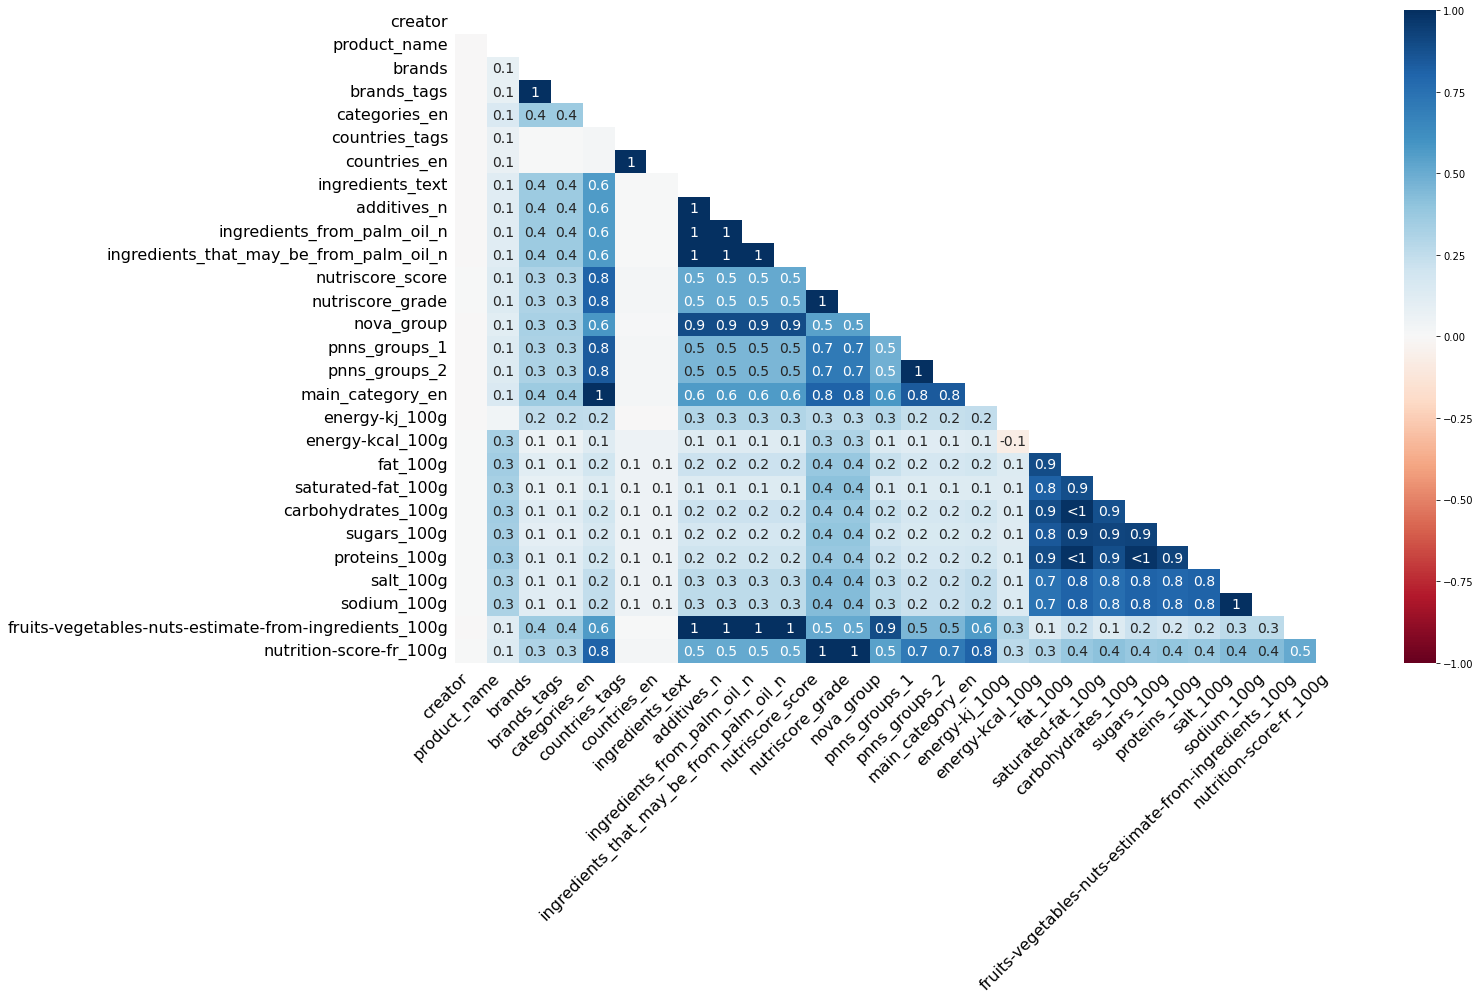

In [21]:
msno.heatmap(df)

<AxesSubplot:>

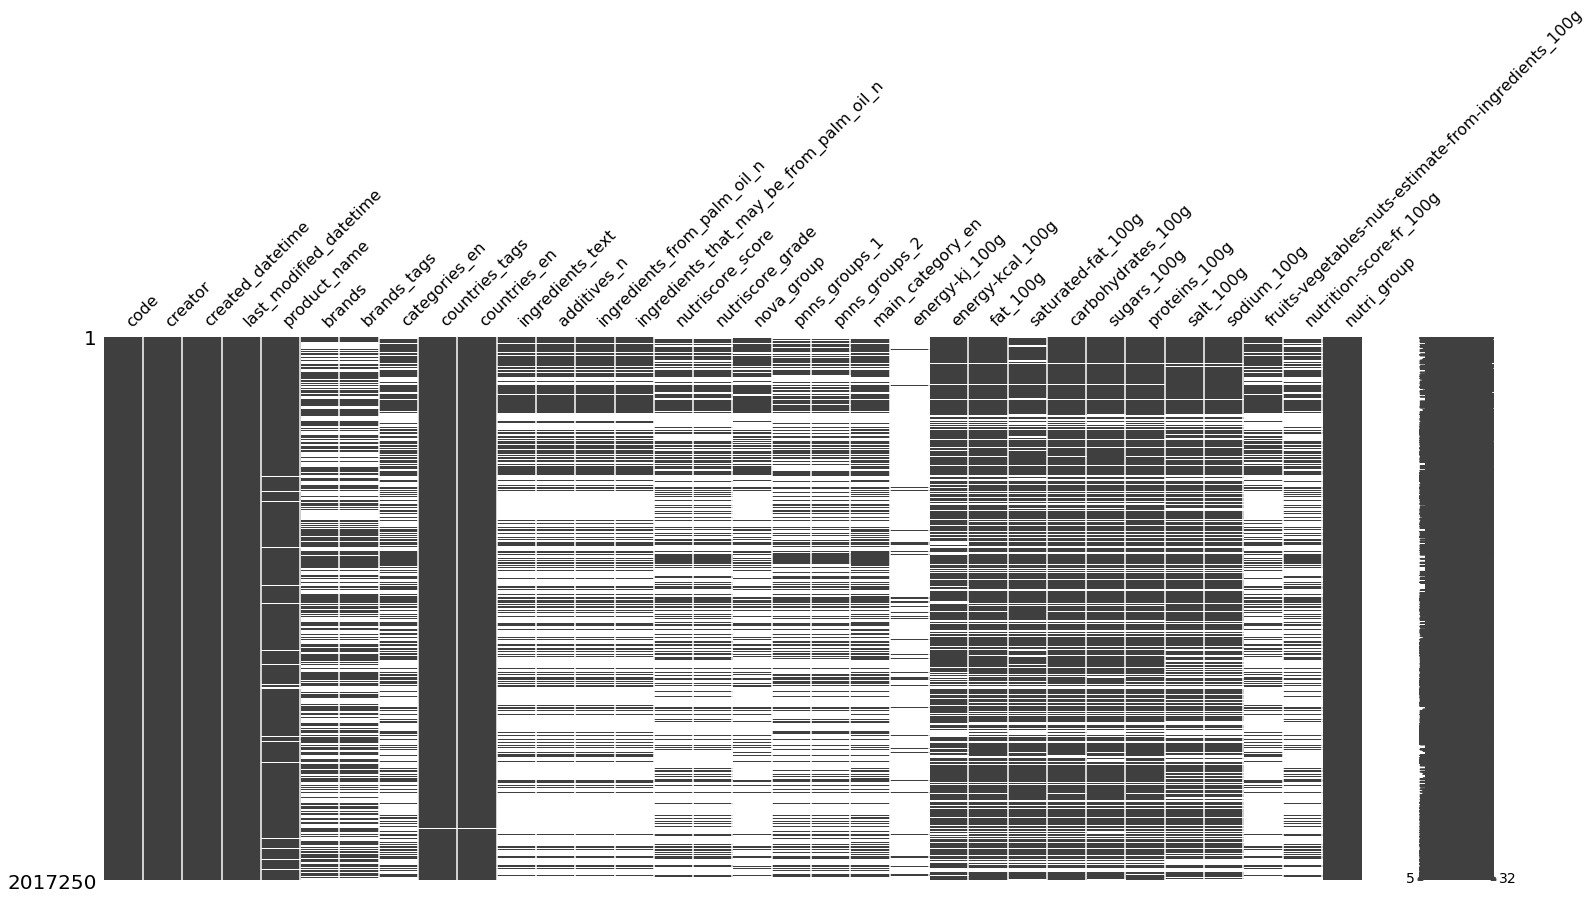

In [22]:
# Avant nettoyage
msno.matrix(df)

<AxesSubplot:>

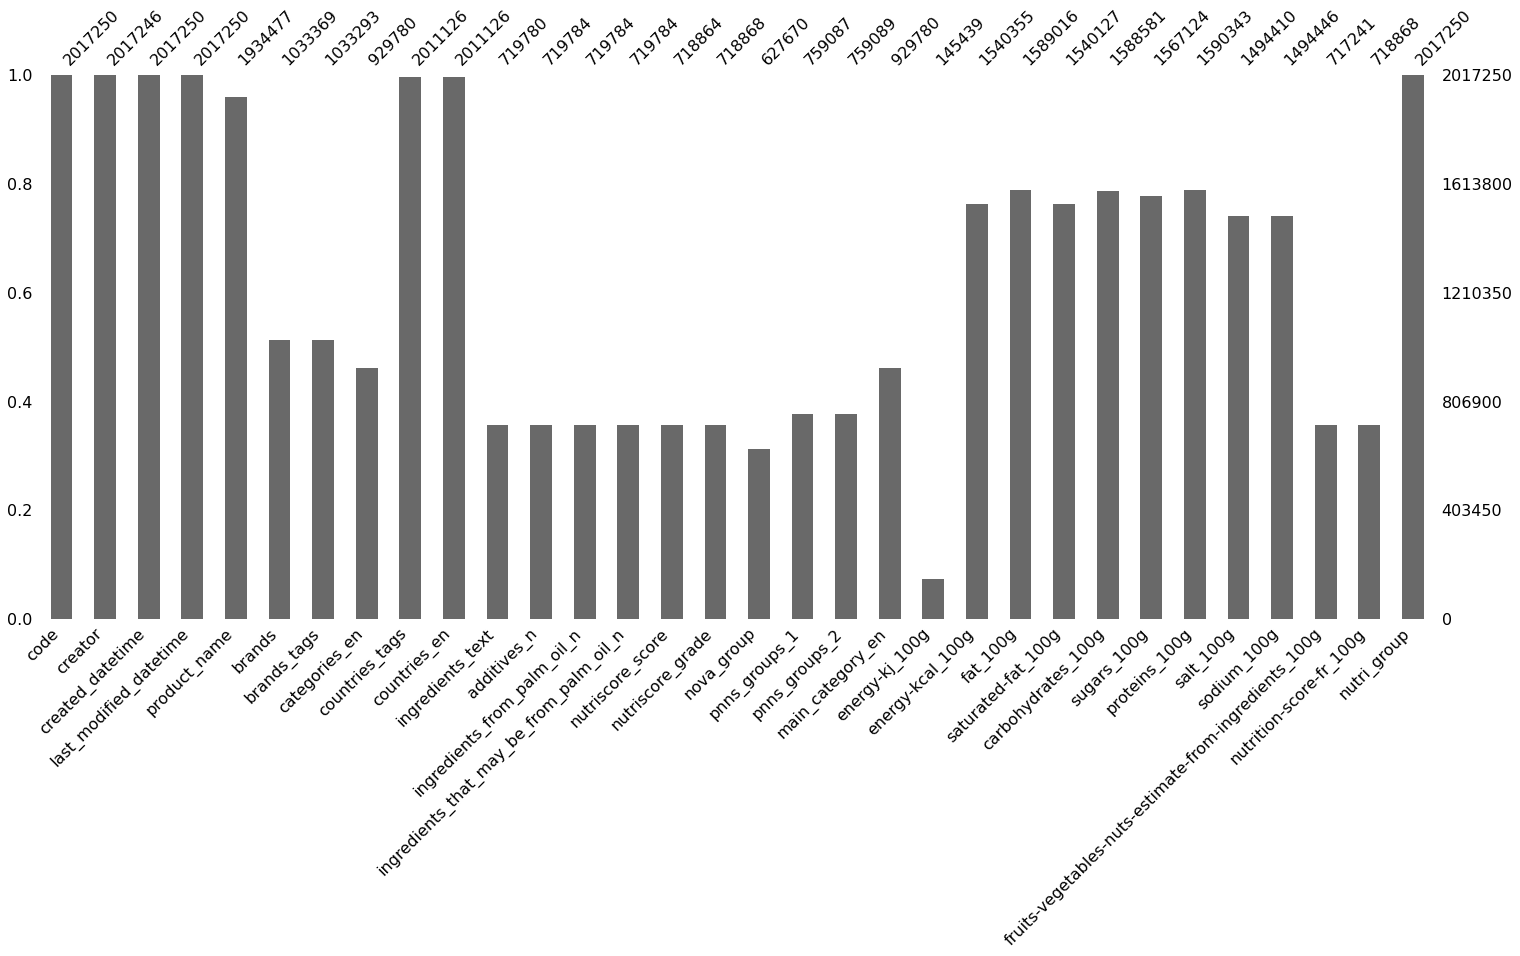

In [23]:
msno.bar(df)

### 1.3.1. Analyse des autres doublons possible


In [24]:
df.duplicated(subset=['brands_tags', 'product_name', 'countries_tags']).sum()

401050

In [25]:
df.duplicated(subset=['brands_tags', 'product_name', 'countries_tags', 'categories_en']).sum()

351826

In [26]:
df.duplicated(subset=['brands_tags', 'product_name', 'countries_tags', 'categories_en', 'ingredients_text']).sum()

295373

In [27]:
df.duplicated(subset=['brands_tags', 'product_name', 'countries_tags', 'categories_en', 'ingredients_text', 'pnns_groups_1', 'pnns_groups_2']).sum()

295369

In [28]:
df.duplicated(subset=['brands_tags', 'product_name', 'countries_tags', 'categories_en', 'ingredients_text', 'pnns_groups_1', 'pnns_groups_2', 'main_category_en']).sum()

295369

In [29]:
df['ingredients_text'].isna().sum()

1297470

C'est bizarre qu'il y ait autant d'ingredient en doublon, sauf si les NAN sont comptés

In [30]:
df.duplicated(subset=['ingredients_text']).sum()

1410794

A priori les NAN sont comptés, on ne peut pas se fier au doublon sur les ingrédients

In [31]:
# ---------------------------------------------------------------------------------------------
# NETTOYAGE DES DONNEES
df = va_pre.clean_df_na(df, verbose, remove_added_col=True)
# Vérifier les colonnes qui manquent plus ou moins de données
df.isna().mean().sort_values(ascending=False)

Add NB_NAN_0 Column(2017250, 33) ---------- DONE
Remove duplicated 'code': (2017235, 33) NA 24_134_143 > 24_133_984 (-159) ---------- DONE
Remove lines nutrigrade == NAN and NUTRI < 8 /11 ['energy-kj_100g', 'energy-kcal_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g', 'additives_n'] NA 24_134_143 > 15_203_639 (-8_930_504) ---------- DONE
duplicated on other columns  False    1425207
True      175371
dtype: int64: (1425207, 34) NA 24_134_143 > 12_901_610 (-11_232_533) ---------- DONE
Remove na 'product_name': (1419279, 34) NA 24_134_143 > 12_841_825 (-11_292_318) ---------- DONE
Clean pmms group
clean_pms_group_na NA 800_334 > 664_093 (136_241) in 0.01 minutes...................................... END
Clean pmms group (1419279, 35) ---------- DONE
Complete energy datascomplete_kcal_from_kj_values NA 63_218 > 14_673 (48_545) in 0.00 minutes...................................... END
comple

nova_group                                               0.599495
pnns_groups_2                                            0.563902
pnns_groups_1                                            0.563902
fruits-vegetables-nuts-estimate-from-ingredients_100g    0.551796
ingredients_text                                         0.550842
ingredients_from_palm_oil_n                              0.550842
ingredients_that_may_be_from_palm_oil_n                  0.550842
additives_n                                              0.550842
nutriscore_score                                         0.533217
nutrition-score-fr_100g                                  0.533214
nutriscore_grade                                         0.533214
main_category_en                                         0.467909
pnns_groups                                              0.467909
categories_en                                            0.467909
brands_tags                                              0.410453
brands    

### 1.3.2. Typage des données

In [32]:
# ---------------------------------------------------------------------------------------------
# COMPLEMENT DES DONNEES
df = va_pre.typing_data(df, verbose)

typing_data 23 upated 3.709 secondes................................................... END


In [33]:
df.dtypes

code                                                                  object
creator                                                               object
created_datetime                                         datetime64[ns, UTC]
last_modified_datetime                                   datetime64[ns, UTC]
product_name                                                          object
brands                                                                object
brands_tags                                                           object
categories_en                                                         object
countries_tags                                                        object
countries_en                                                          object
ingredients_text                                                      object
additives_n                                                          float64
ingredients_from_palm_oil_n                                          float64

<AxesSubplot:>

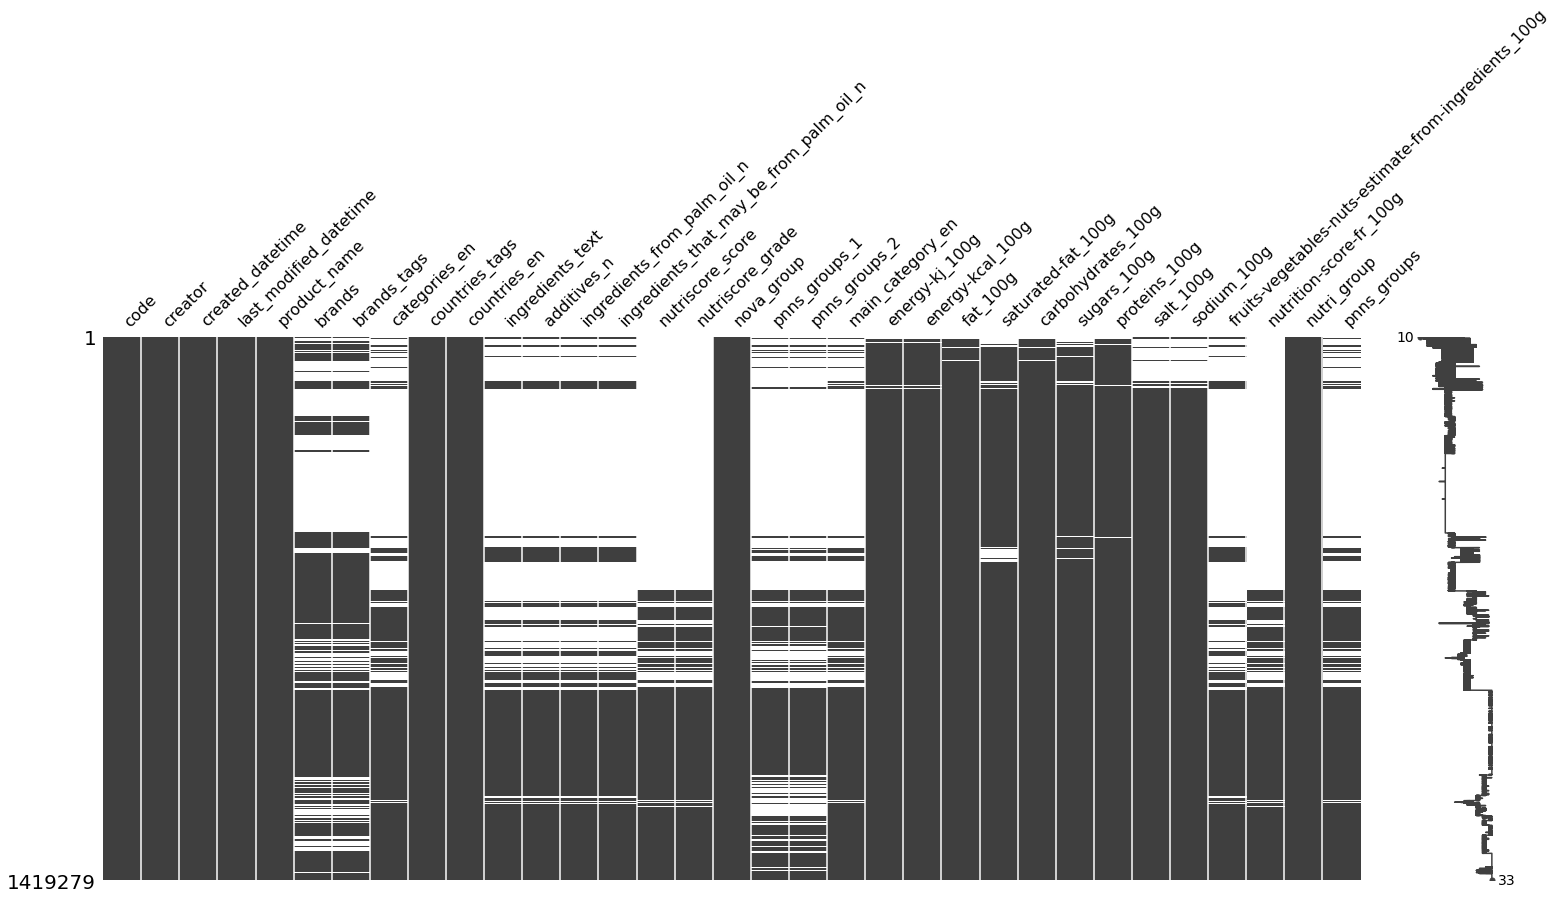

In [34]:
# Après nettoyage
msno.matrix(df)

<AxesSubplot:>

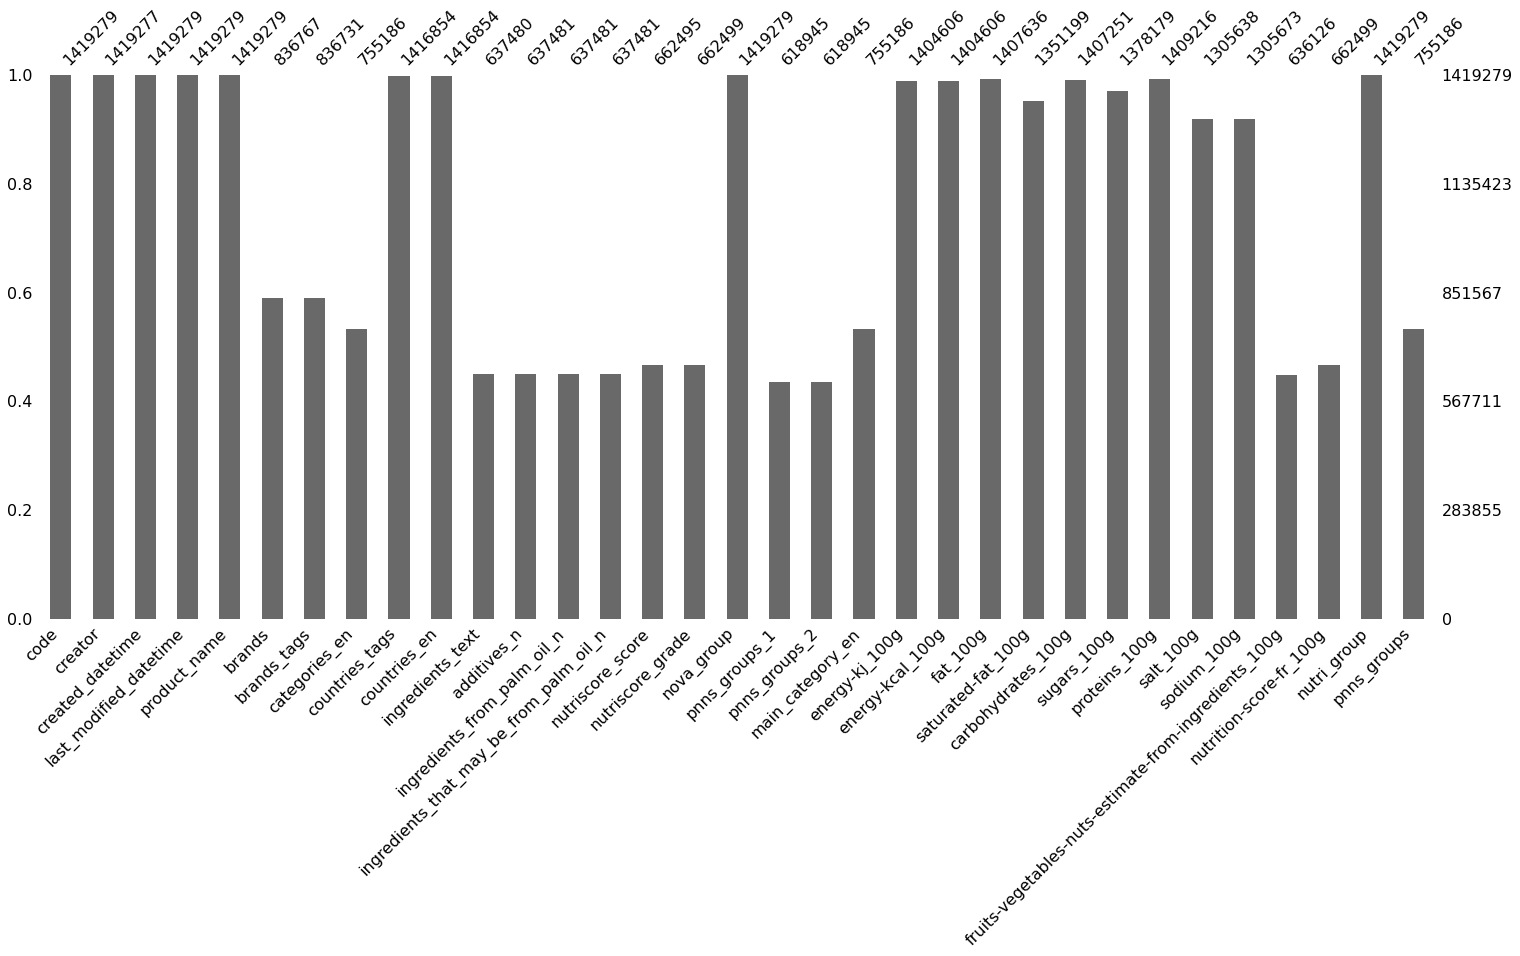

In [35]:
msno.bar(df)

# 2. Traitement des Outliers

## 2.1 Boîtes à Moustaches et remplacement des outliers par la moyenne

Représentation des boites à mustache AVANT et APRES traitement des outliers

Après une première génération des boites à moustaches et scatters de toutes les colonnes numériques, nous avons décidé de limiter aux colonnes :
* product_name
* energy-kj_100g
* energy-kcal_100g
* fat_100g
* saturated-fat_100g
* carbohydrates_100g
* sugars_100g
* proteins_100g
* salt_100g
* sodium_100g
* fruits-vegetables-nuts-estimate-from-ingredients_100g

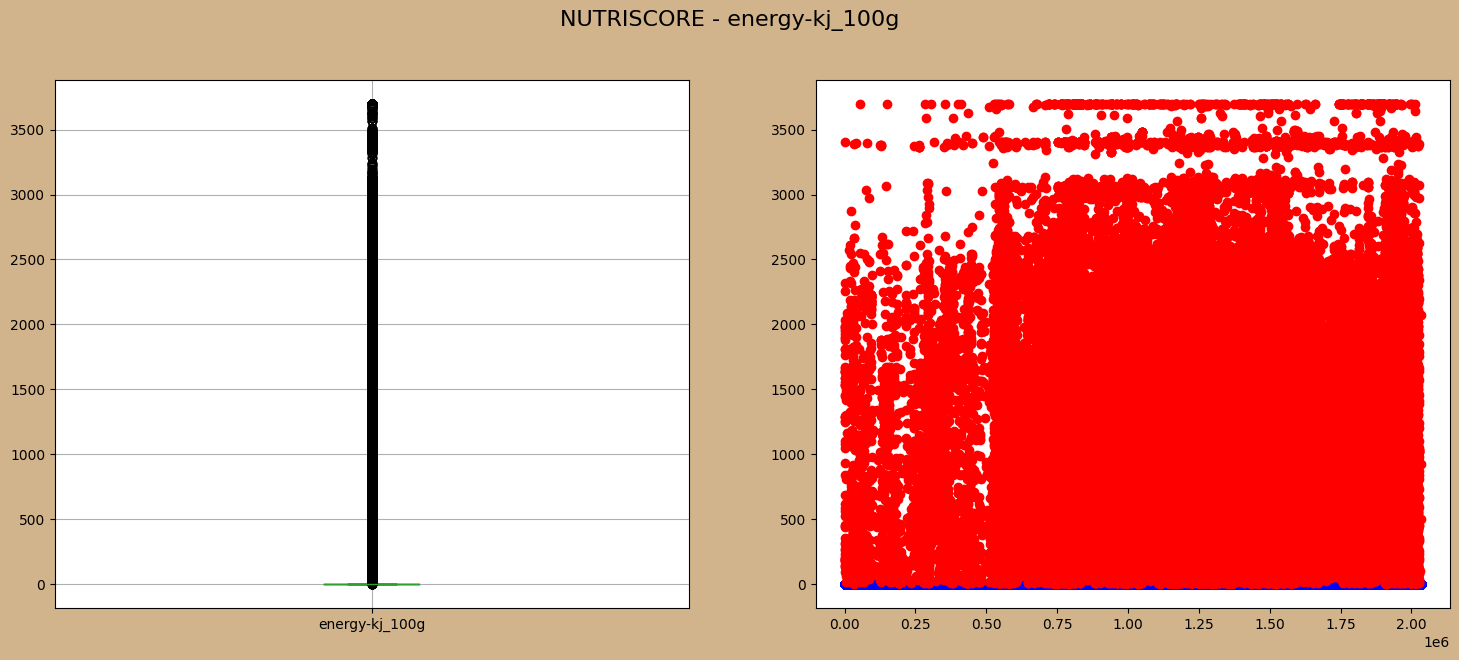

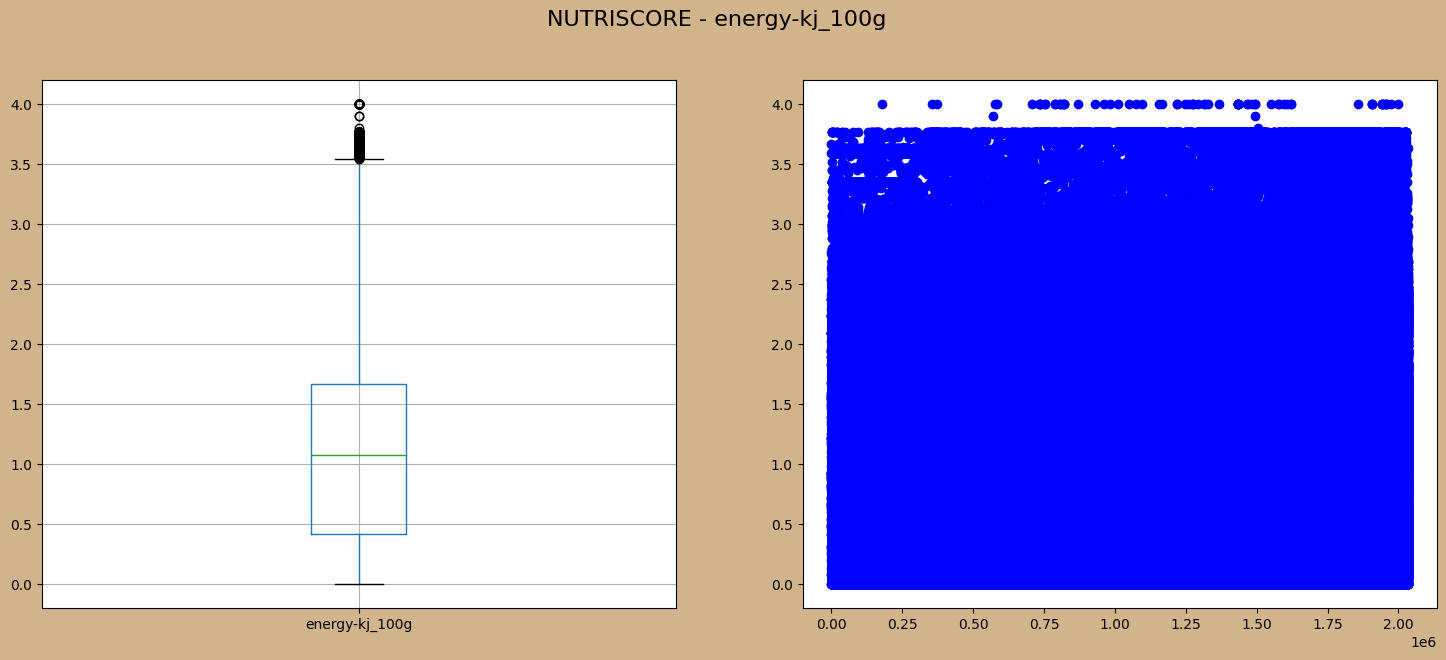

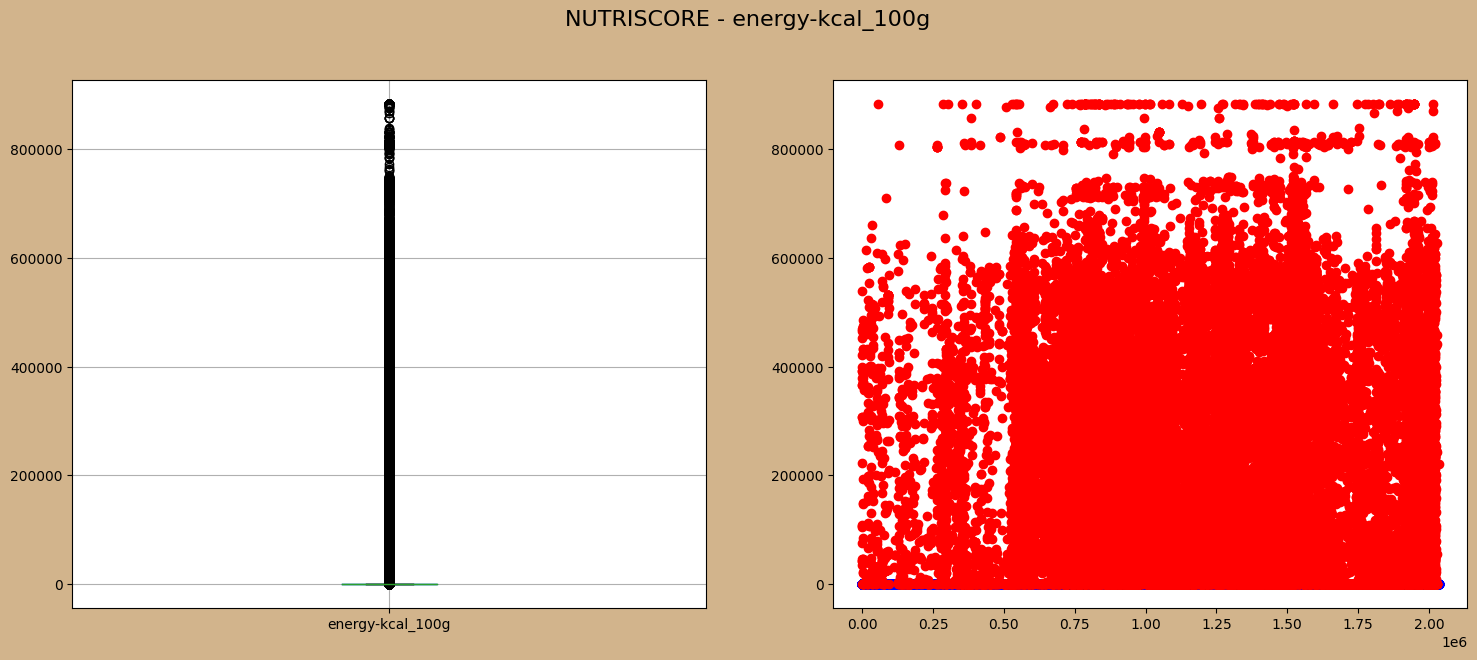

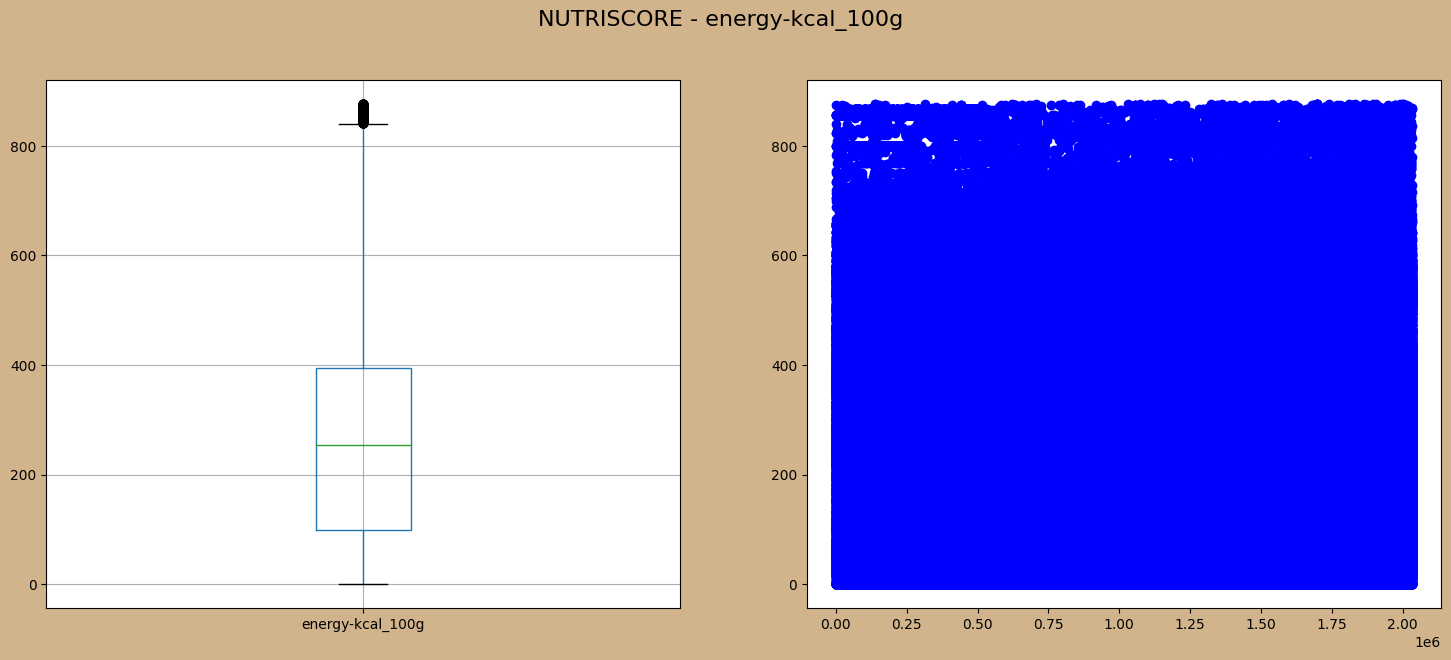

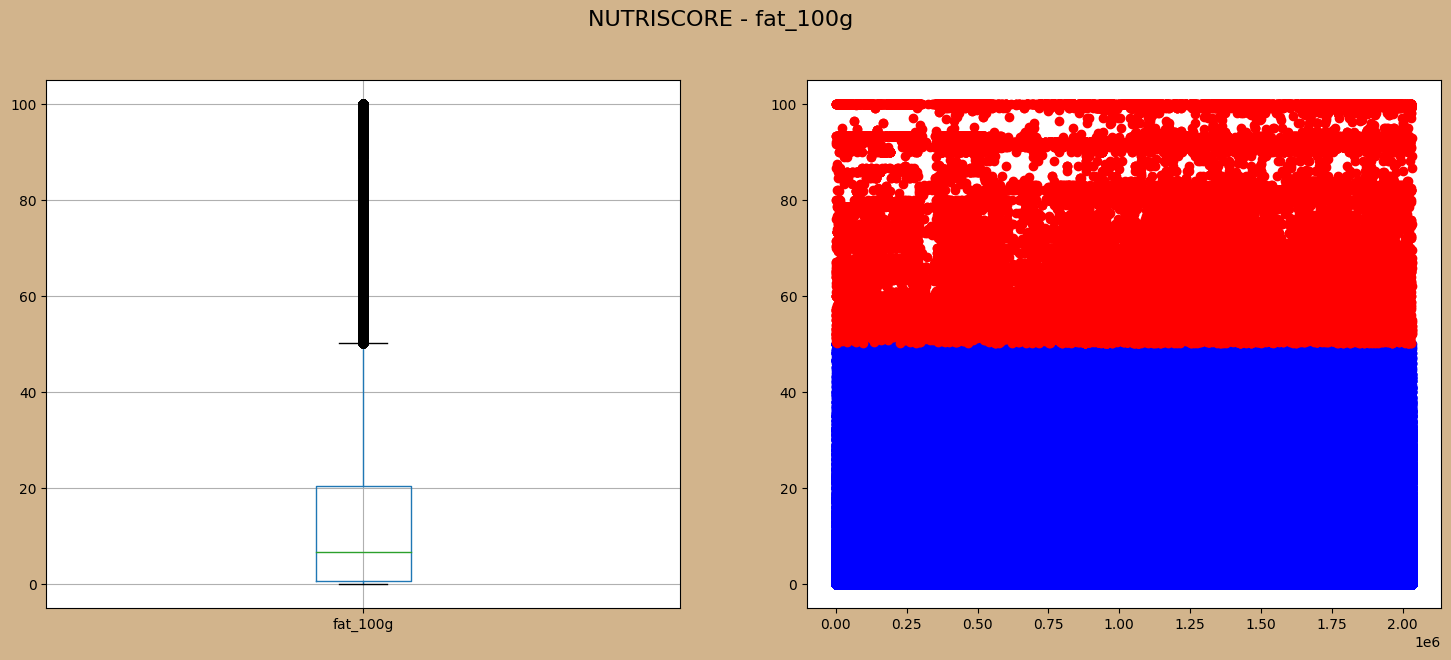

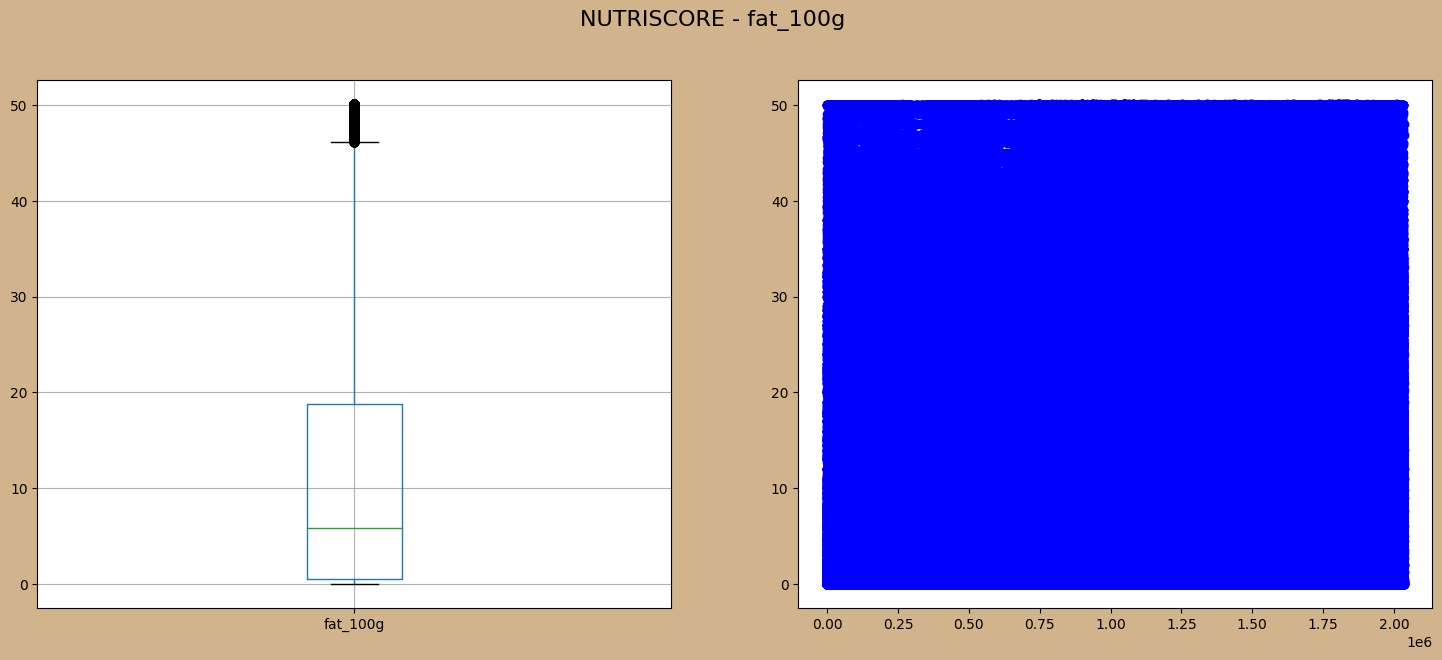

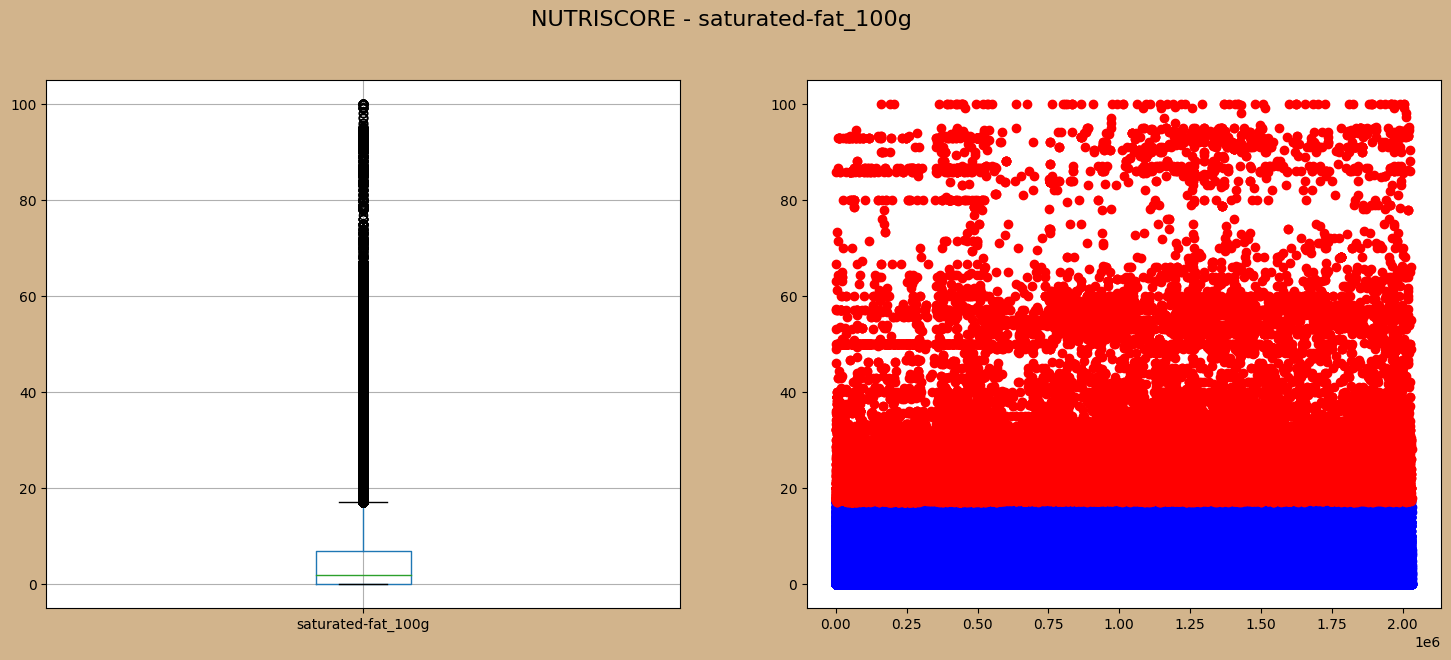

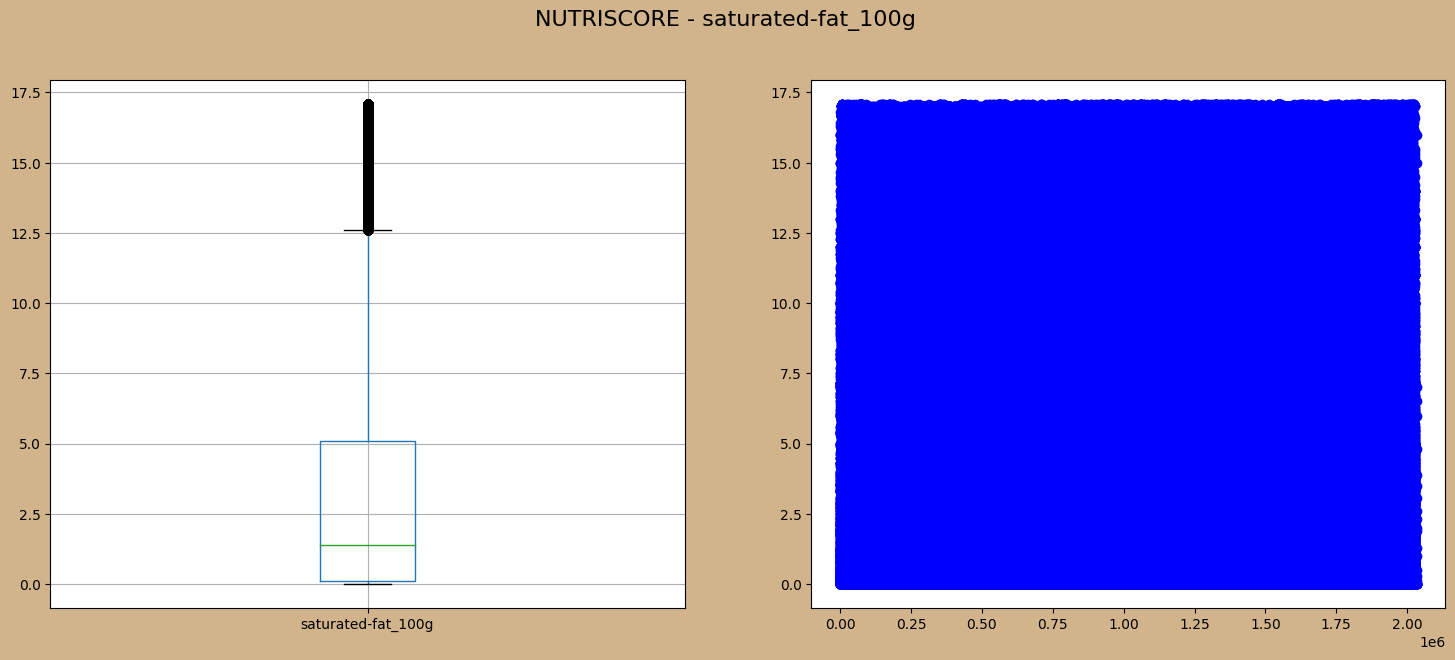

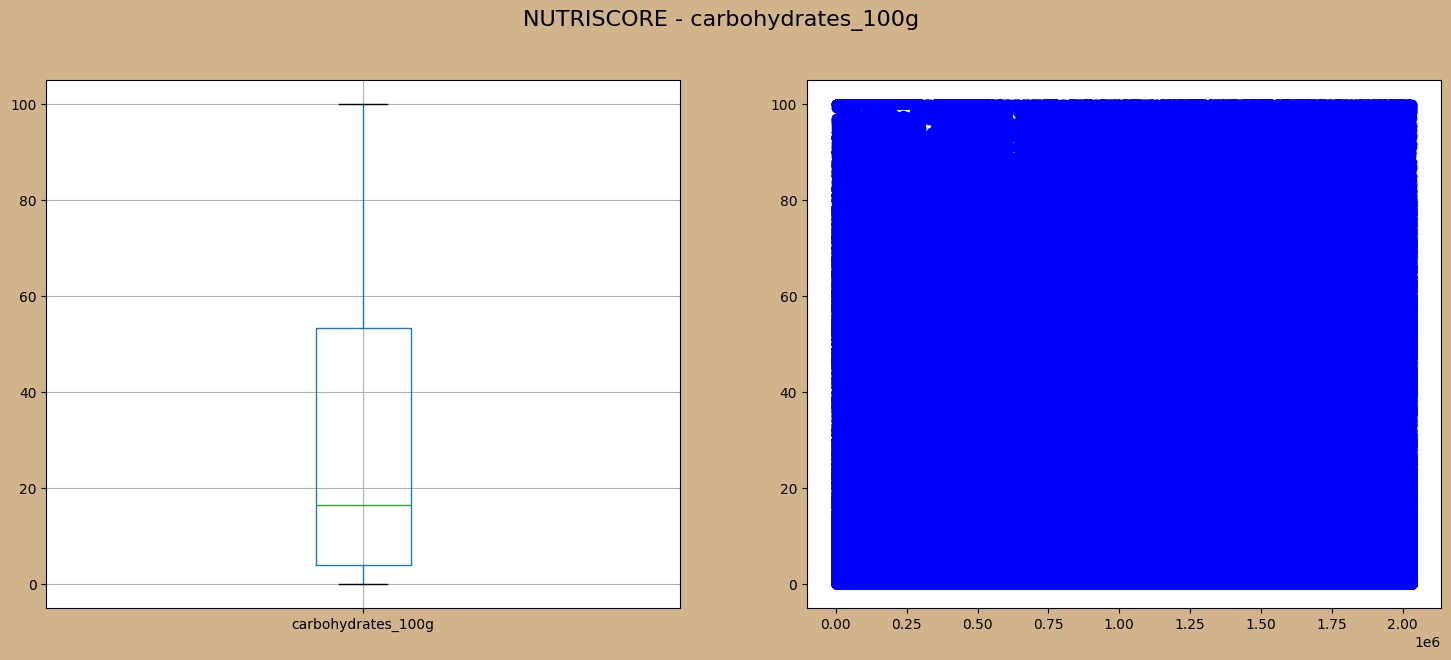

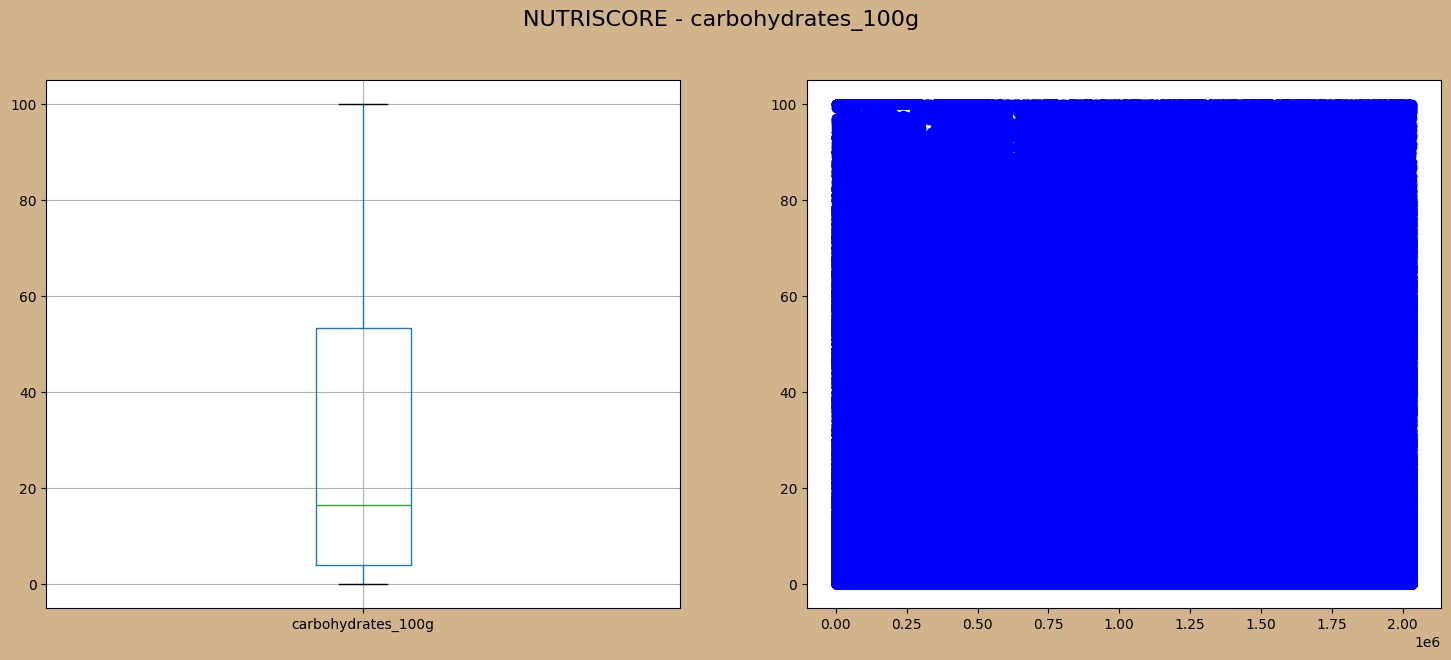

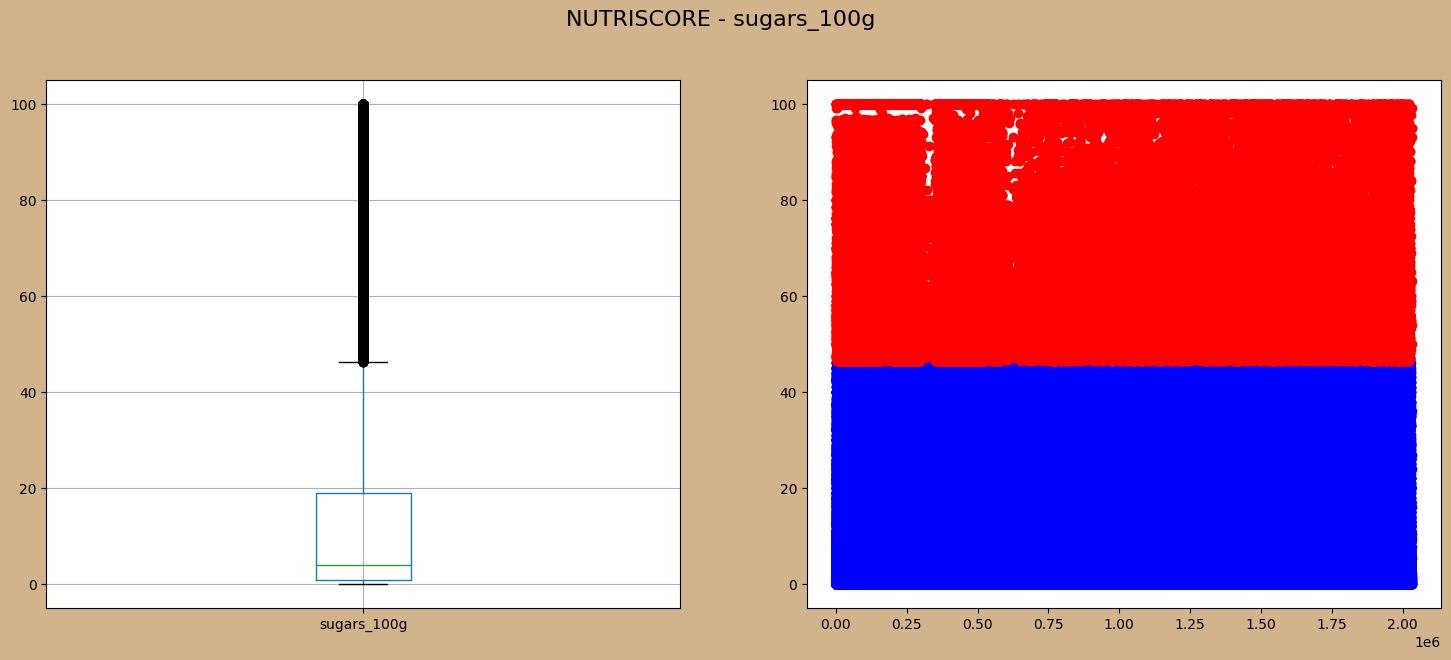

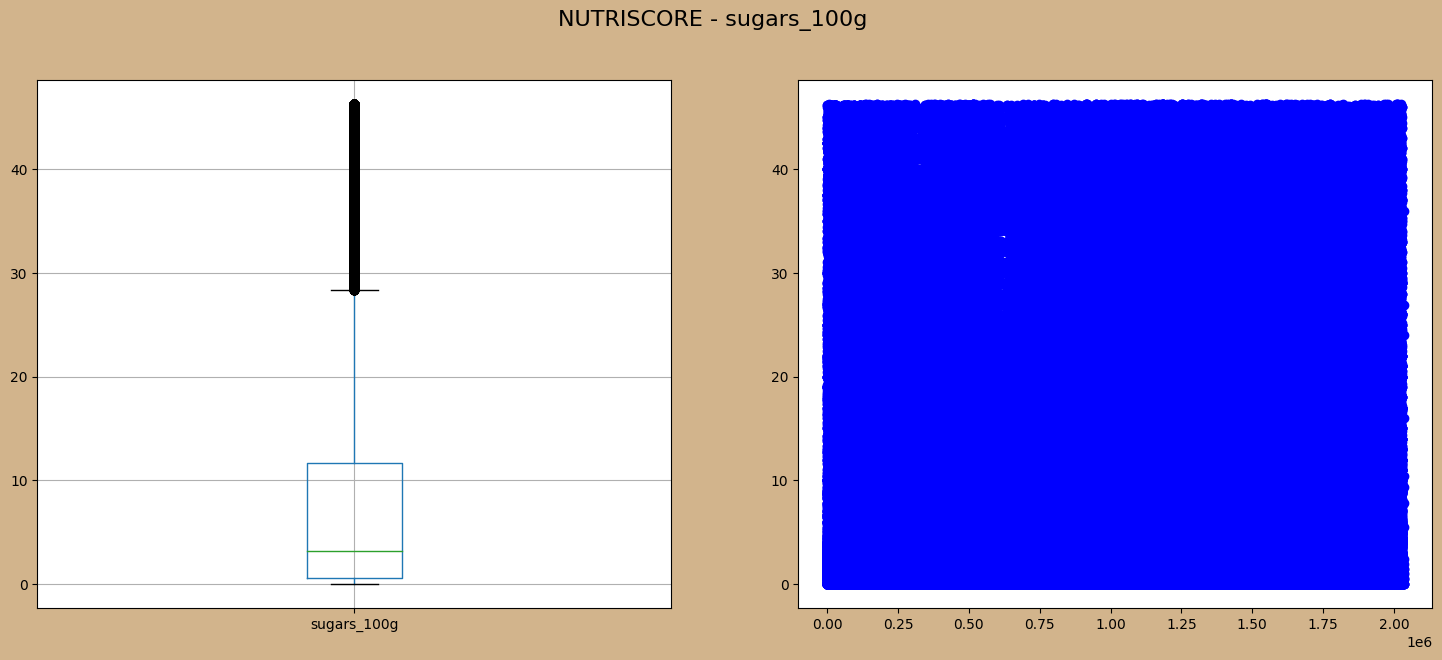

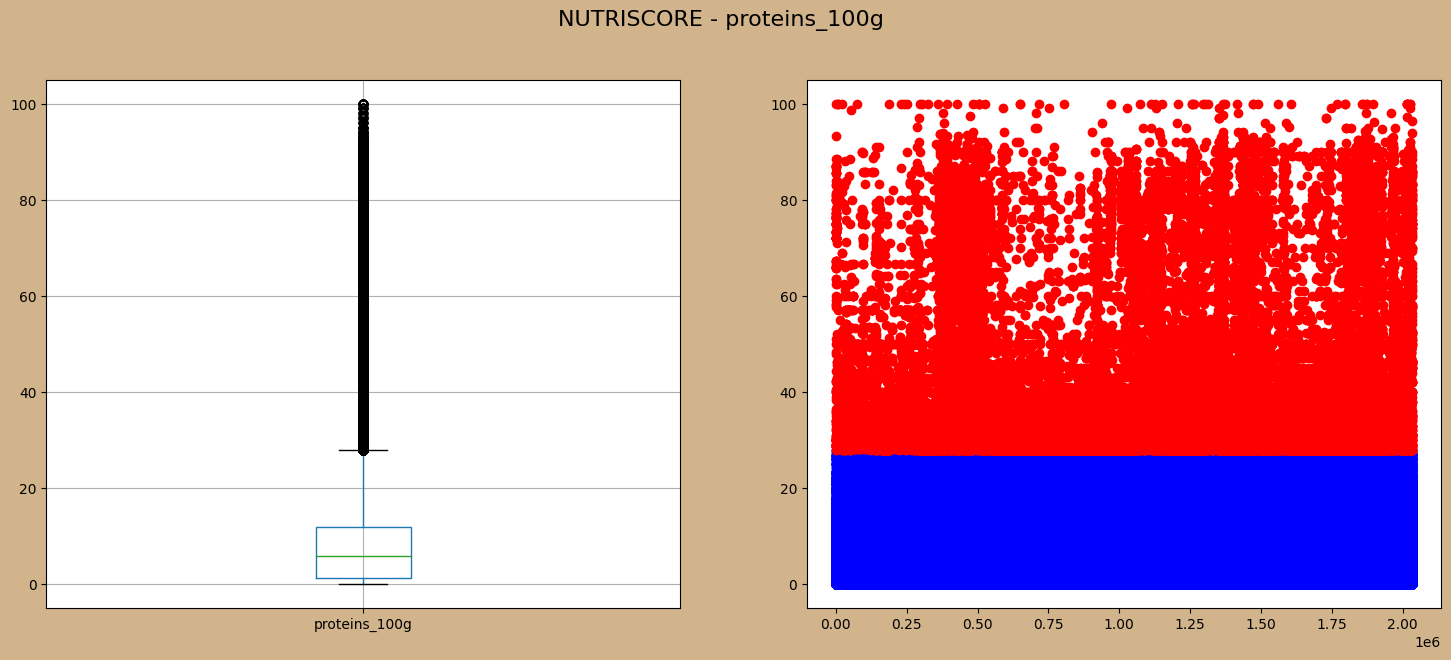

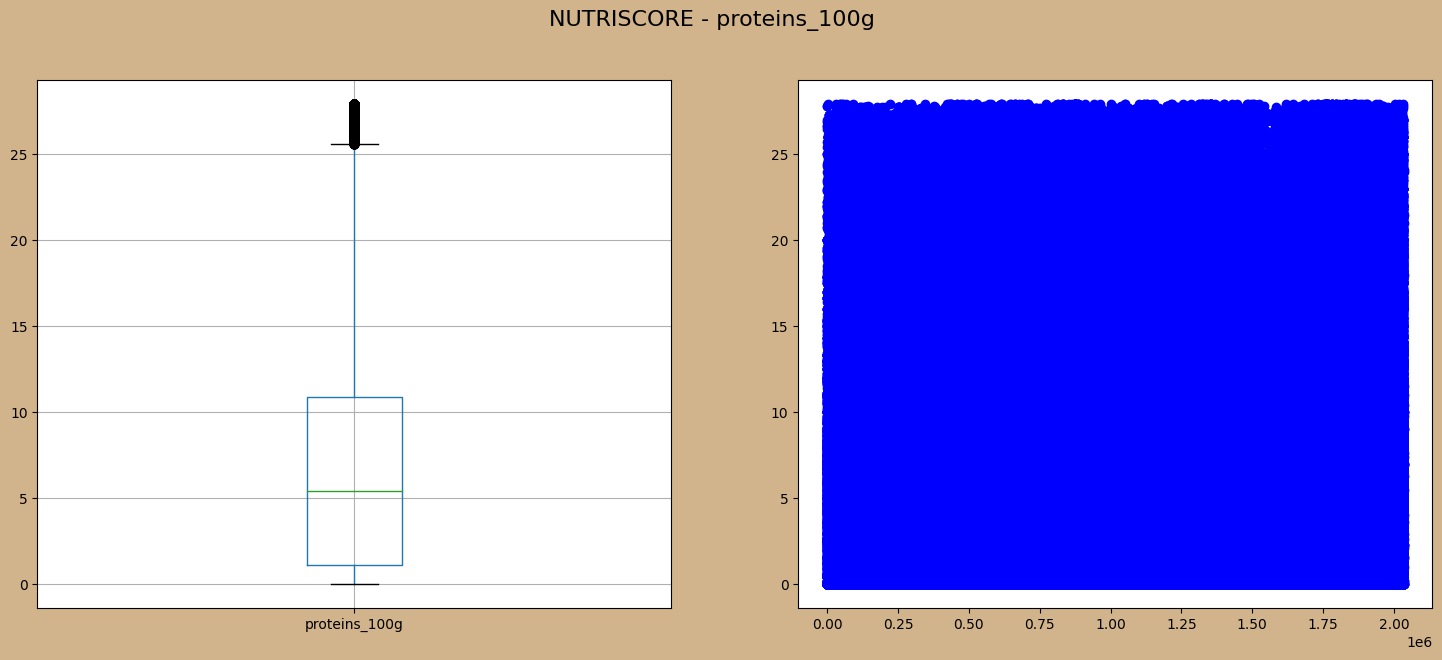

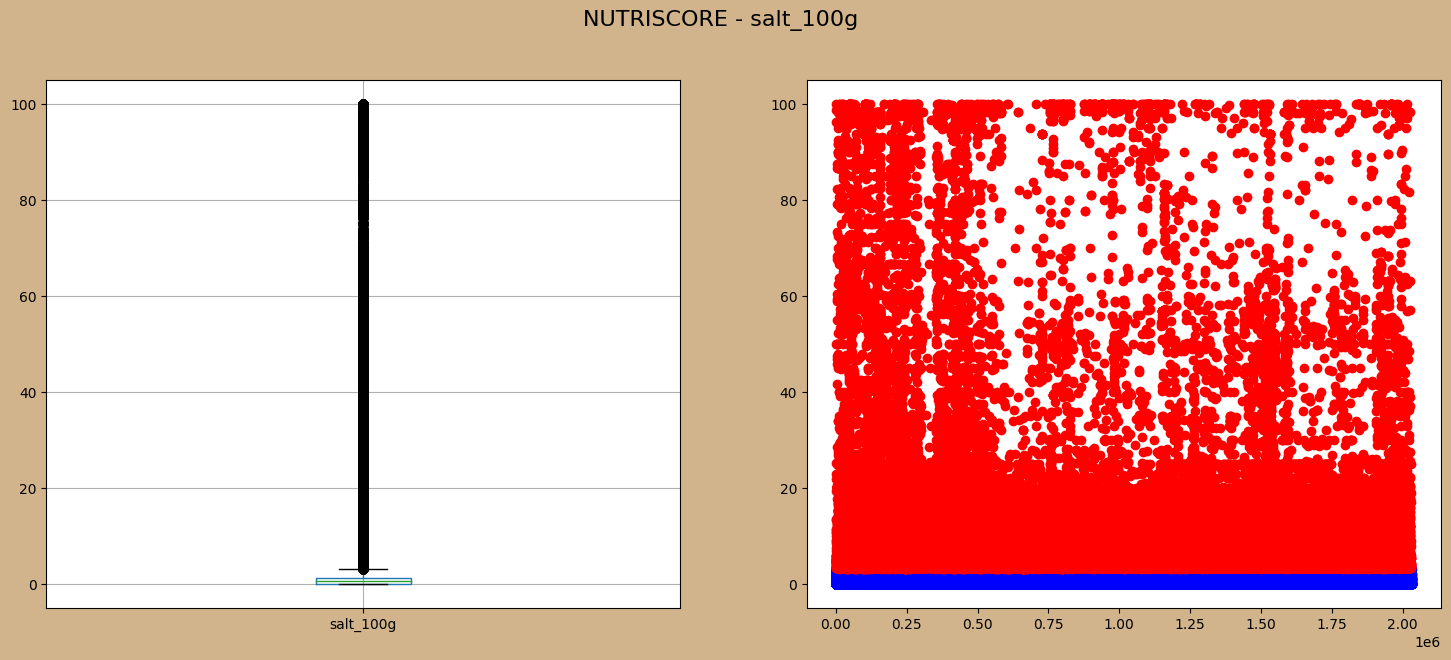

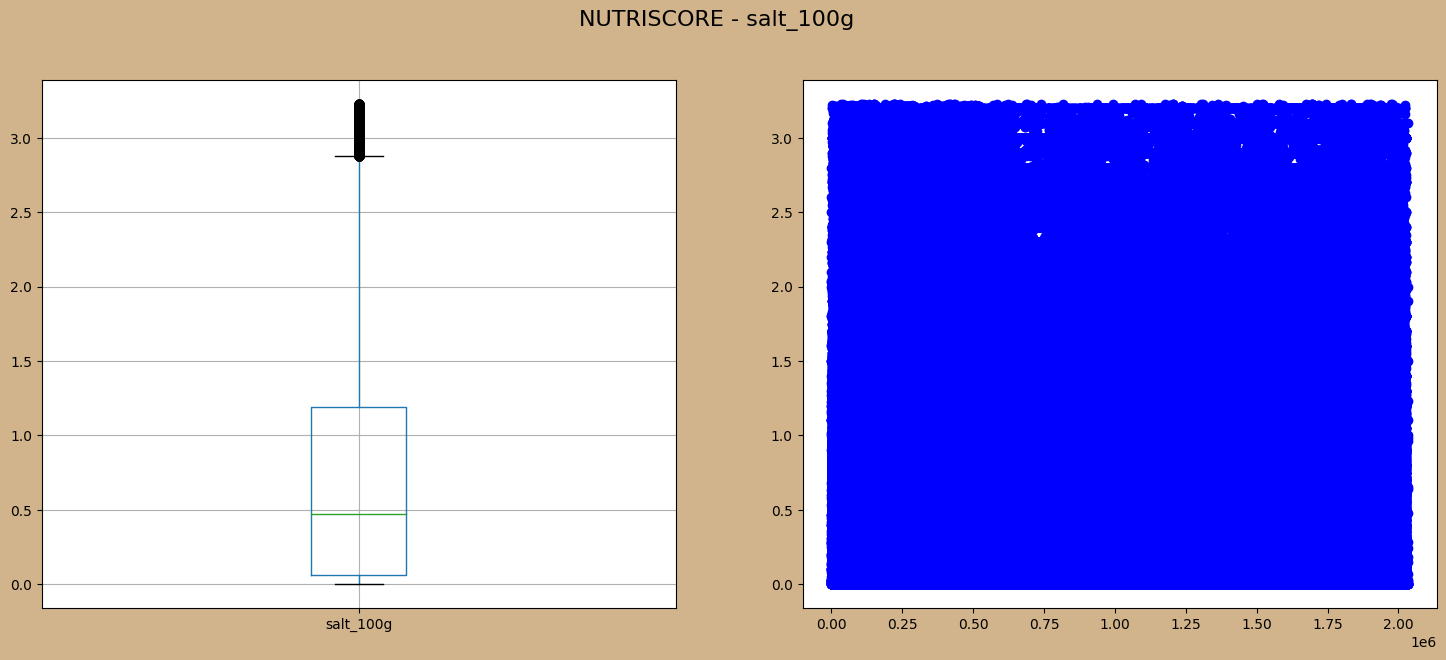

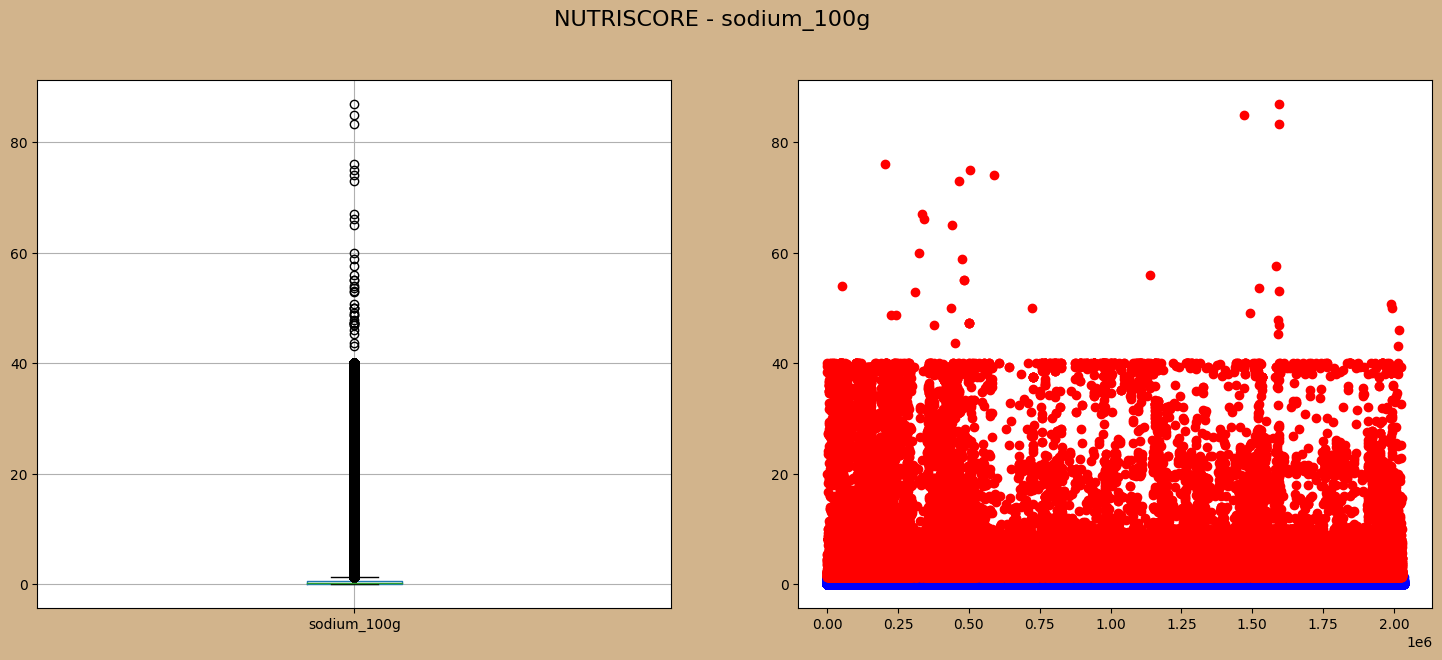

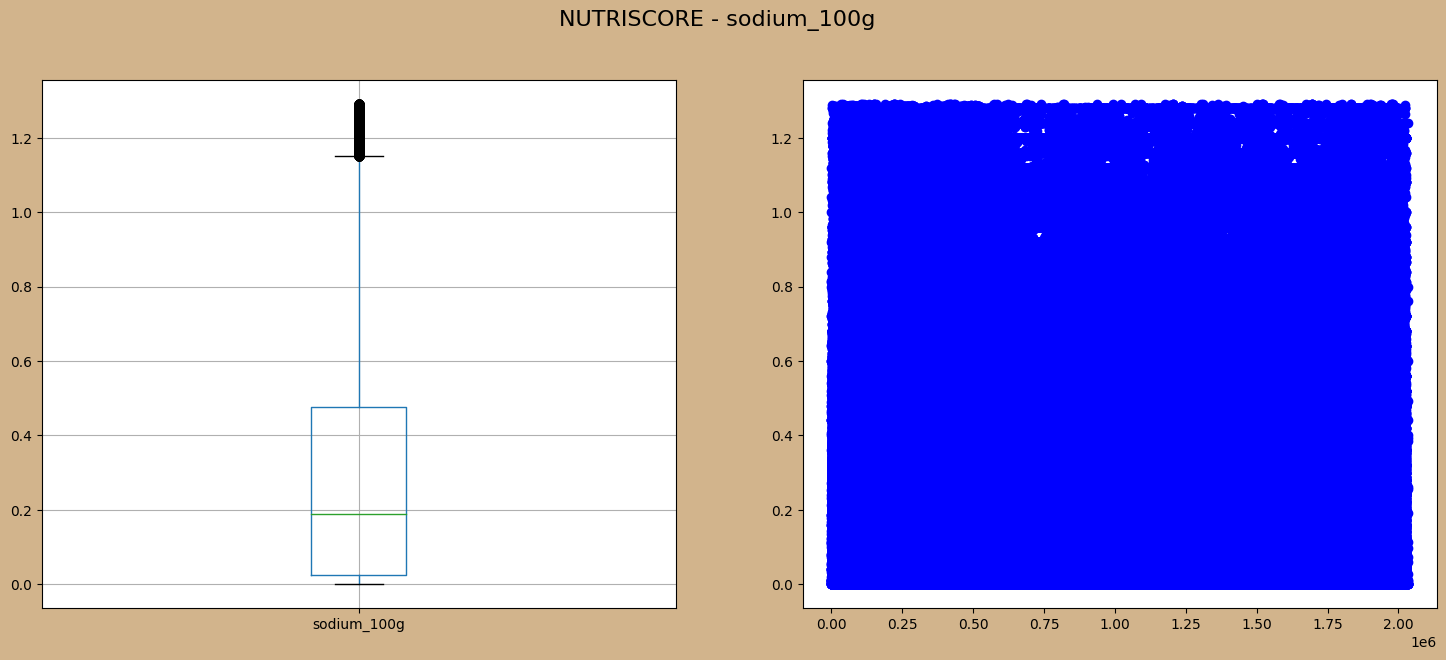

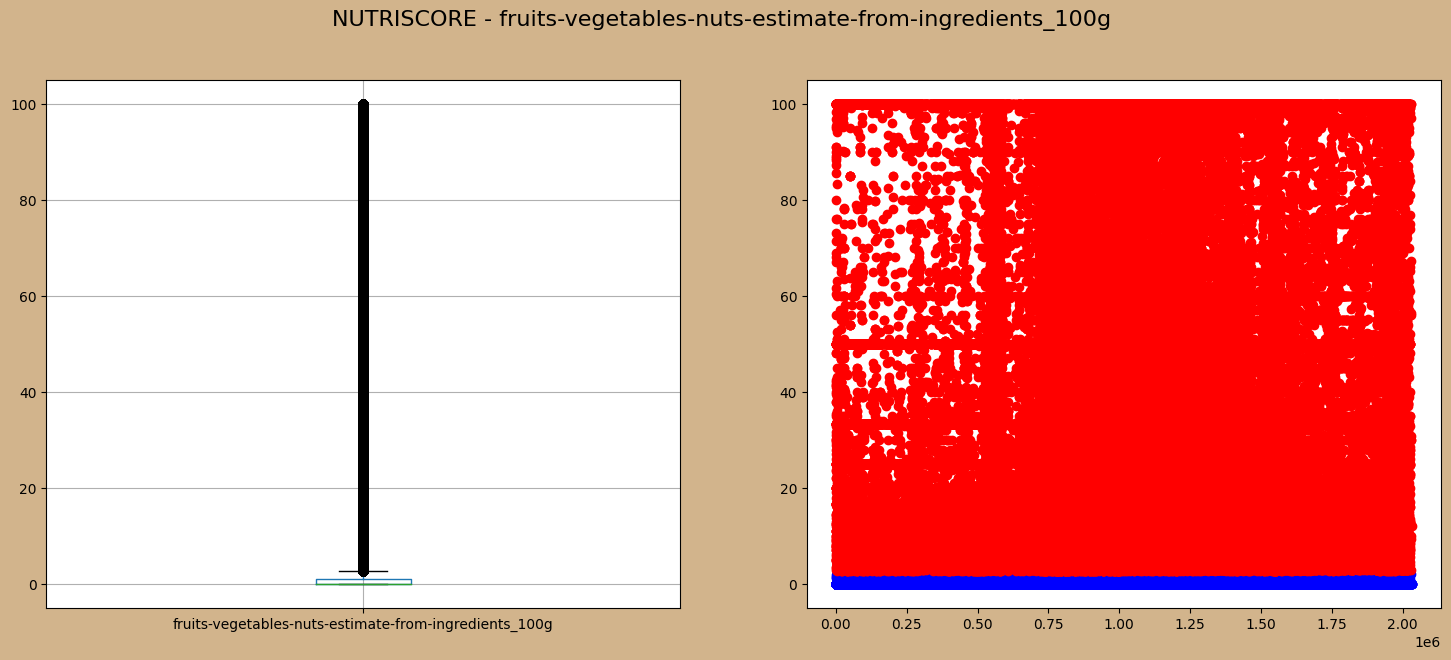

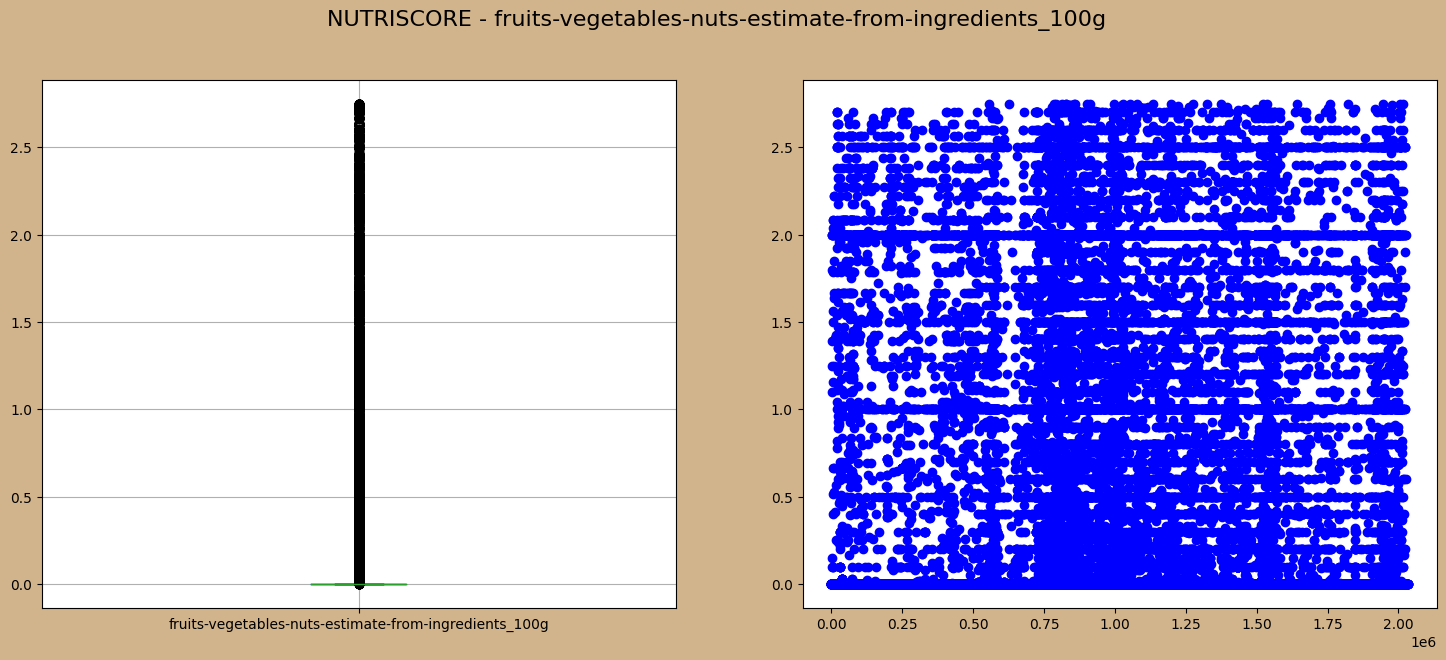

In [36]:
df_out = df.copy()
df_out = va_data.create_boxplot_by_data_before_and_after_outliers(df_out, remove=False, verbose=verbose)

### 2.1.2. Analyse des boites à moustache et des scatters

Suite à cette première génération des boites à moustaches, nous avons analyser quelques données avant de décider de la stratégie finale à appliquer.

In [37]:
df[df["sugars_100g"]>90][["product_name", "pnns_groups"]].head(20)

product_name pnns_groups
1233991                   Raw Sugar         NaN
1403846                       Sweet         NaN
1467936                  Zahar brut         NaN
888959                    Cassonade         NaN
1983760   moulin a sucre impalpable         NaN
1483195               Sucre vanillé         NaN
1255419  Rohrohrzucker aus Paraguay         NaN
527760              Sucre en poudre         NaN
1975345    Thé Ginseng rouge Coréen         NaN
2023368      Organic  Coconut Sugar         NaN
1998918                Gelierzucker         NaN
1170119              Kristallzucker         NaN
1150304      Cedevita XXL voćni mix         NaN
1744389              Sucre de canne         NaN
899892                 Cukier Biały         NaN
276131            Light brown sugar         NaN
756407    Sucre pâtissier ultra fin         NaN
755341    Sucre vanillé Bourbon bio         NaN
2000468              Sucre morceaux         NaN
1246978             Bio Rübenzucker         NaN

In [38]:
print(df[df["sugars_100g"]>90][["product_name", "pnns_groups"]].shape)
df.shape

(6781, 2)


(1419279, 33)

In [39]:
df[df["fat_100g"]>90][["product_name", "pnns_groups"]].head(20)

product_name pnns_groups
1308166                 Vegetable Oil         NaN
379012          Hot Rod Spicy Buffalo         NaN
479047                 Huile d’avocat         NaN
1754296  Оливковое масло Virgin extra         NaN
939851     Leinöl Mixtur Omega- Green         NaN
943102              Huile de feunouil         NaN
1440575                        Virgem         NaN
1183657                      Sesam Öl         NaN
1198070                  Gänseschmalz         NaN
1201274               Beurre de cacao         NaN
1587572             Aceite de girasol         NaN
2030165              Масло расторопши         NaN
2030161                Масло рапсовое         NaN
1200772                        Rapsöl         NaN
1374291                  Extra Virgin         NaN
1252265              Huile de chardon         NaN
1252313              Huile de périlla         NaN
1676043                 Huile d’olive         NaN
487452                      Olive oil         NaN
936387                 Huile végétale         NaN

In [40]:
print(df[df["fat_100g"]>90][["product_name", "pnns_groups"]].shape)
df.shape

(15796, 2)


(1419279, 33)

In [41]:
df[df["proteins_100g"]>90][["product_name", "pnns_groups"]].head(20)

product_name         pnns_groups
143128                      Whey iso burst                 NaN
1587003                 - Cepita Del Valle                 NaN
400345                Vanilla whey protein                 NaN
505464                        Cbum protein                 NaN
1807                             Collagène                 NaN
1489324                               Fish                 NaN
1894188      Carne de vccuno de raza wagyu                 NaN
55039                          Kaiser roll                 NaN
1352951            Skinny ciocolate crunch                 NaN
324092                           جبنة حلوم                 NaN
1124454      Blanquette de veau a la creme      One-dish meals
2031189      Протеин Dymatize Elite Primal                 NaN
2031238  Протеин Ultimate ISO-Sensation 93                 NaN
2029243               Изолят соевого белка                 NaN
378016                           Intra EAA                 NaN
1484923                          NutriSnax  Biscuits and cakes
1206524            Boisson hyper calorique                 NaN
969429                  Oignons rouges bio          Vegetables
593493                            Metapure                 NaN
2025992                  100% WHEY protein                 NaN

Les outliers de la colonne sucre, fat et salt ne sont pas des erreurs mais sont des produits de type matière première utilisé pour fabriquer d'autres produits.

Nous avons opté pour supprimer les valeurs outliers pour ne pas fausser les données.

## 2.2. Traitement des outliers par suppression des produits au fil des générations

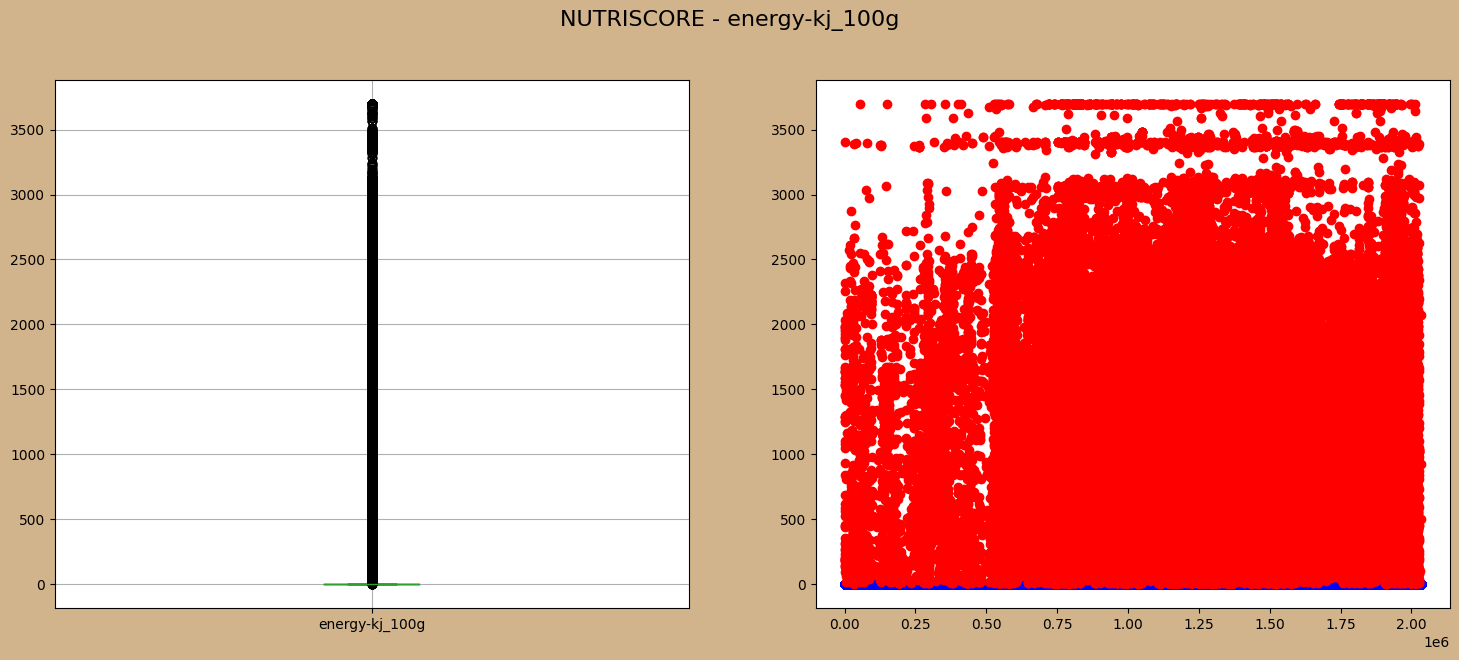

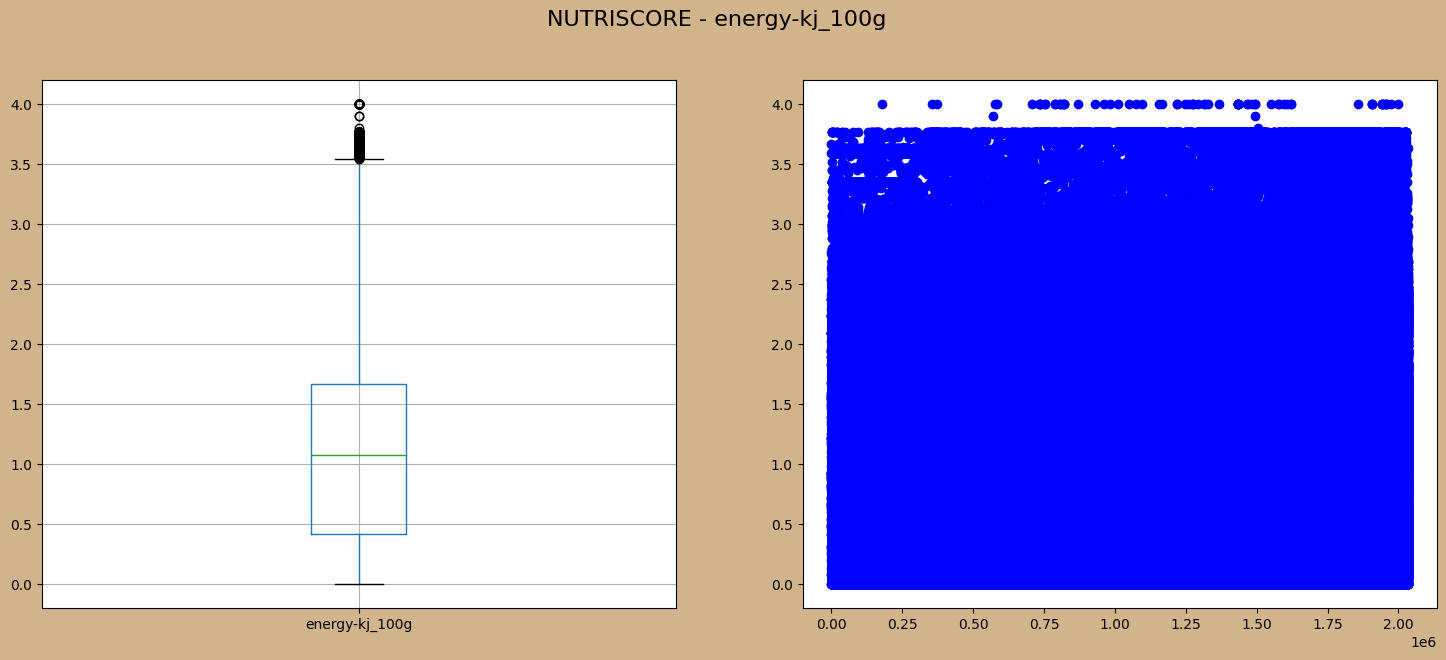

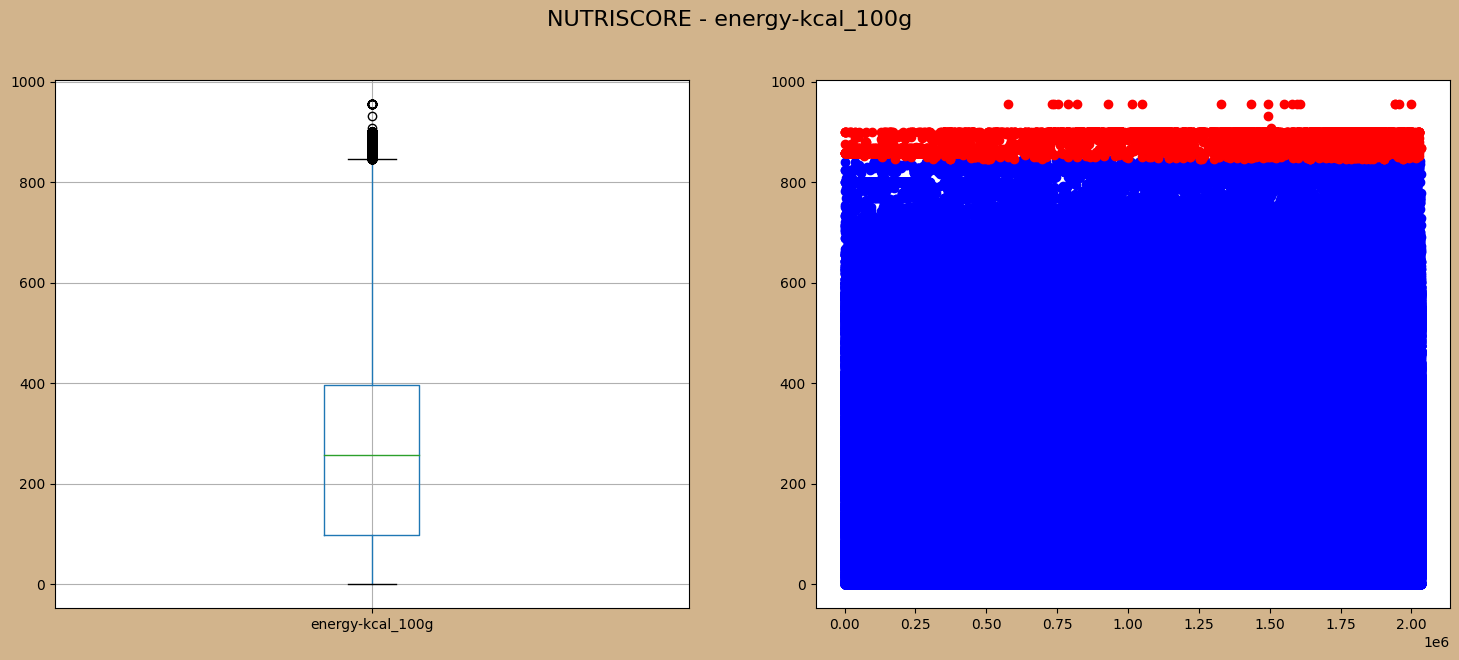

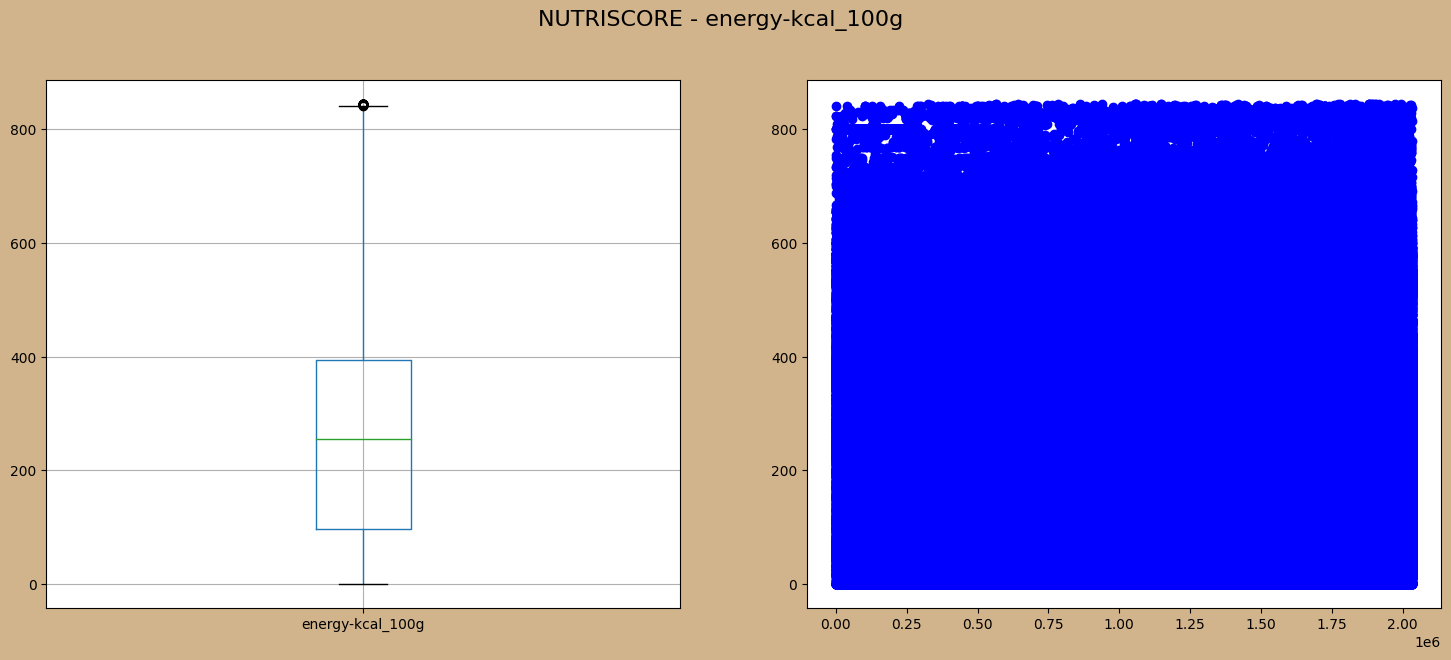

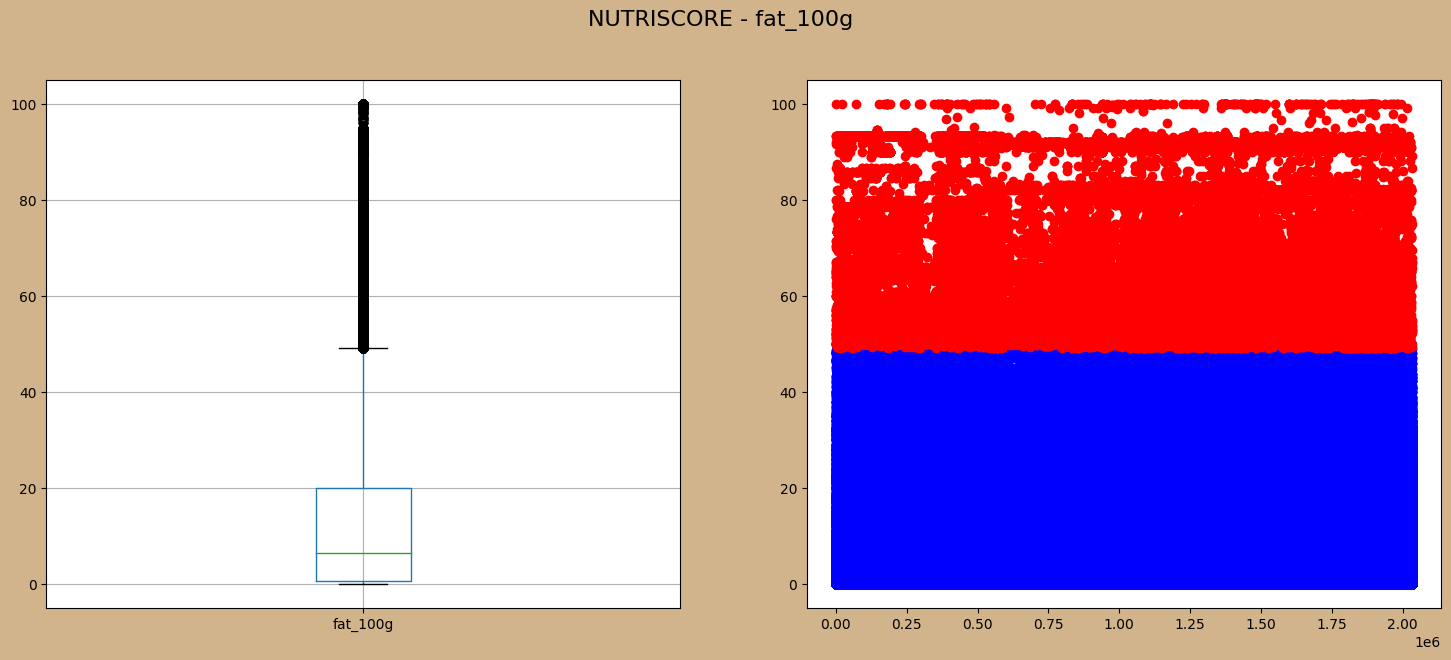

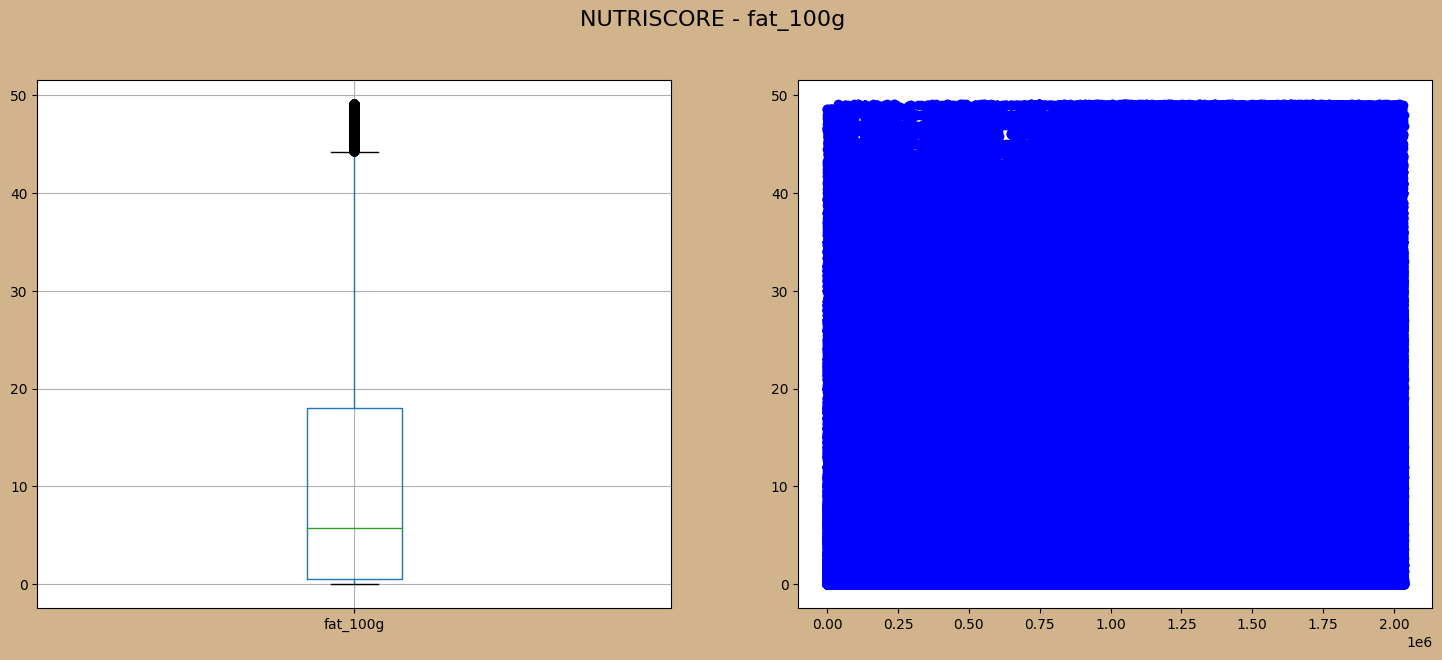

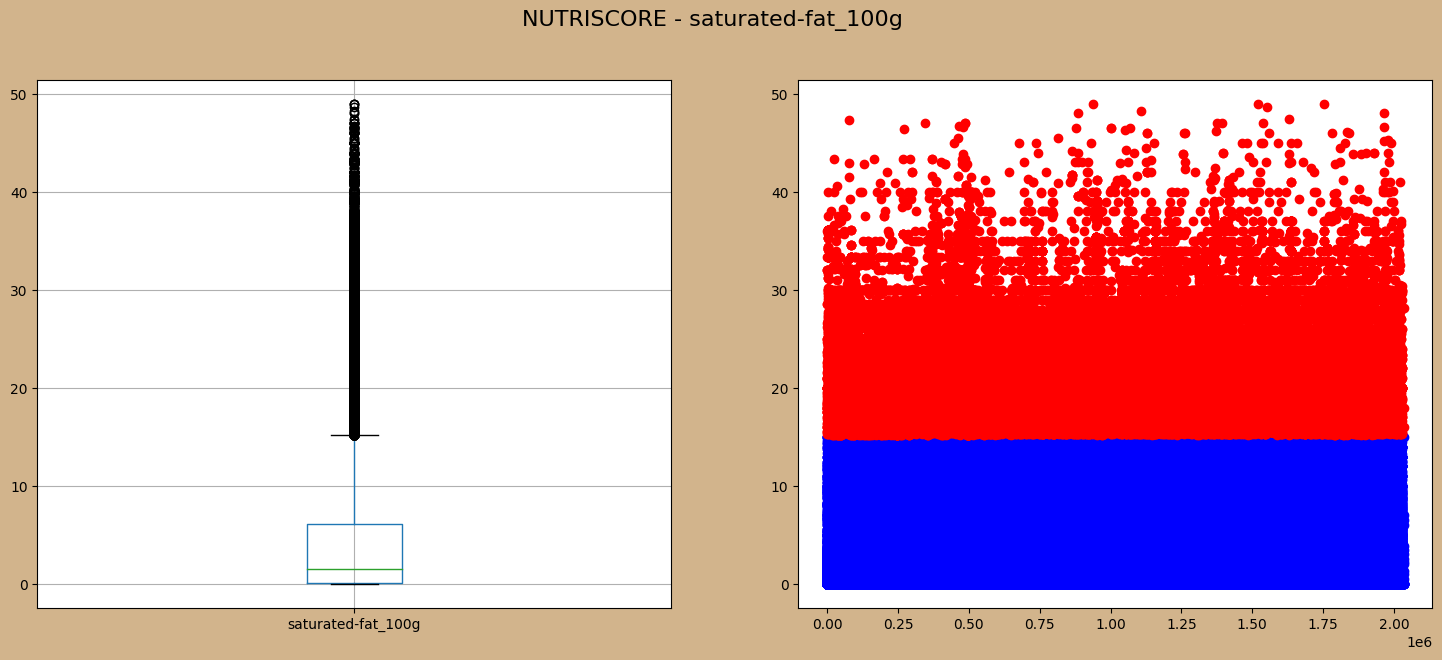

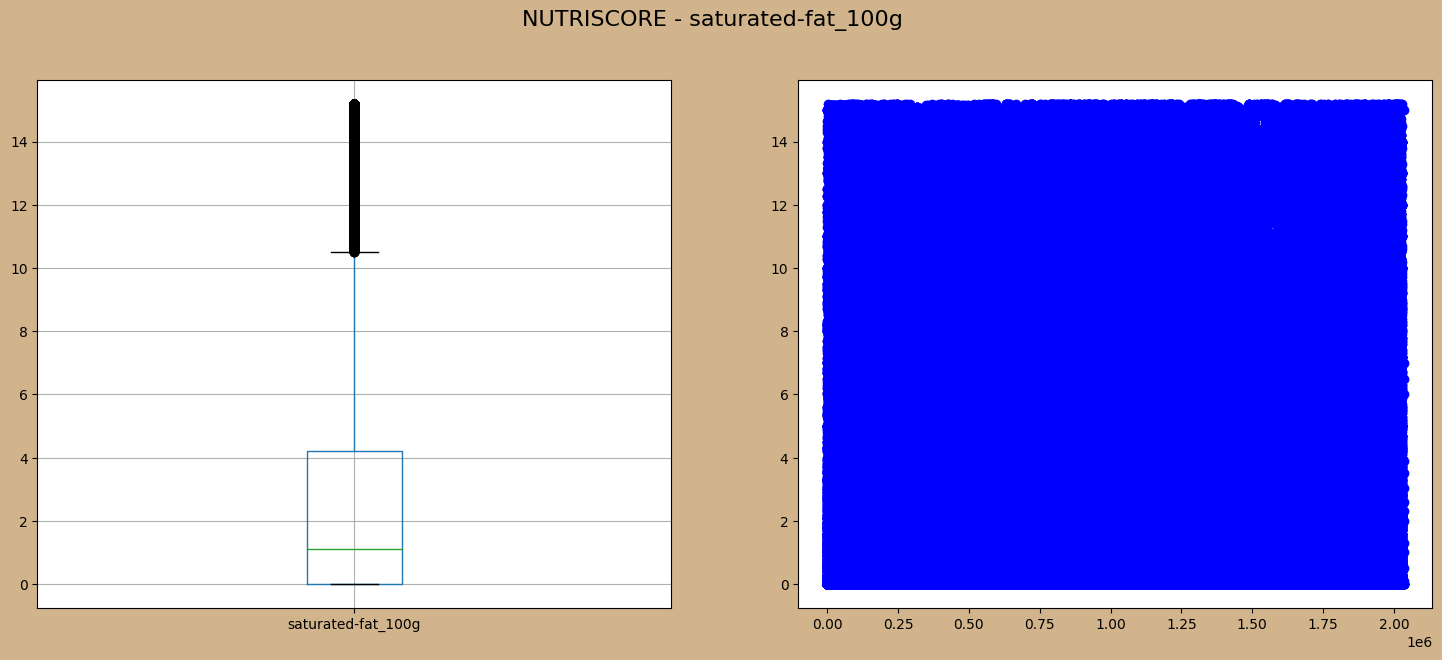

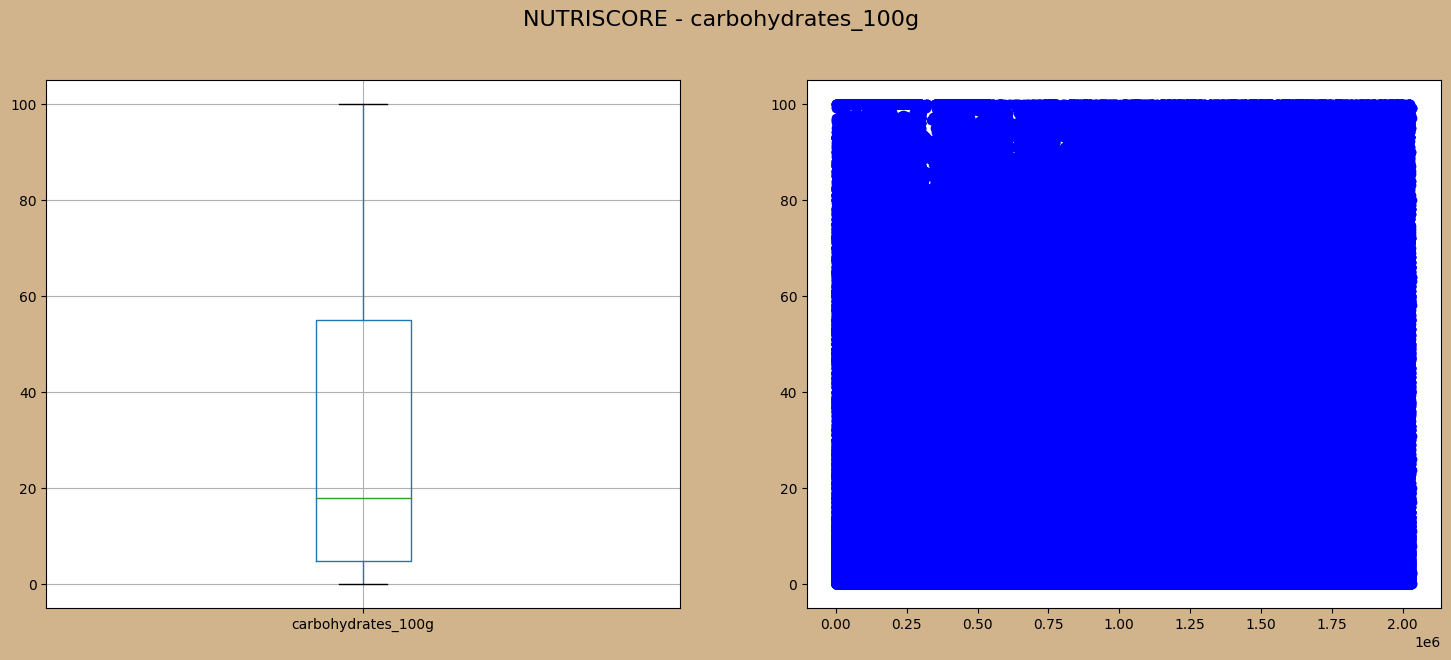

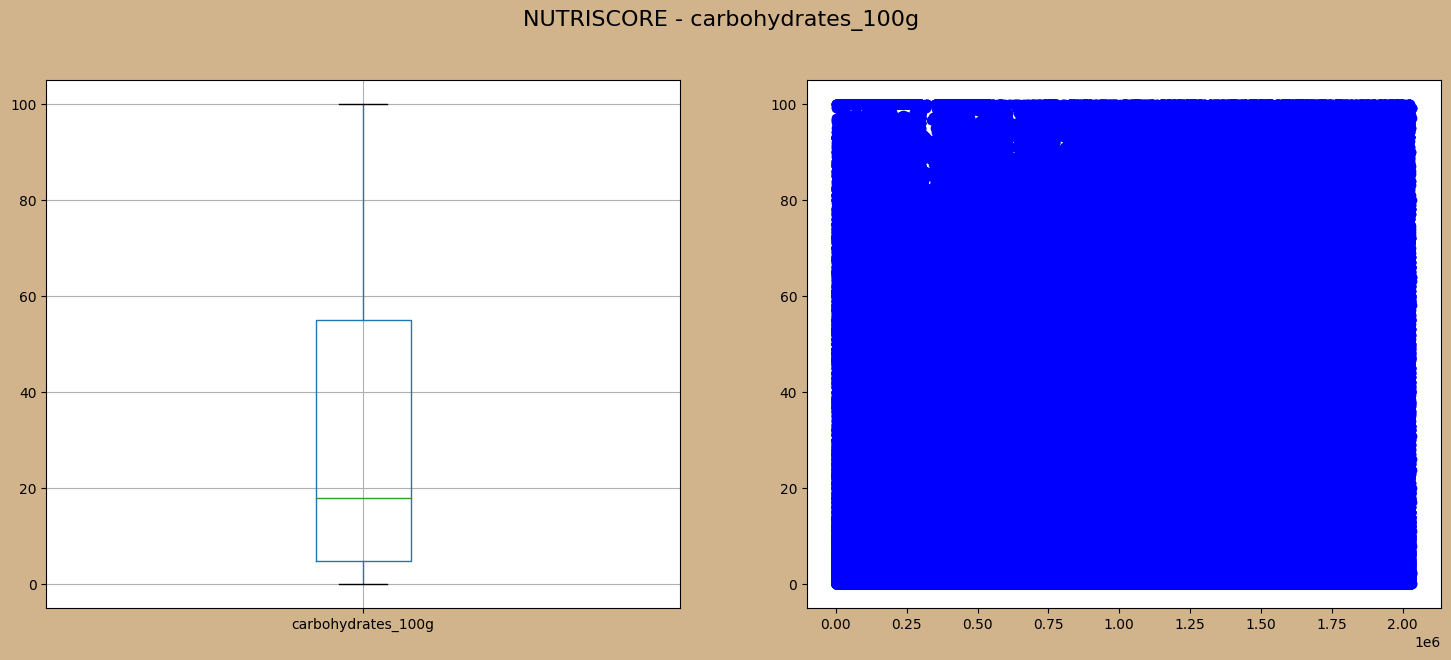

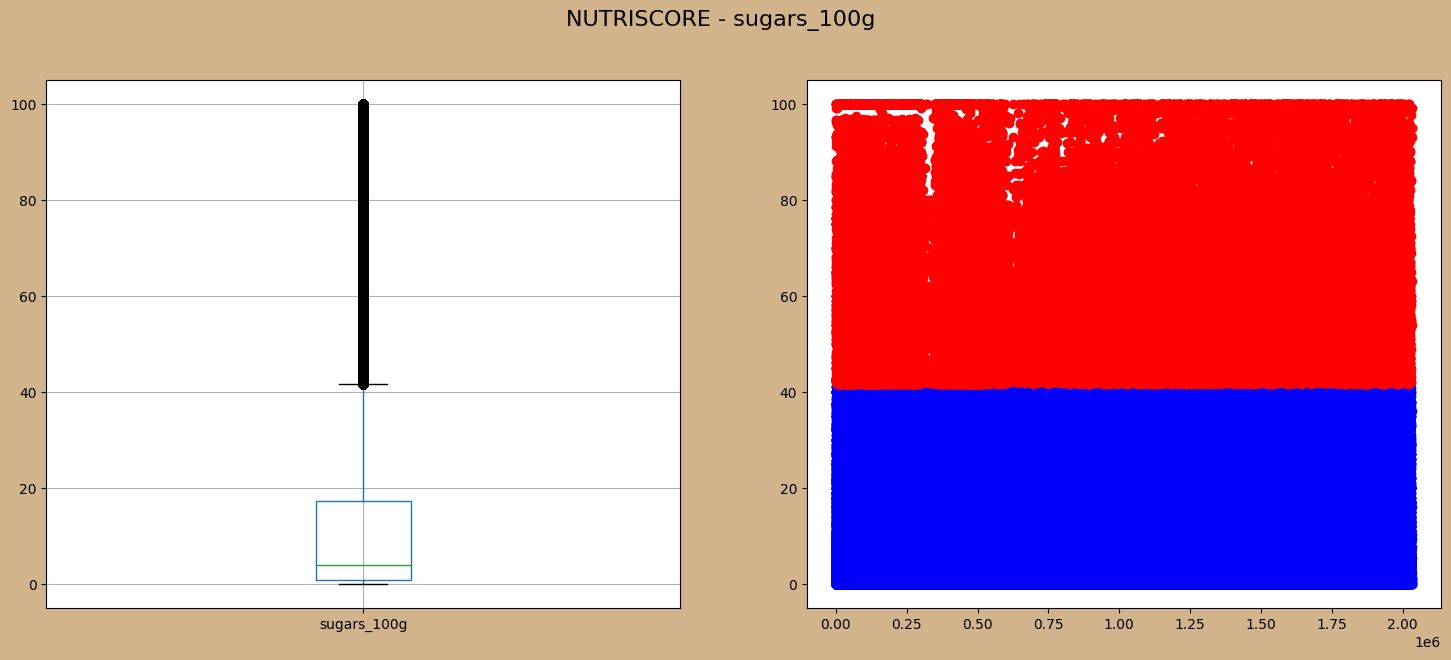

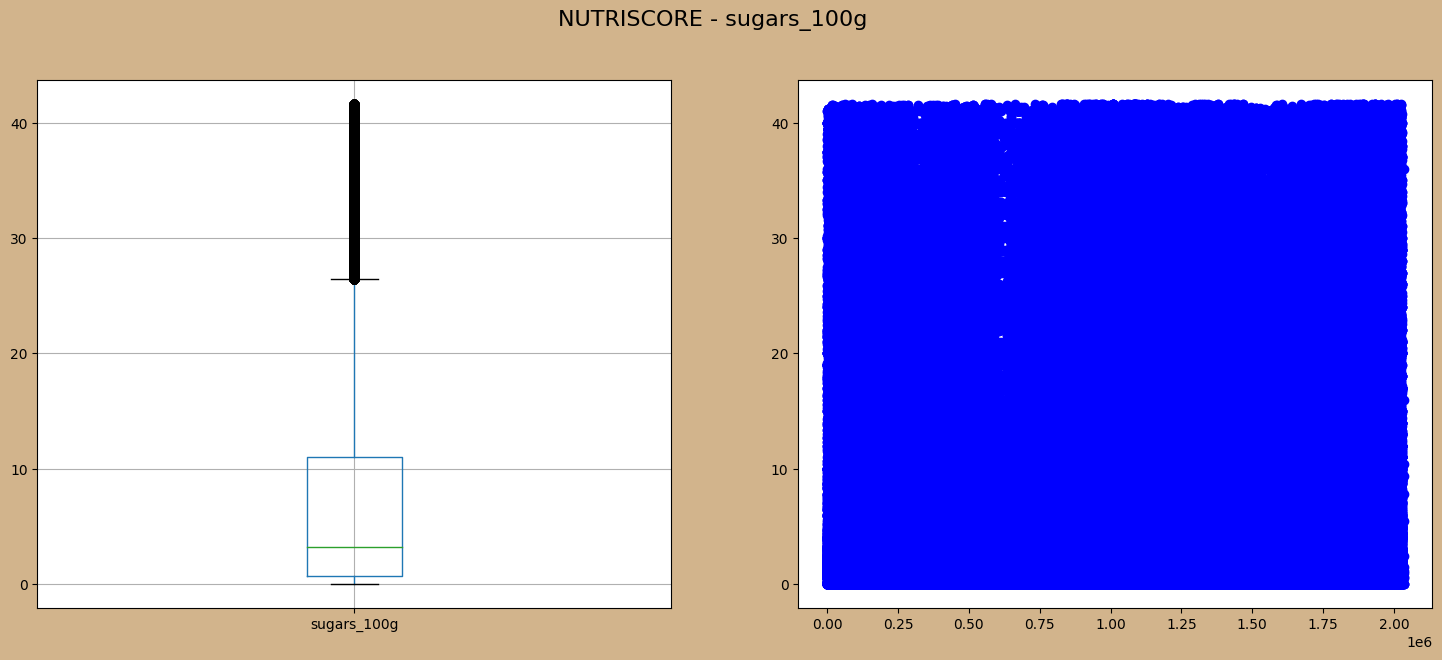

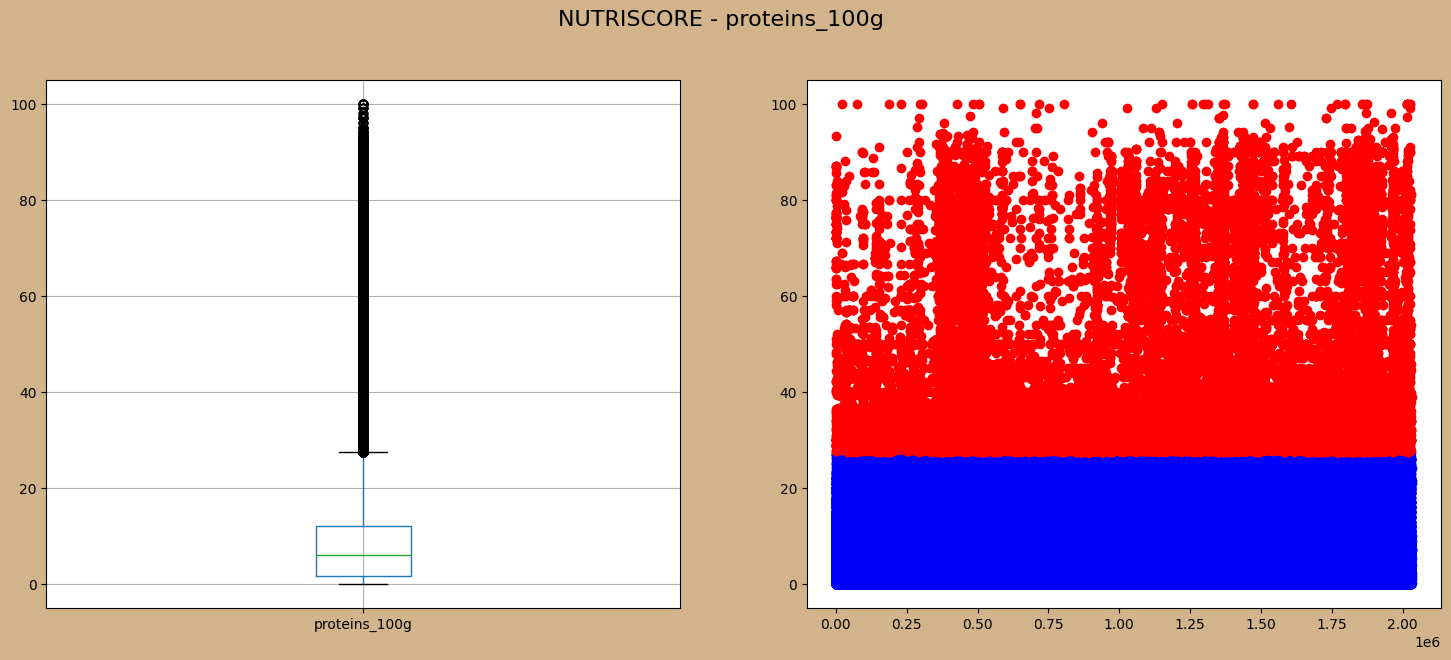

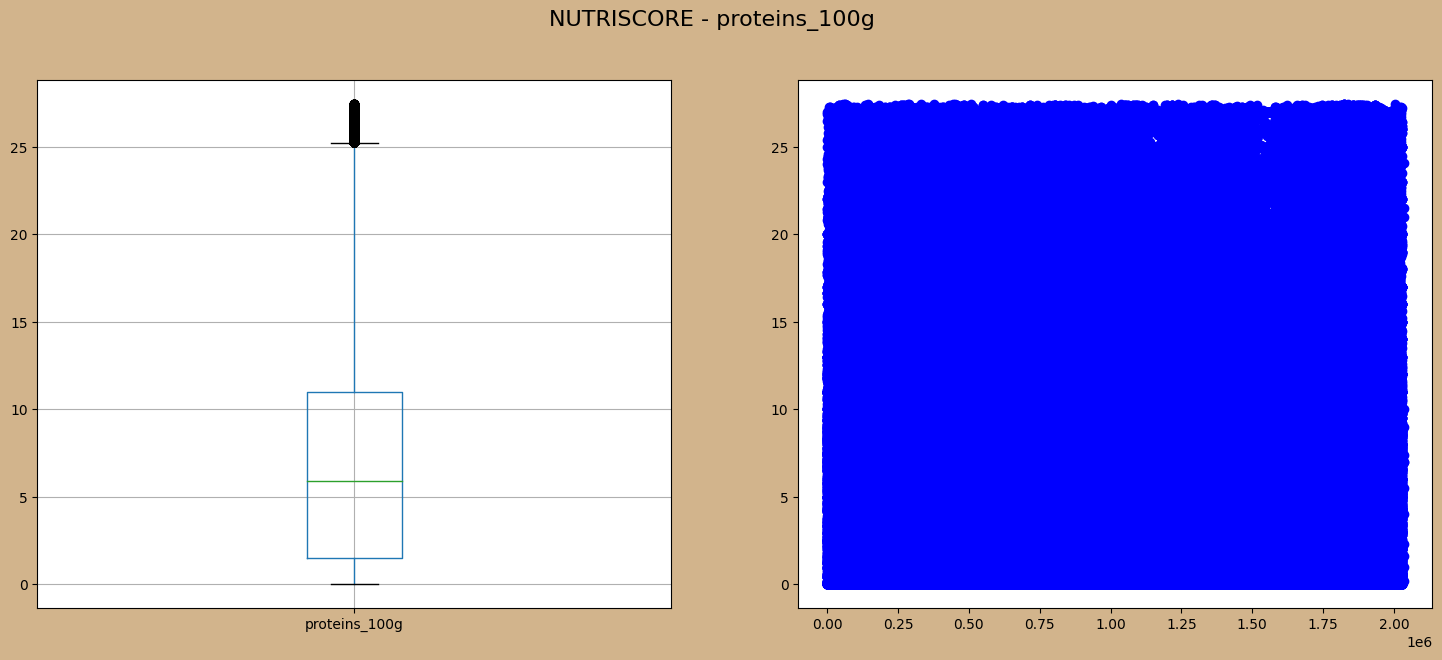

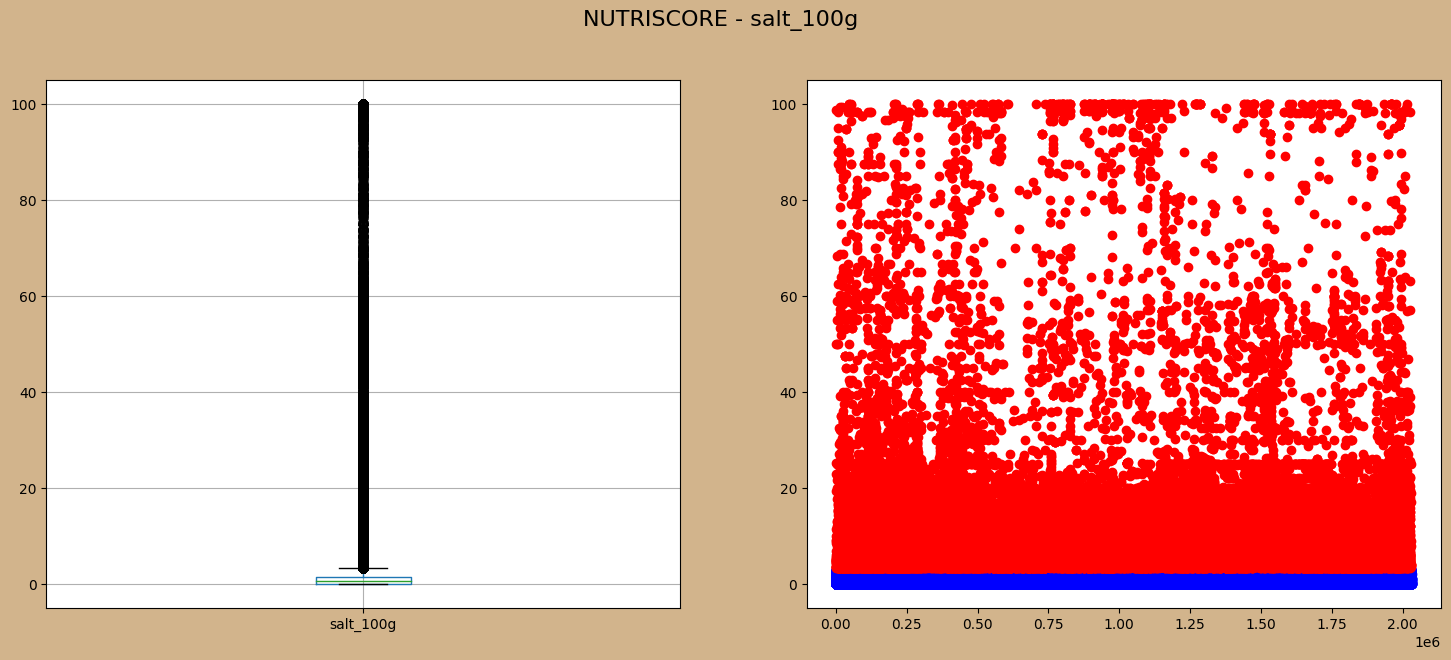

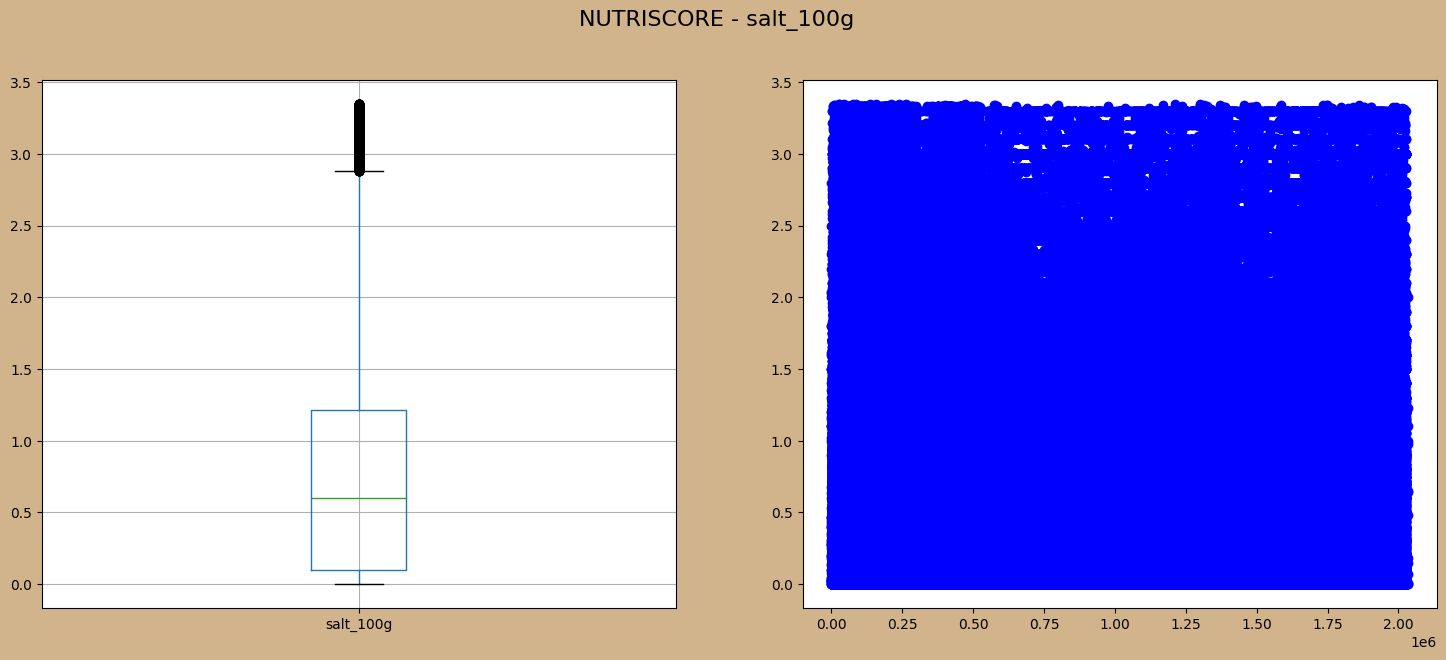

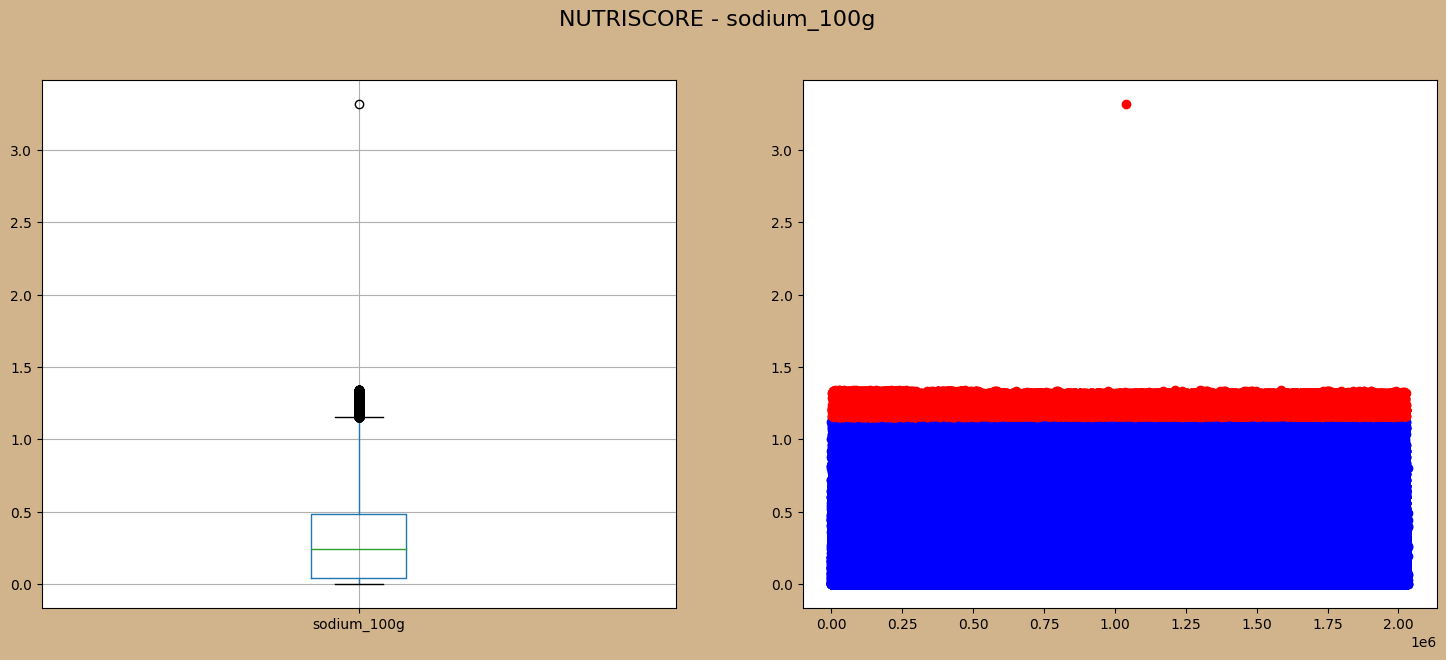

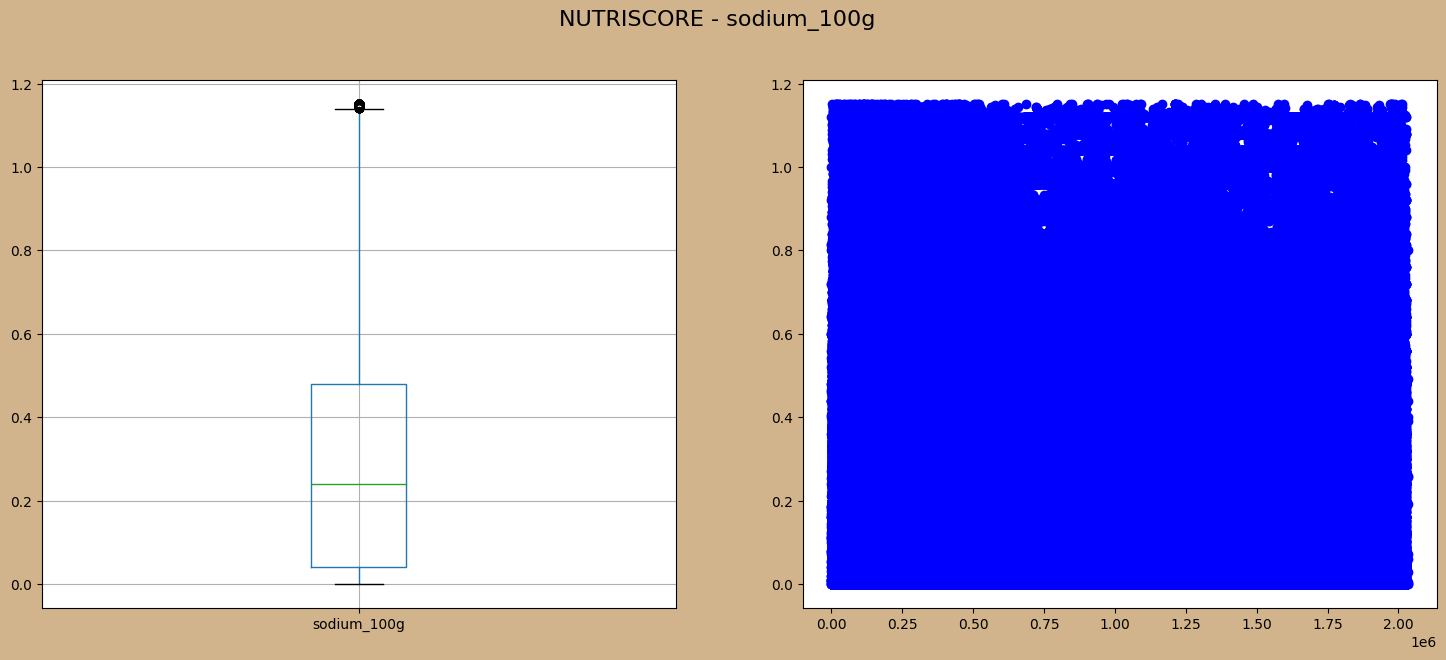

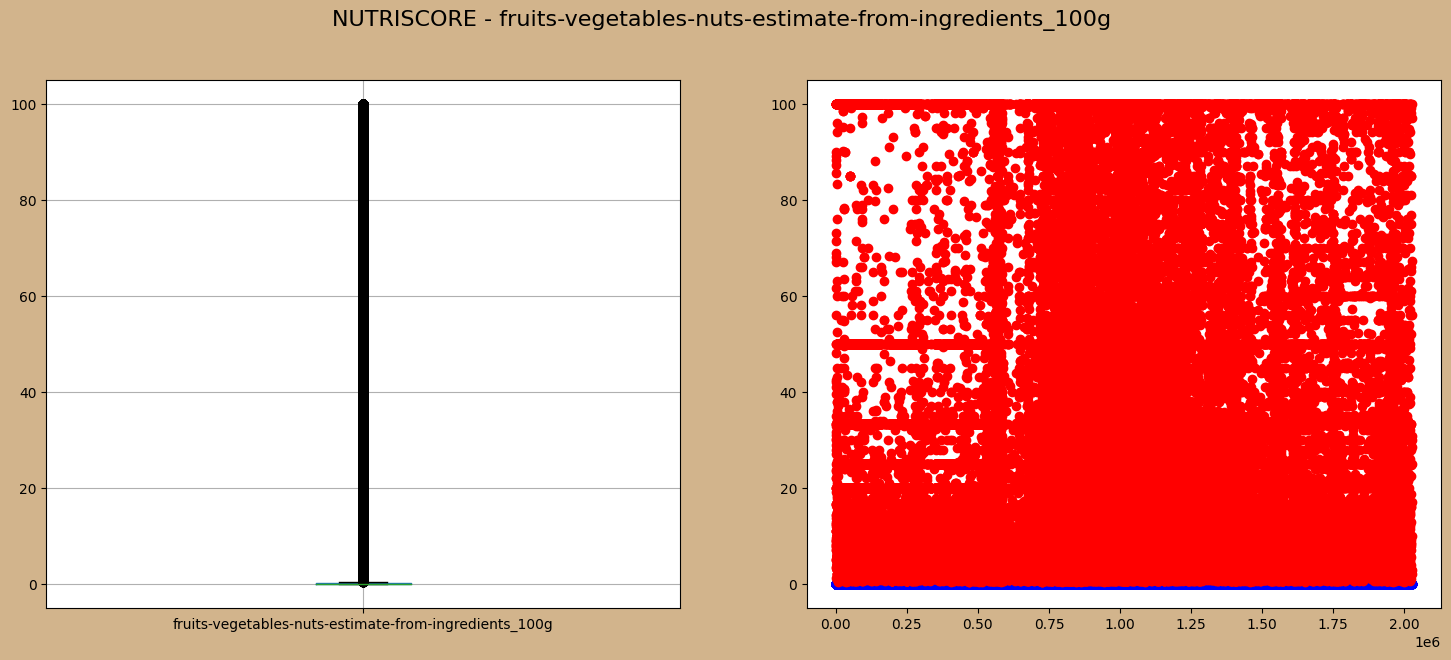

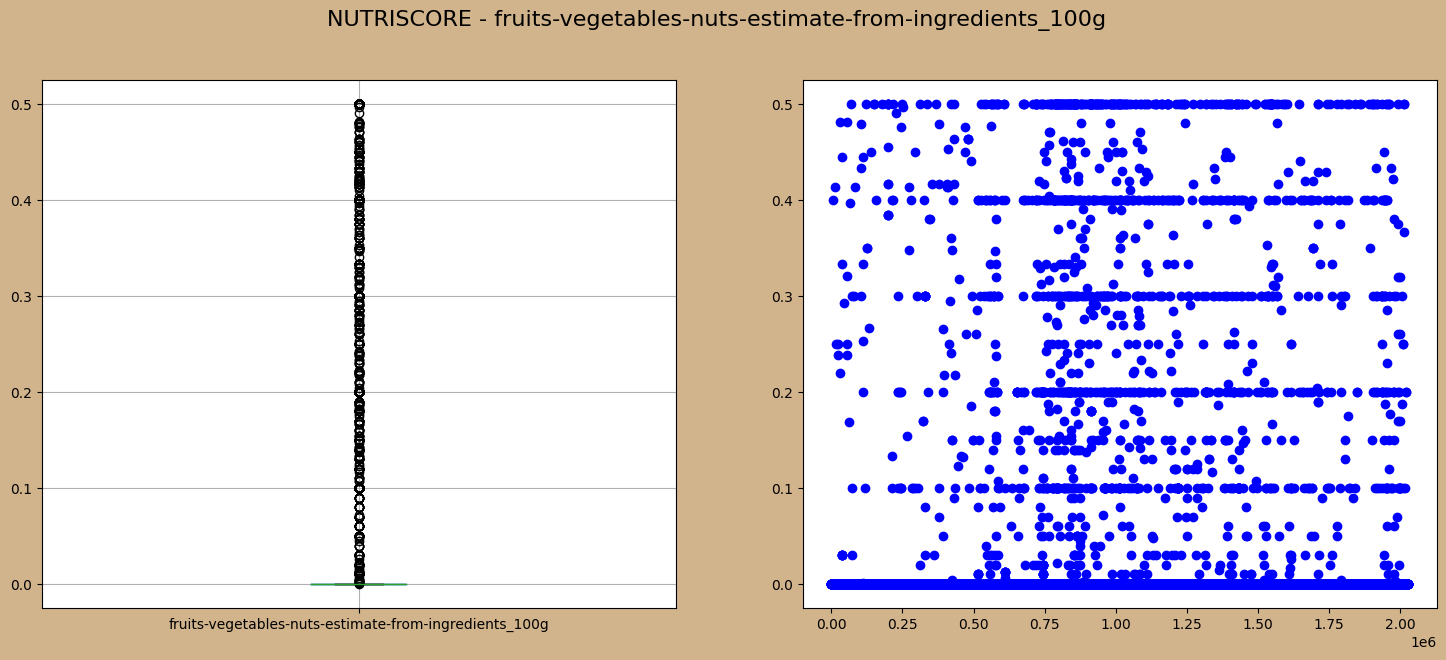

In [42]:
# on repart de la DF initiale
df_out = df.copy()
df_out = va_data.create_boxplot_by_data_before_and_after_outliers(df_out, remove=True, verbose=verbose)

In [43]:
df_out.shape

(244762, 33)

In [44]:
print("Origine:", df.shape, " après outlier :", df_out.shape, "soit:", df_out.shape[0]-df.shape[0])

Origine: (1419279, 33)  après outlier : (244762, 33) soit: -1174517


Suite à cette seconde stratégie, ça entraine une suppression vraiment drastique des données, nous sommes passés de 1 419 279 produits à 244 762, soit une perte de 1 174 517 produit, soit une perte de plus de 80% des données (il reste 17,24% des données).   
Suite à ce constat, nous nous sommes dit qu'il serait plus pertinent de calculer les outliers avant de modifier la DF, en effet au fil de la génération, le DataFrame est modifier et les outliers sont différents au fil des traitements.    
Donc nous allons calculer les outliers avant traitement, puis nous allons supprimer tous les outliers

## 2.3. Traitement des outliers par suppression des produits sur la base de la DF initiale

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~                                       Données AVANT traitement des outliers                                           ~
~ ['product_name', 'energy-kj_100g', 'energy-kcal_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g'] ~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


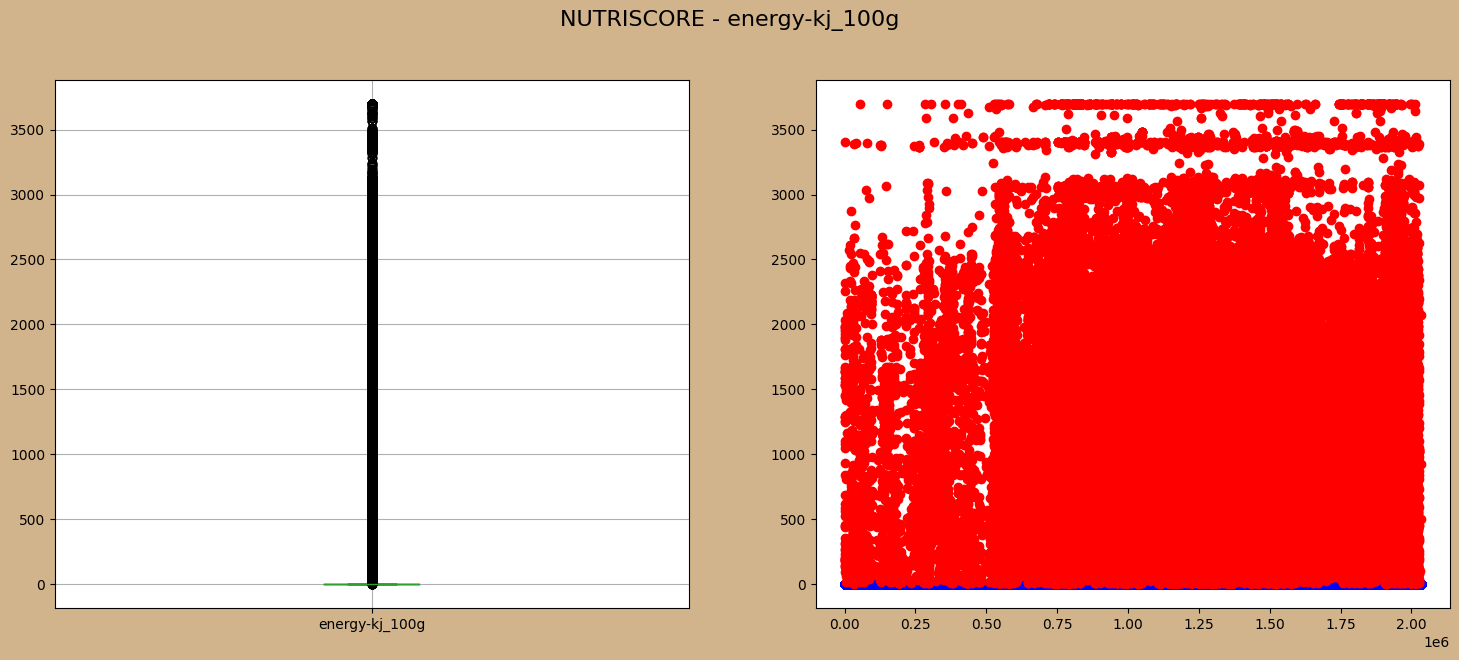

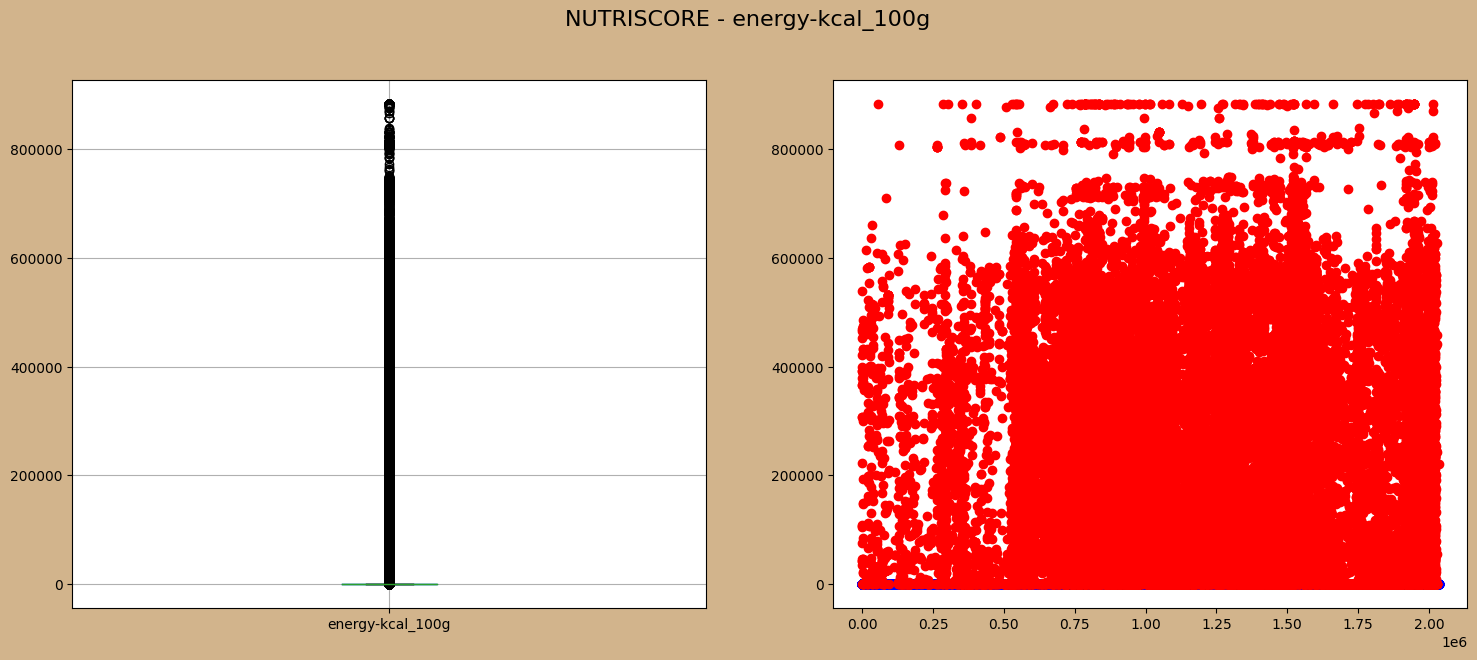

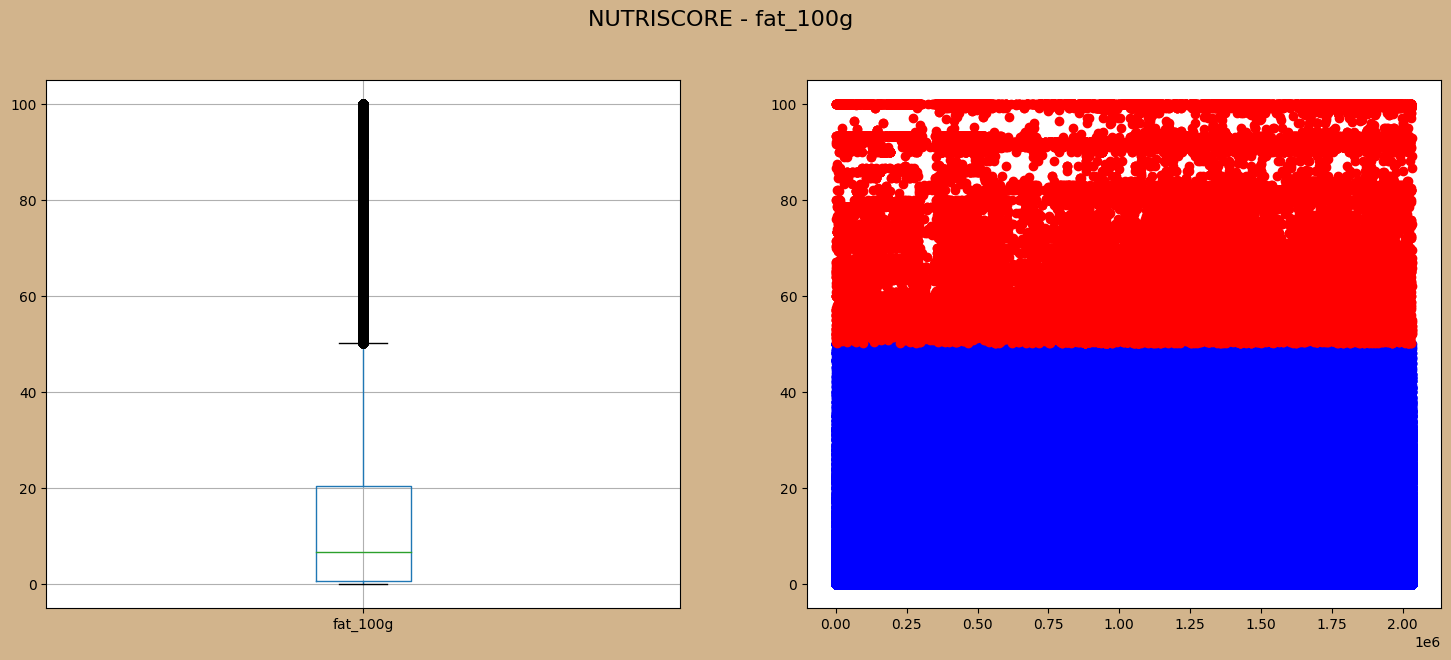

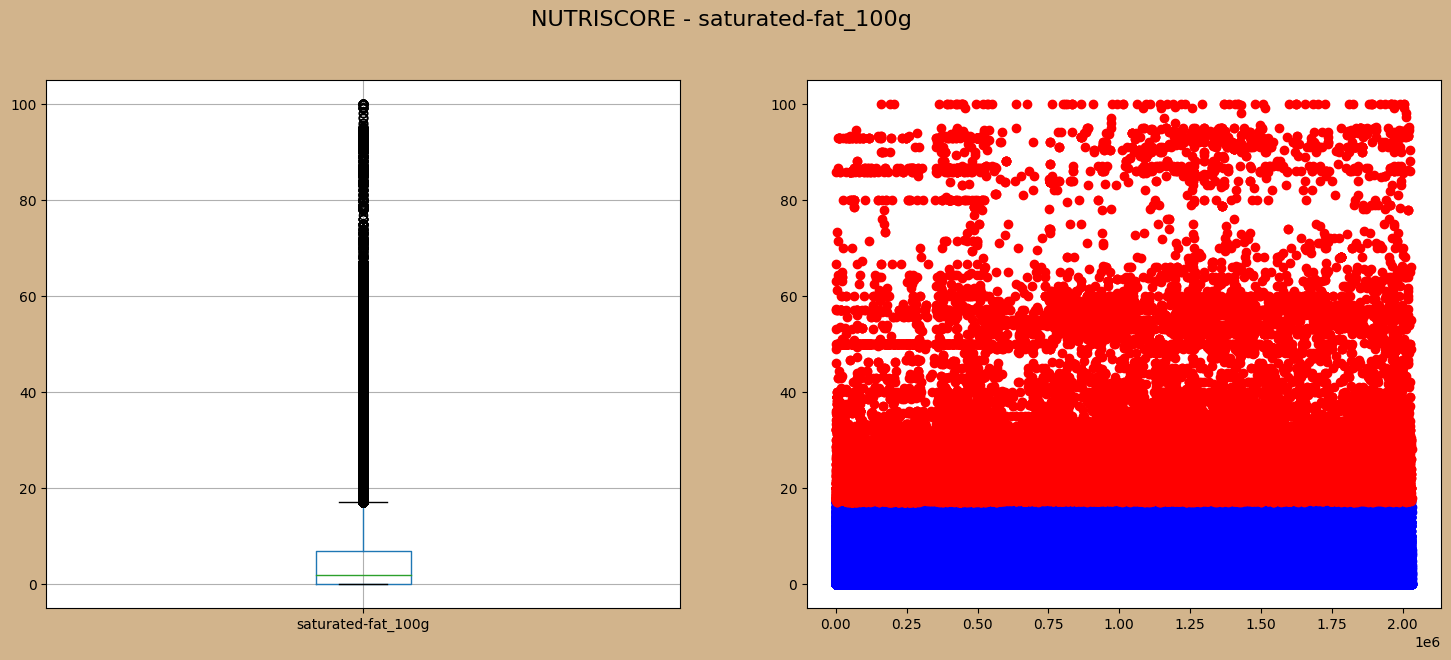

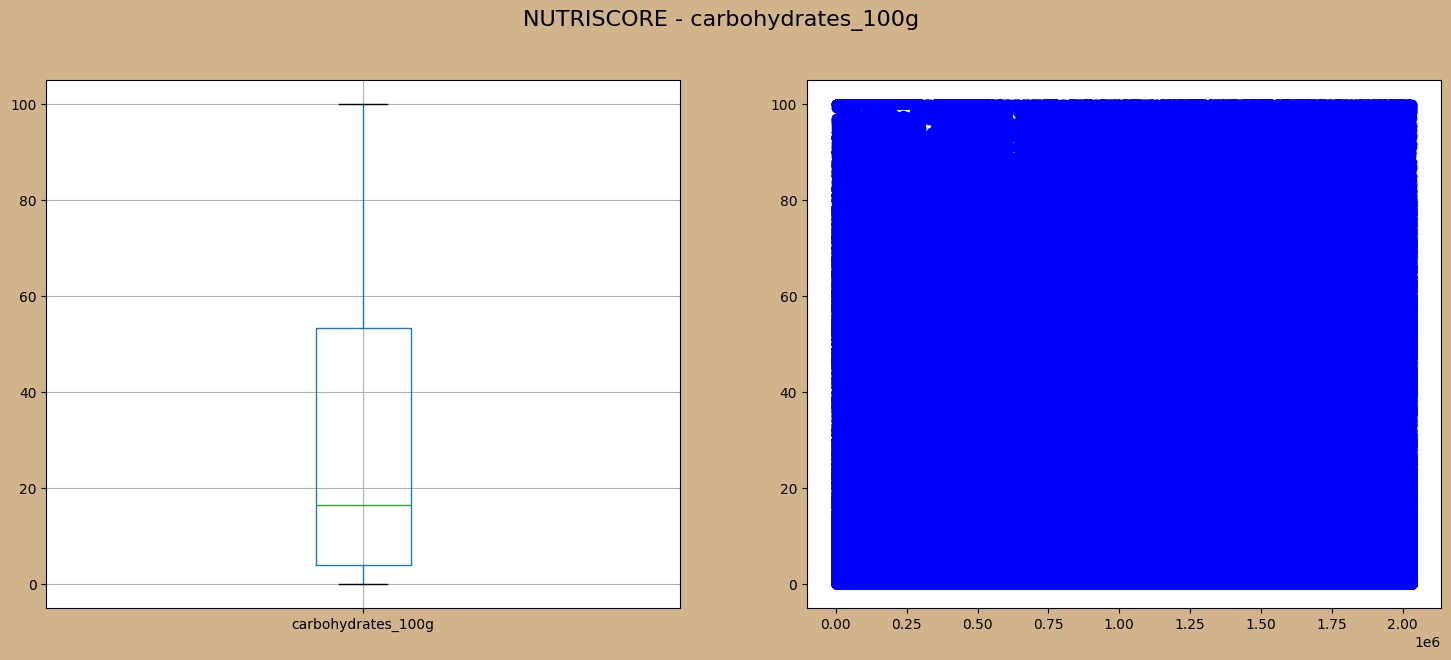

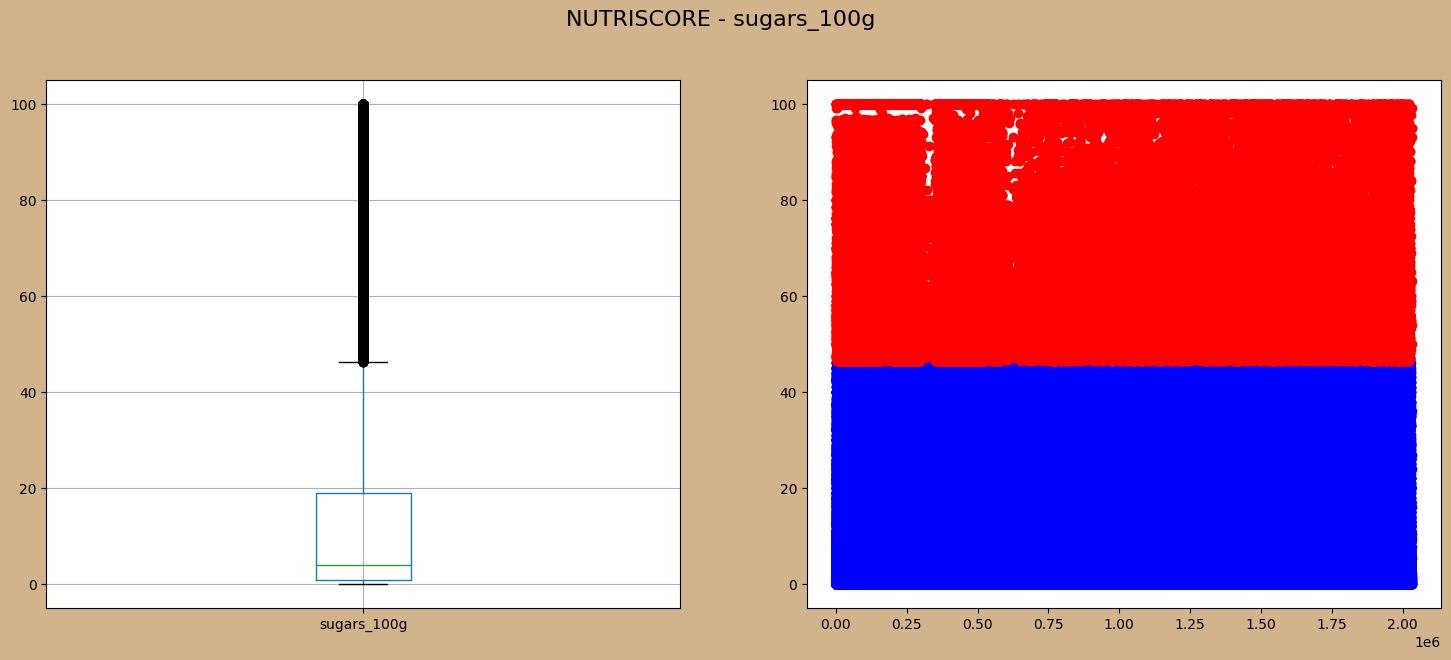

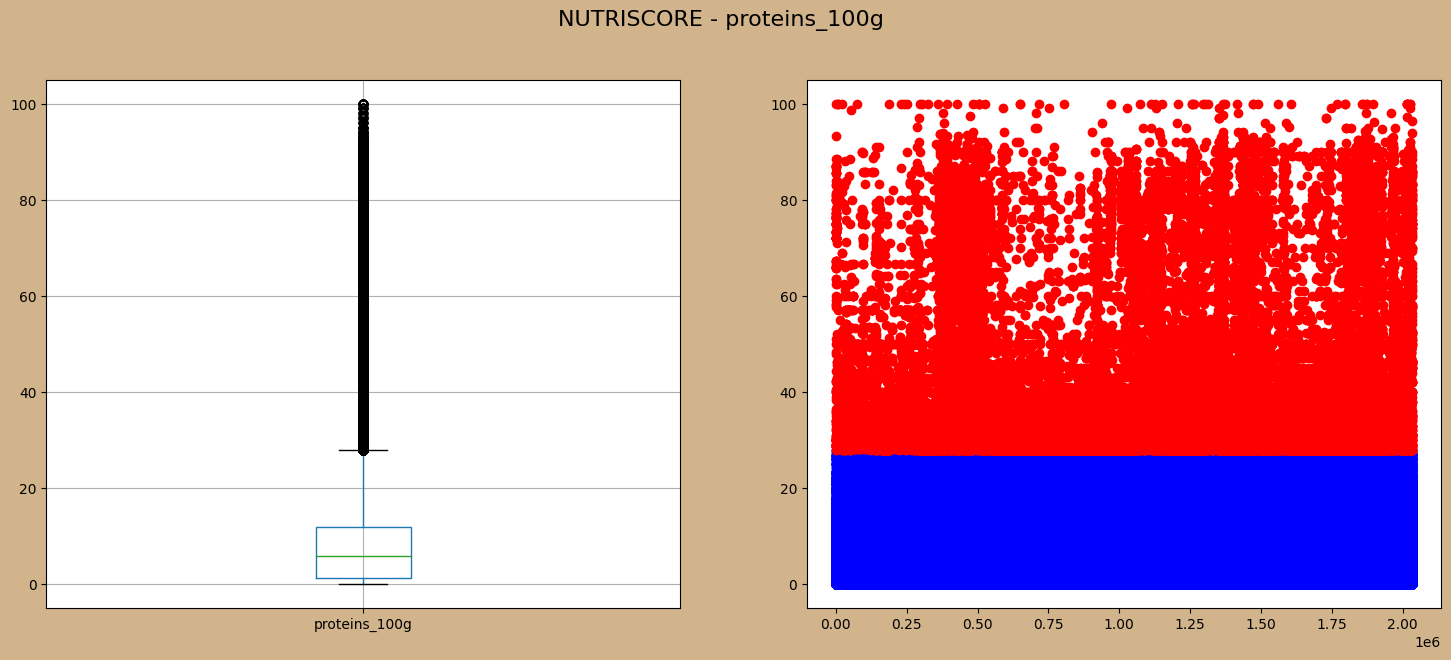

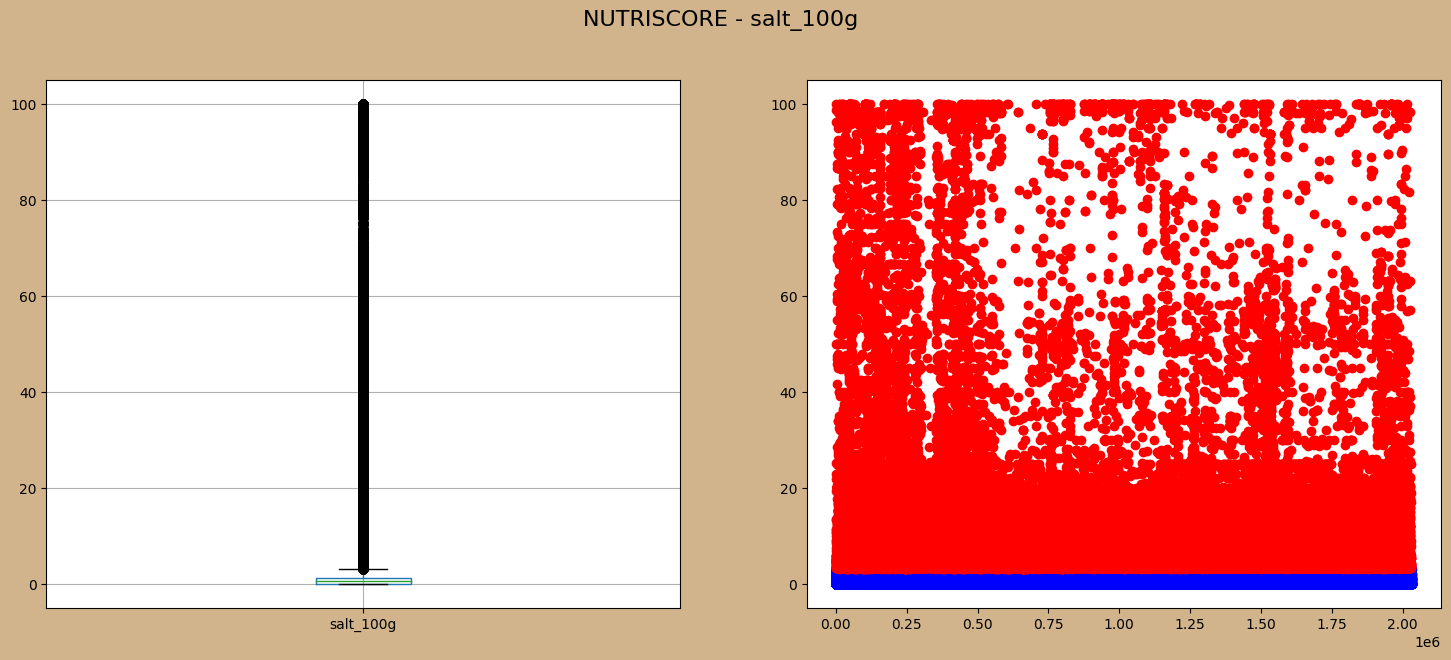

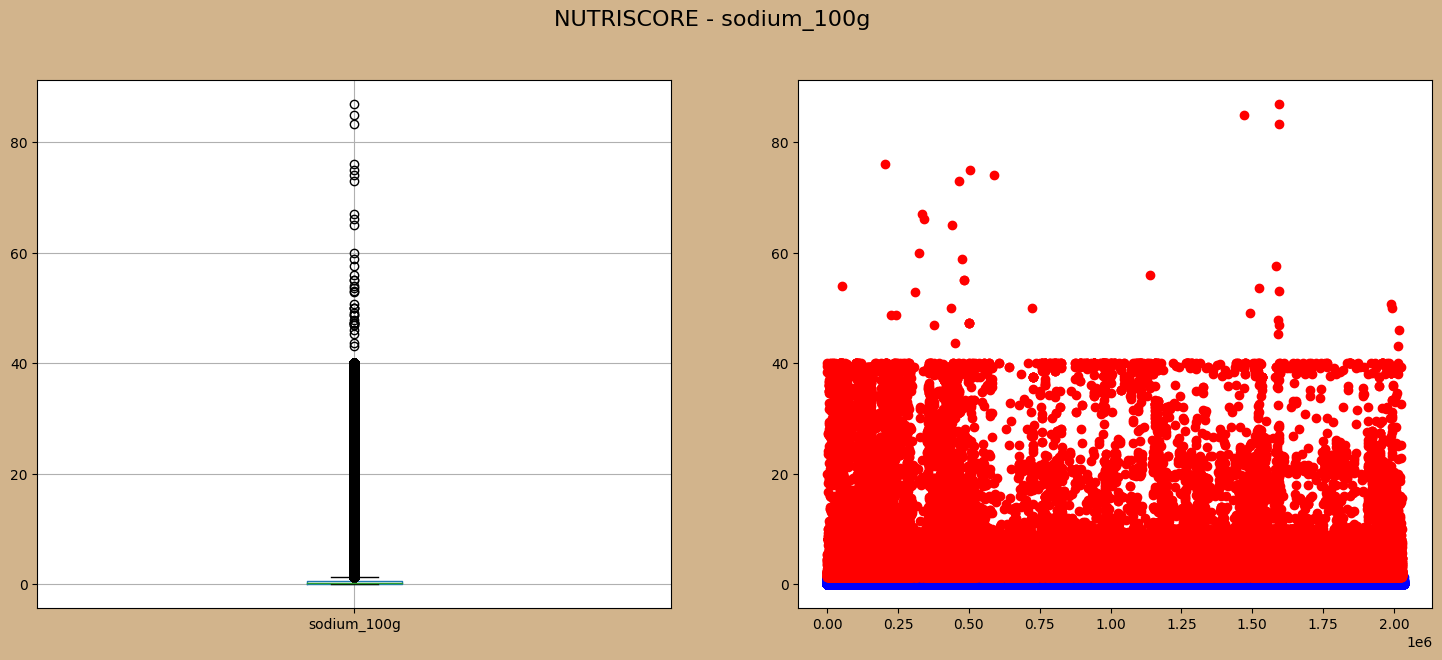

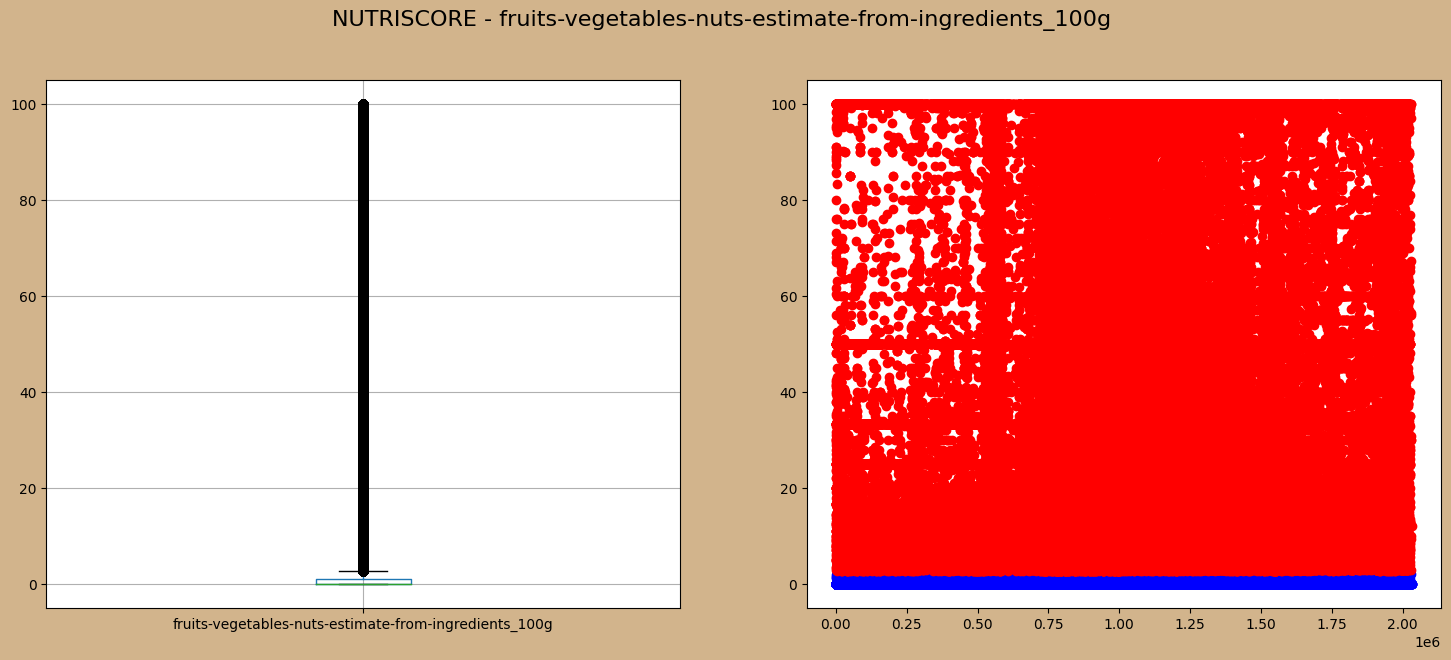

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~                                      Données APRES suppression des outliers                                           ~
~ ['product_name', 'energy-kj_100g', 'energy-kcal_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g'] ~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


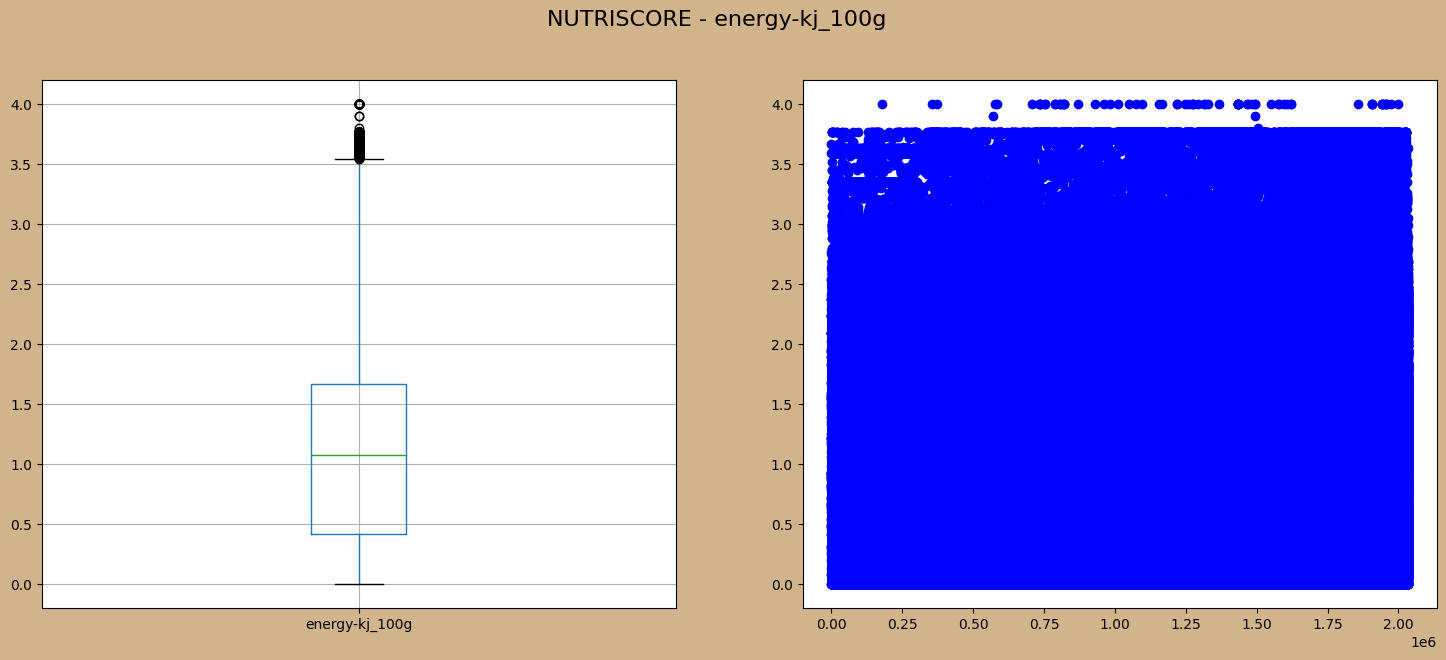

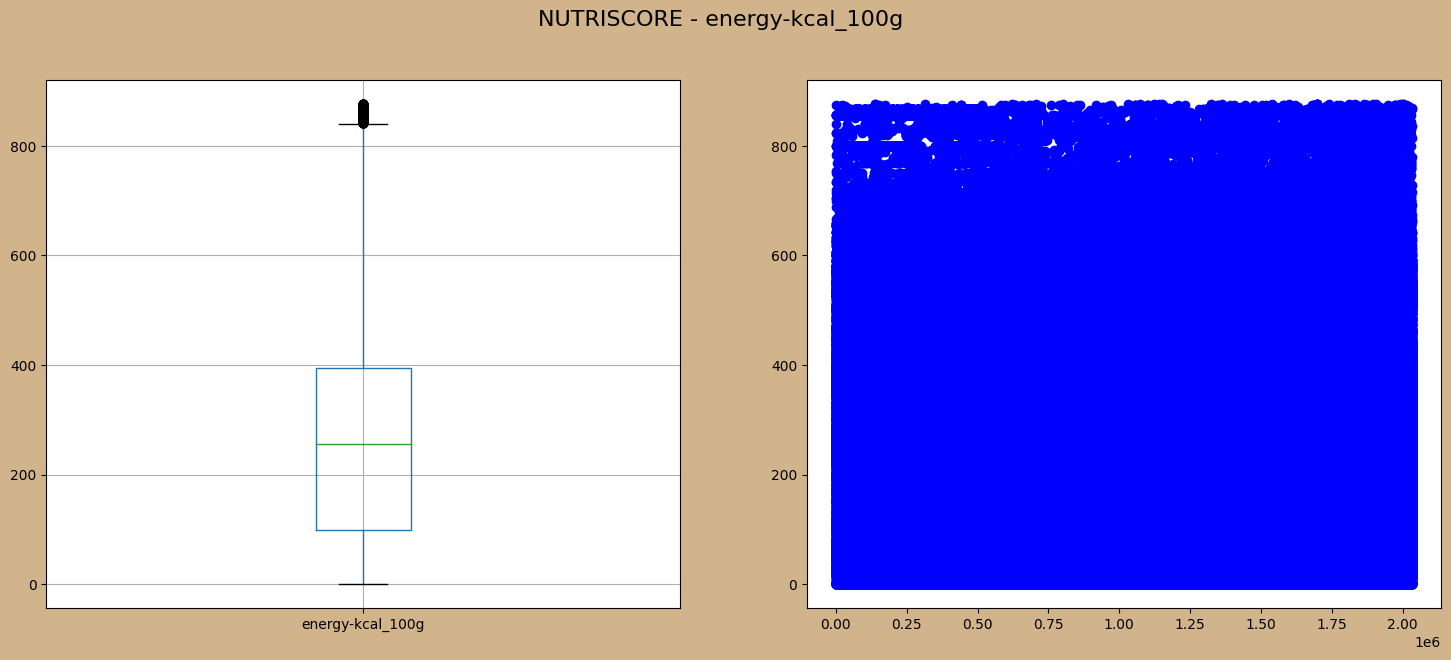

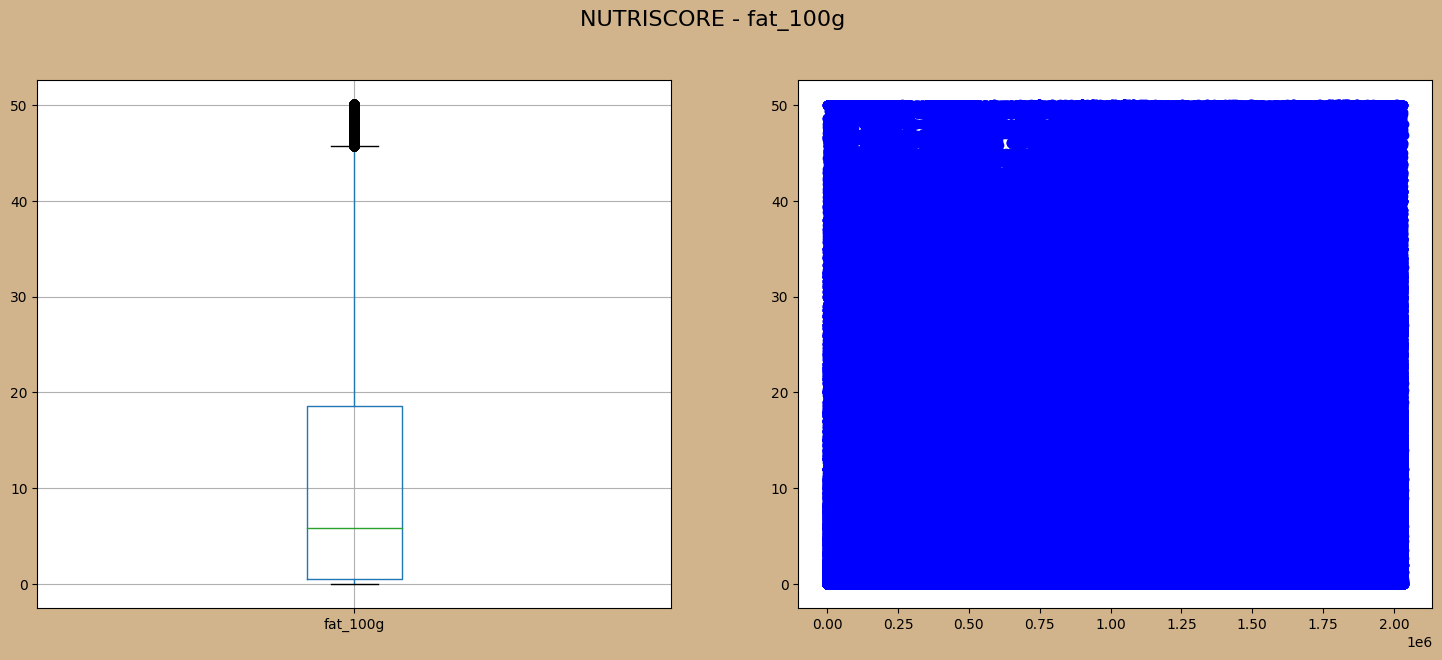

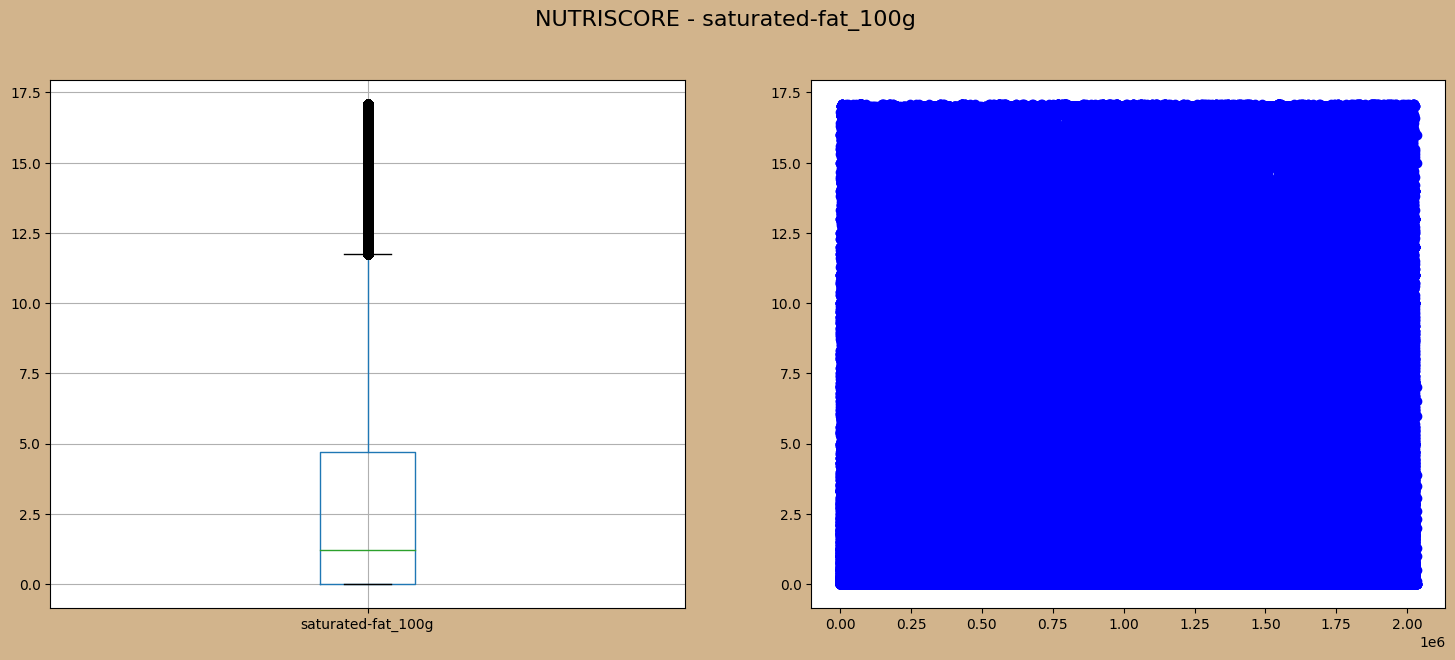

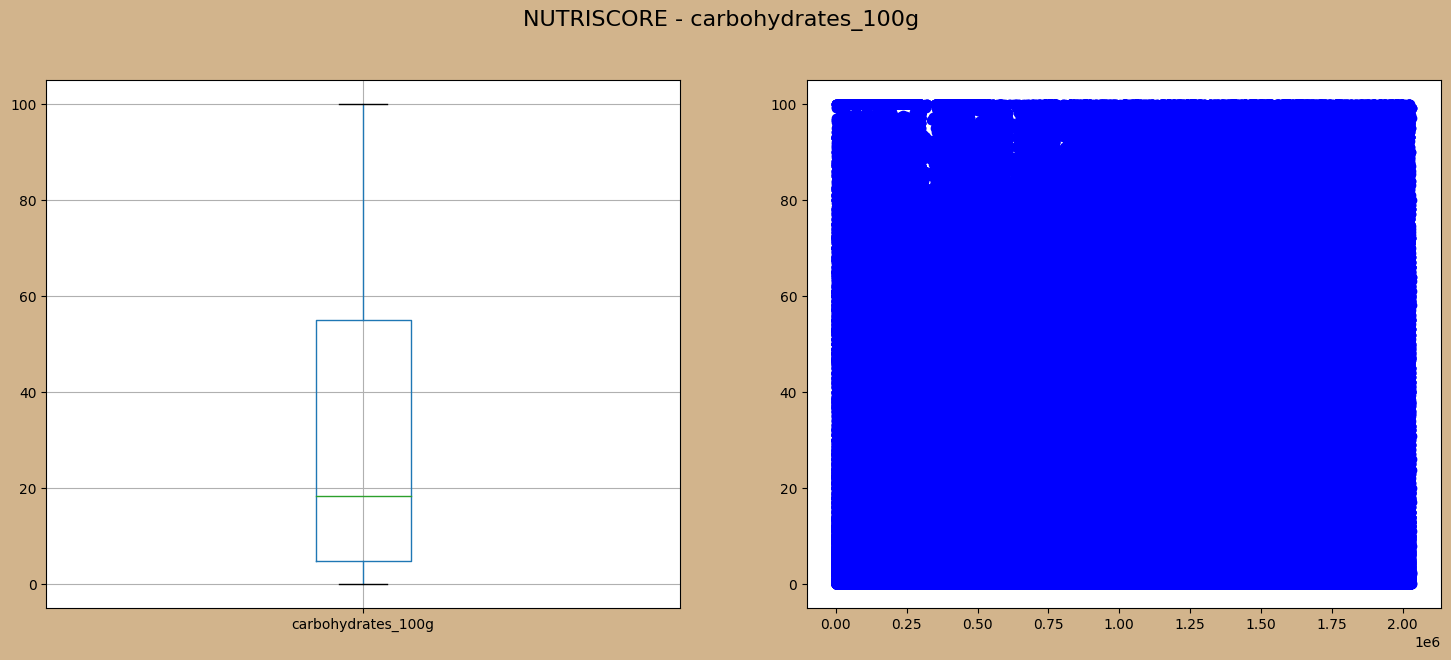

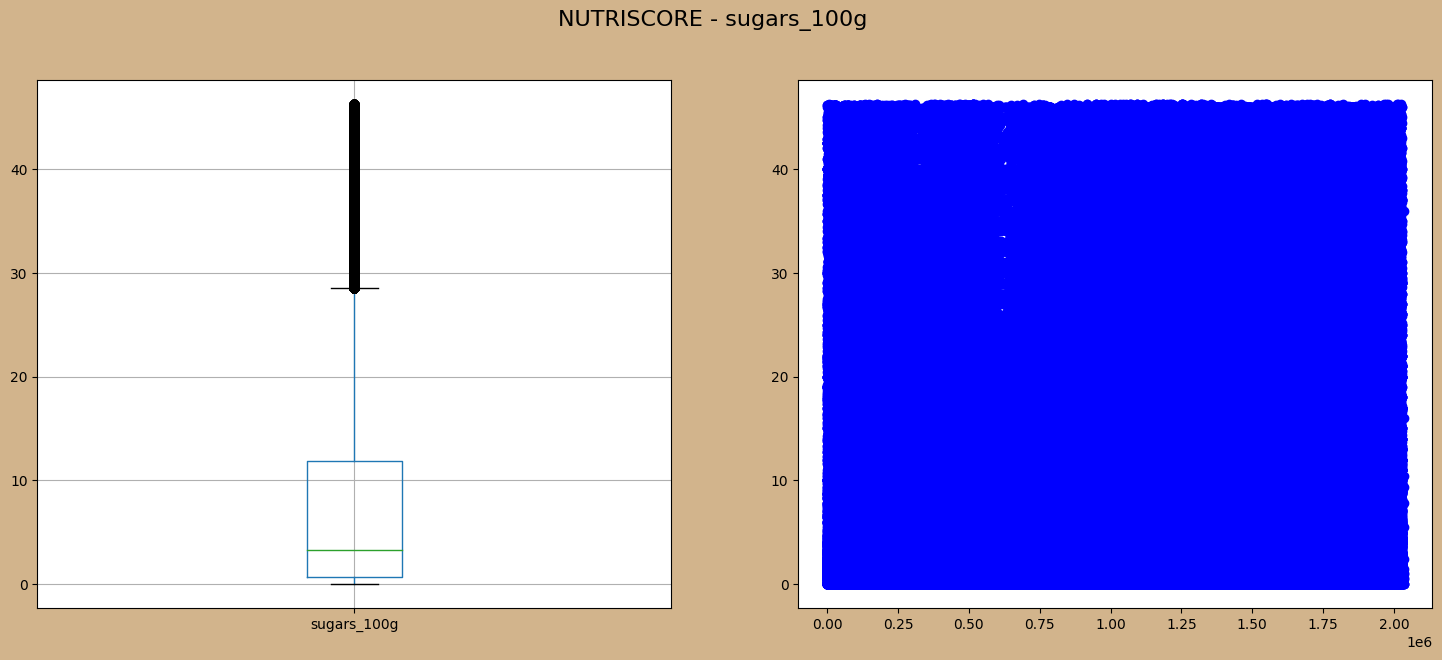

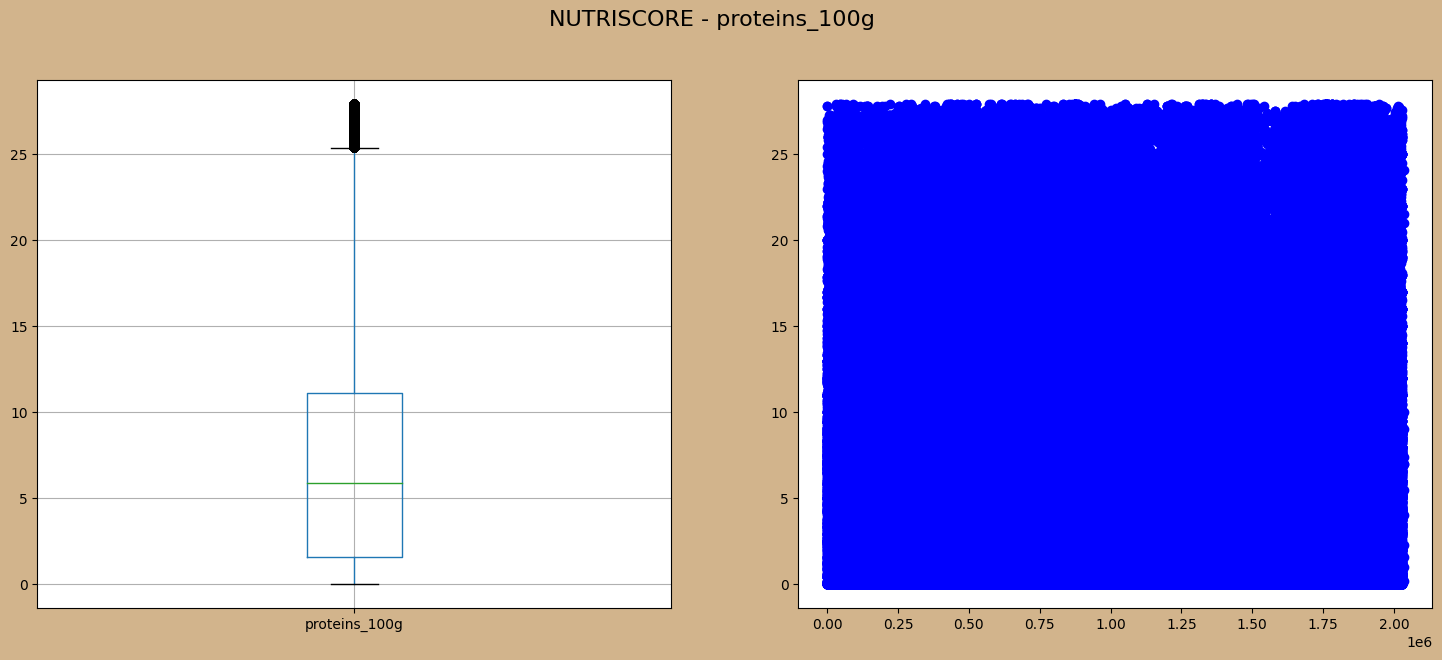

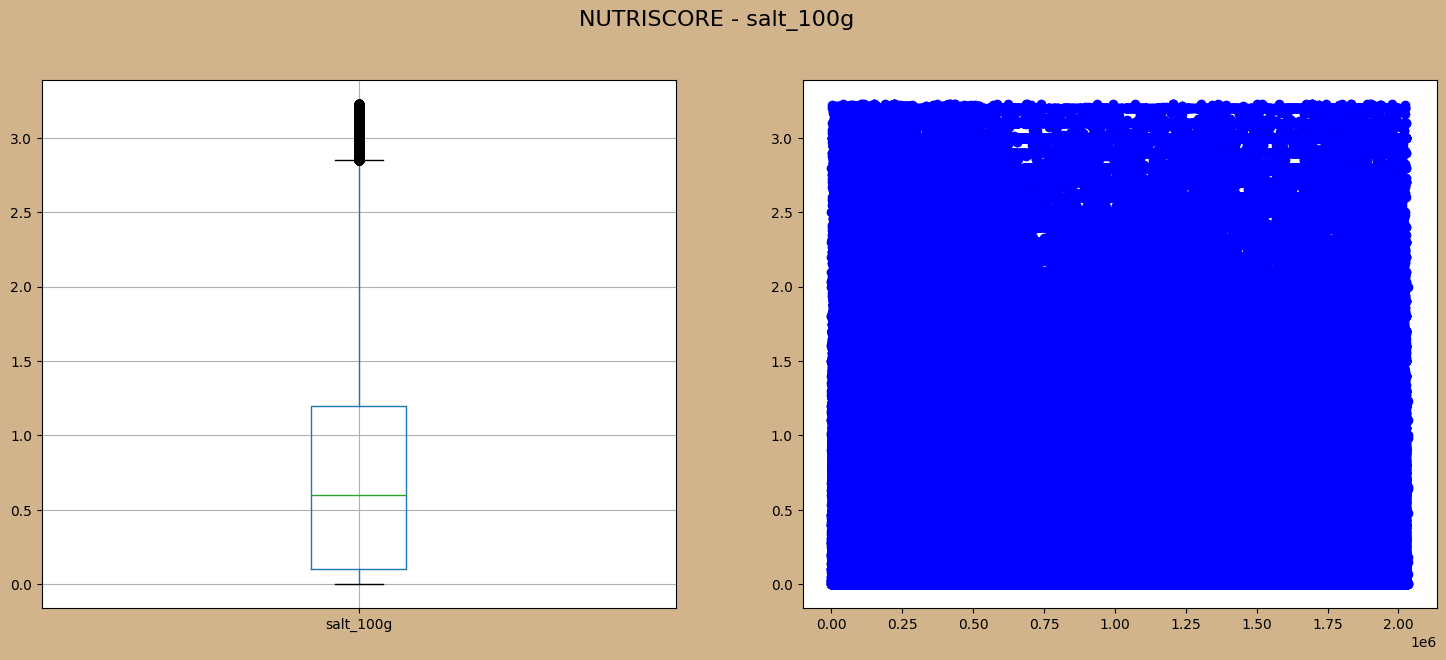

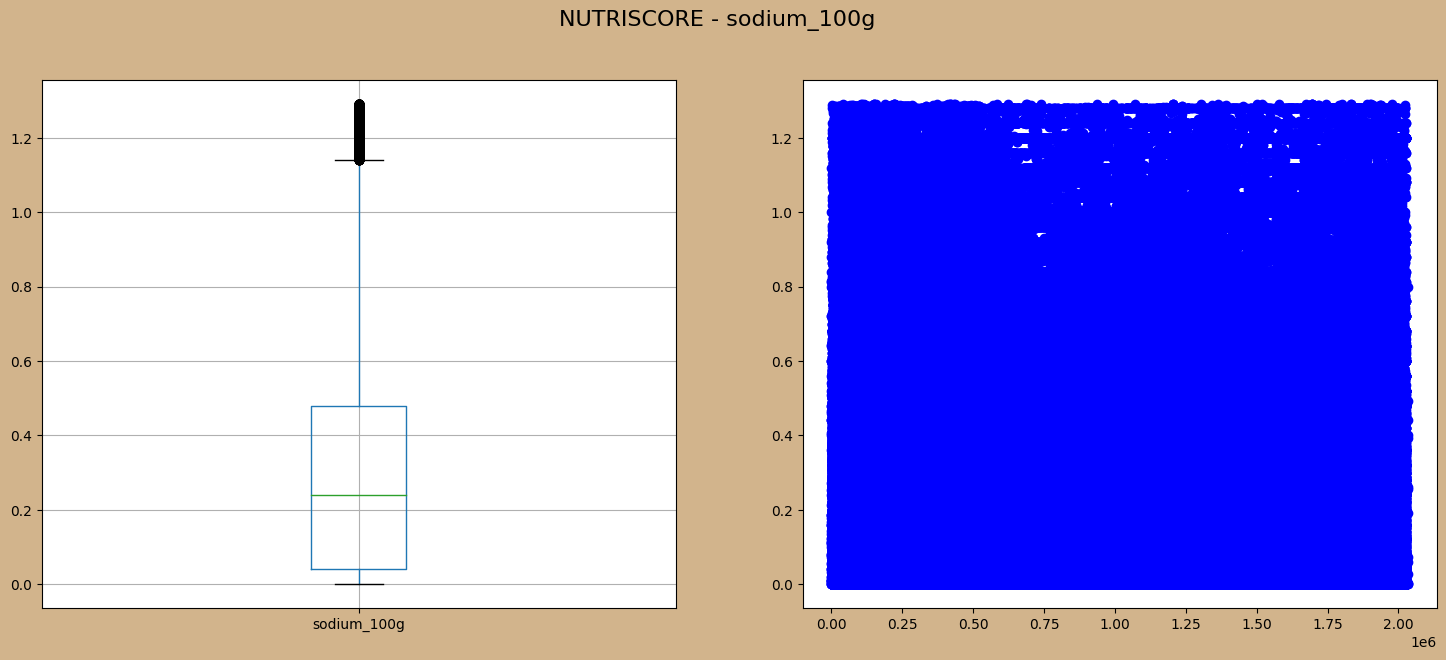

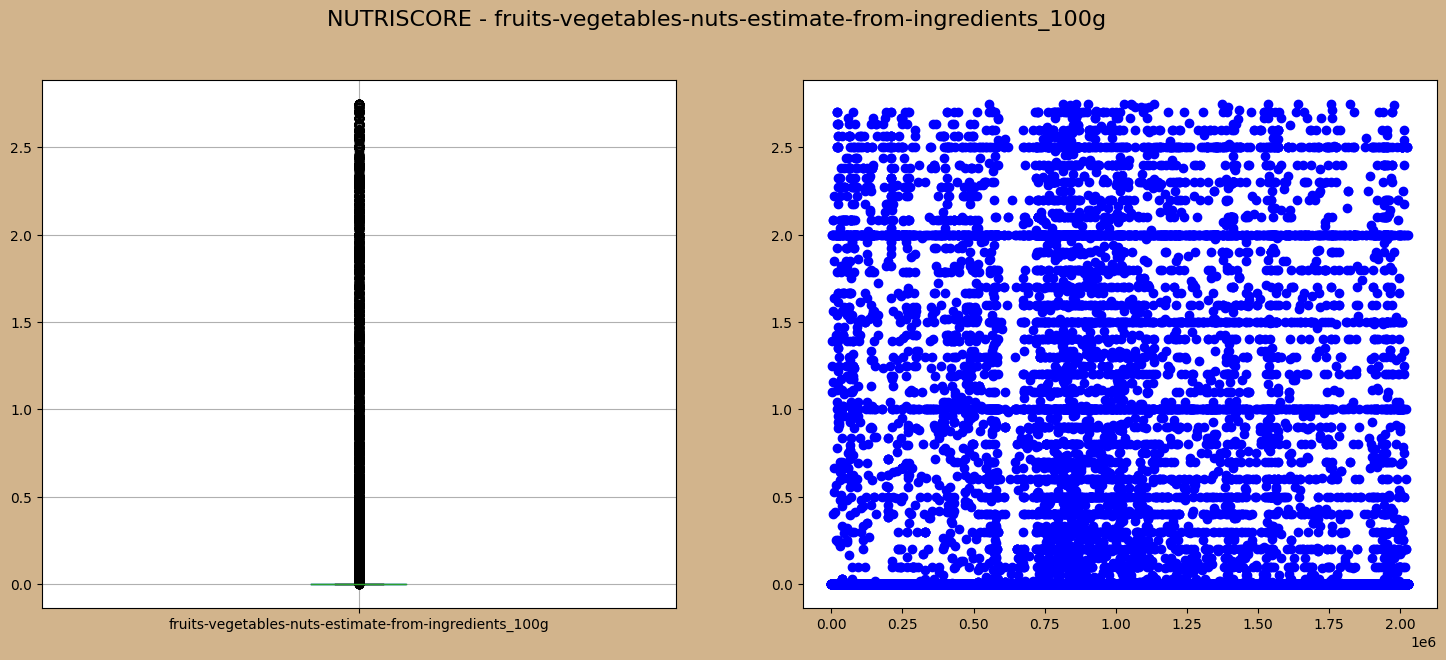

In [45]:
# on repart de la DF initiale
df_out = df.copy()
df_out = va_data.create_boxplot_by_data_with_outliers_then_without_outliers(df_out, remove=True, verbose=verbose)

In [46]:
print("Origine:", df.shape, " après outlier :", df_out.shape, "soit:", df_out.shape[0]-df.shape[0])

Origine: (1419279, 33)  après outlier : (266232, 33) soit: -1153047


Entre les deux méthodes, on réduit la suppresion de 21 470 produits (qui sont conservés)
Nous gardons donc cette méthode pour nos analyses, à savoir :
* calcul des outliers pour chaque colonne concernée sur la base de la DF générale initiale
* représentation des graphes avant traitement
* suppression outliers sur la base de la DF initiale
* représentation des graphes APRES traitement (suppression)

In [47]:
# Vérifier les colonnes qui manquent plus ou moins de données
df_out.isna().mean().sort_values(ascending=False)

pnns_groups_2                                            0.320882
pnns_groups_1                                            0.320882
brands_tags                                              0.283373
brands                                                   0.283362
nutrition-score-fr_100g                                  0.173890
nutriscore_grade                                         0.173890
nutriscore_score                                         0.173890
pnns_groups                                              0.150328
main_category_en                                         0.150328
categories_en                                            0.150328
countries_tags                                           0.001341
countries_en                                             0.001341
ingredients_that_may_be_from_palm_oil_n                  0.000060
additives_n                                              0.000060
ingredients_from_palm_oil_n                              0.000060
ingredient

In [48]:
df_out.shape

(266232, 33)

On applique à nouveau la règle sur la suppression des lignes avec les NA

In [49]:
# On applique à nouveau la règle sur la suppression des lignes avec les NA
# ---------------------------------------------------------------------------------------------
# NETTOYAGE DES DONNEES
df_out = va_pre.clean_df_na(df_out, verbose, remove_added_col=True)
# Vérifier les colonnes qui manquent plus ou moins de données
df_out.isna().mean().sort_values(ascending=False)

Add NB_NAN_0 Column(266232, 34) ---------- DONE
Remove duplicated 'code': (266232, 34) NA 581_470 > 581_470 (0) ---------- DONE
Remove lines nutrigrade == NAN and NUTRI < 8 /11 ['energy-kj_100g', 'energy-kcal_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g', 'additives_n'] NA 581_470 > 581_470 (0) ---------- DONE
duplicated on other columns  False    266232
dtype: int64: (266232, 35) NA 581_470 > 581_470 (0) ---------- DONE
Remove na 'product_name': (266232, 35) NA 581_470 > 581_470 (0) ---------- DONE
Clean pmms group
clean_pms_group_na NA 85_429 > 40_022 (45_407) in 0.00 minutes...................................... END
Clean pmms group (266232, 35) ---------- DONE
Complete energy datascomplete_kcal_from_kj_values NA 0 > 0 (0) in 0.00 minutes...................................... END
complete_kj_from_kcal_values NA 0 > 0 (0) in 0.00 minutes...................................... END
: (

pnns_groups_2                                            0.320882
pnns_groups_1                                            0.320882
brands_tags                                              0.283373
brands                                                   0.283362
nutrition-score-fr_100g                                  0.173890
nutriscore_grade                                         0.173890
nutriscore_score                                         0.173890
pnns_groups                                              0.150328
main_category_en                                         0.150328
categories_en                                            0.150328
countries_tags                                           0.001341
countries_en                                             0.001341
ingredients_that_may_be_from_palm_oil_n                  0.000060
additives_n                                              0.000060
ingredients_from_palm_oil_n                              0.000060
ingredient

In [50]:
df_out.shape

(266232, 33)

## 1.4 Remplacement des NA par la moyenne

In [51]:
df_na = df_out.copy()
# On remplace les NA par la valeur moyenne de la cette catégorie
# Récupérer la liste des colonnes nutriments
print("Replace na nutriment by mean by pnns")
nut_list = va_pre.get_nutriments_columns_names(df_na, verbose)
# Pas d'affectation de la moyenne sur nutrition-score-fr_100g
nut_list.remove("nutrition-score-fr_100g")
df_na = va_pre.replace_na_nutri_by_mean_by_pnns(df_na, nut_list, verbose=verbose)
print("Replace na nutriment by mean by pnns", df_na.shape, "---------- DONE")

Replace na nutriment by mean by pnns
replace_na_nutri_by_mean_by_pnns NA 581_470 > 581_456 (-14) in 0.01 minutes...................................... END
Replace na nutriment by mean by pnns (266232, 33) ---------- DONE


In [52]:
df_na.isna().mean().sort_values(ascending=False)

pnns_groups_2                                            0.320882
pnns_groups_1                                            0.320882
brands_tags                                              0.283373
brands                                                   0.283362
nutriscore_grade                                         0.173890
nutrition-score-fr_100g                                  0.173890
nutriscore_score                                         0.173890
pnns_groups                                              0.150328
main_category_en                                         0.150328
categories_en                                            0.150328
countries_tags                                           0.001341
countries_en                                             0.001341
ingredients_text                                         0.000060
ingredients_from_palm_oil_n                              0.000060
ingredients_that_may_be_from_palm_oil_n                  0.000060
additives_

<AxesSubplot:>

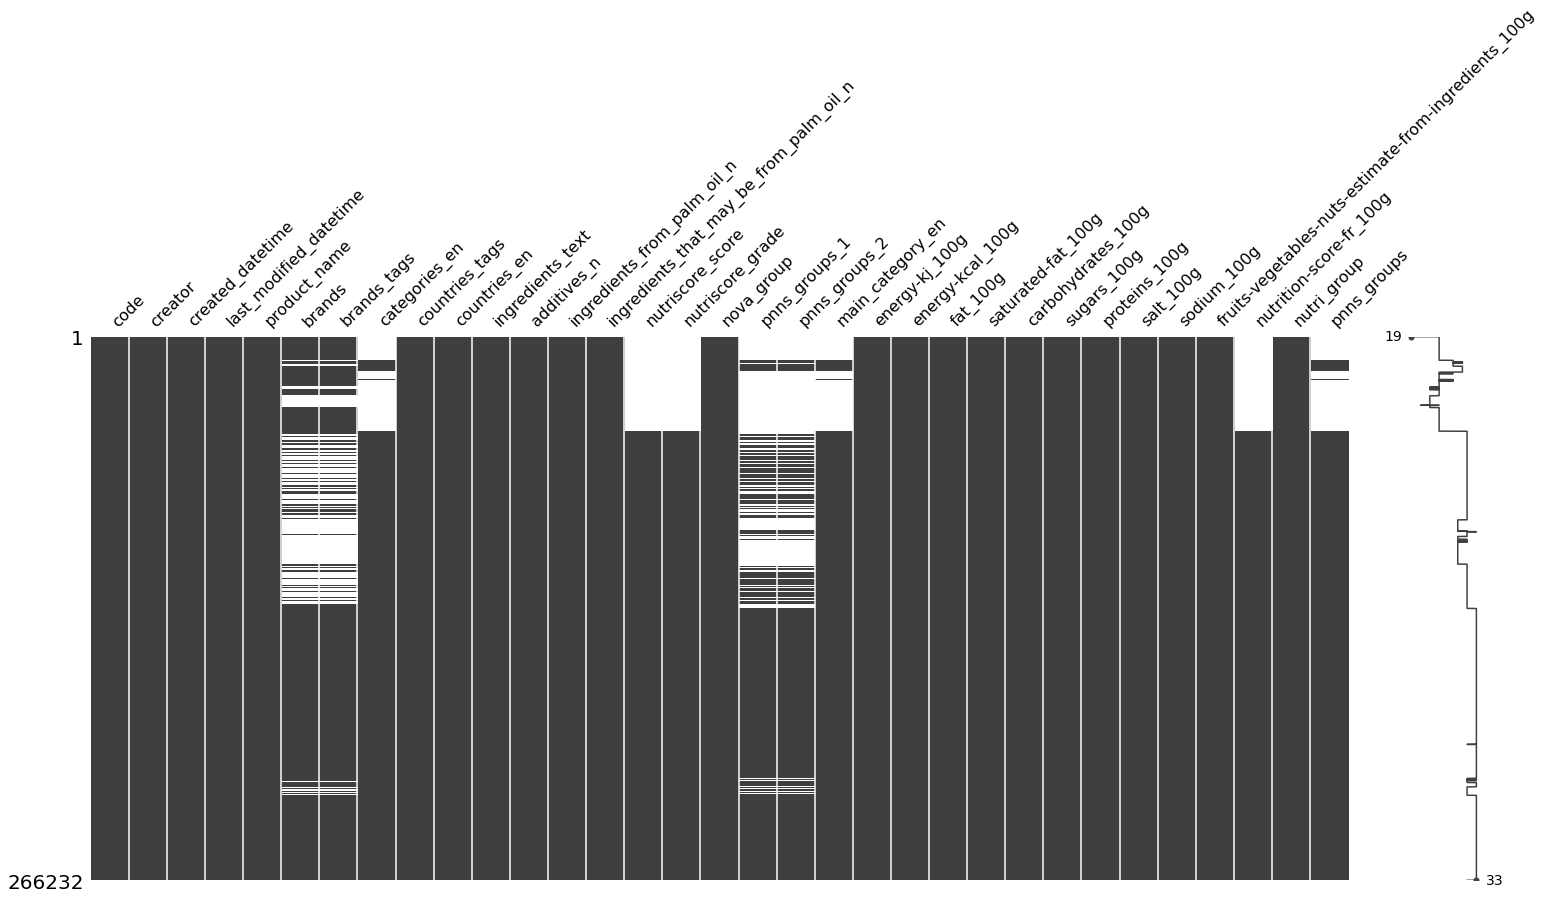

In [53]:
msno.matrix(df_na)

<AxesSubplot:>

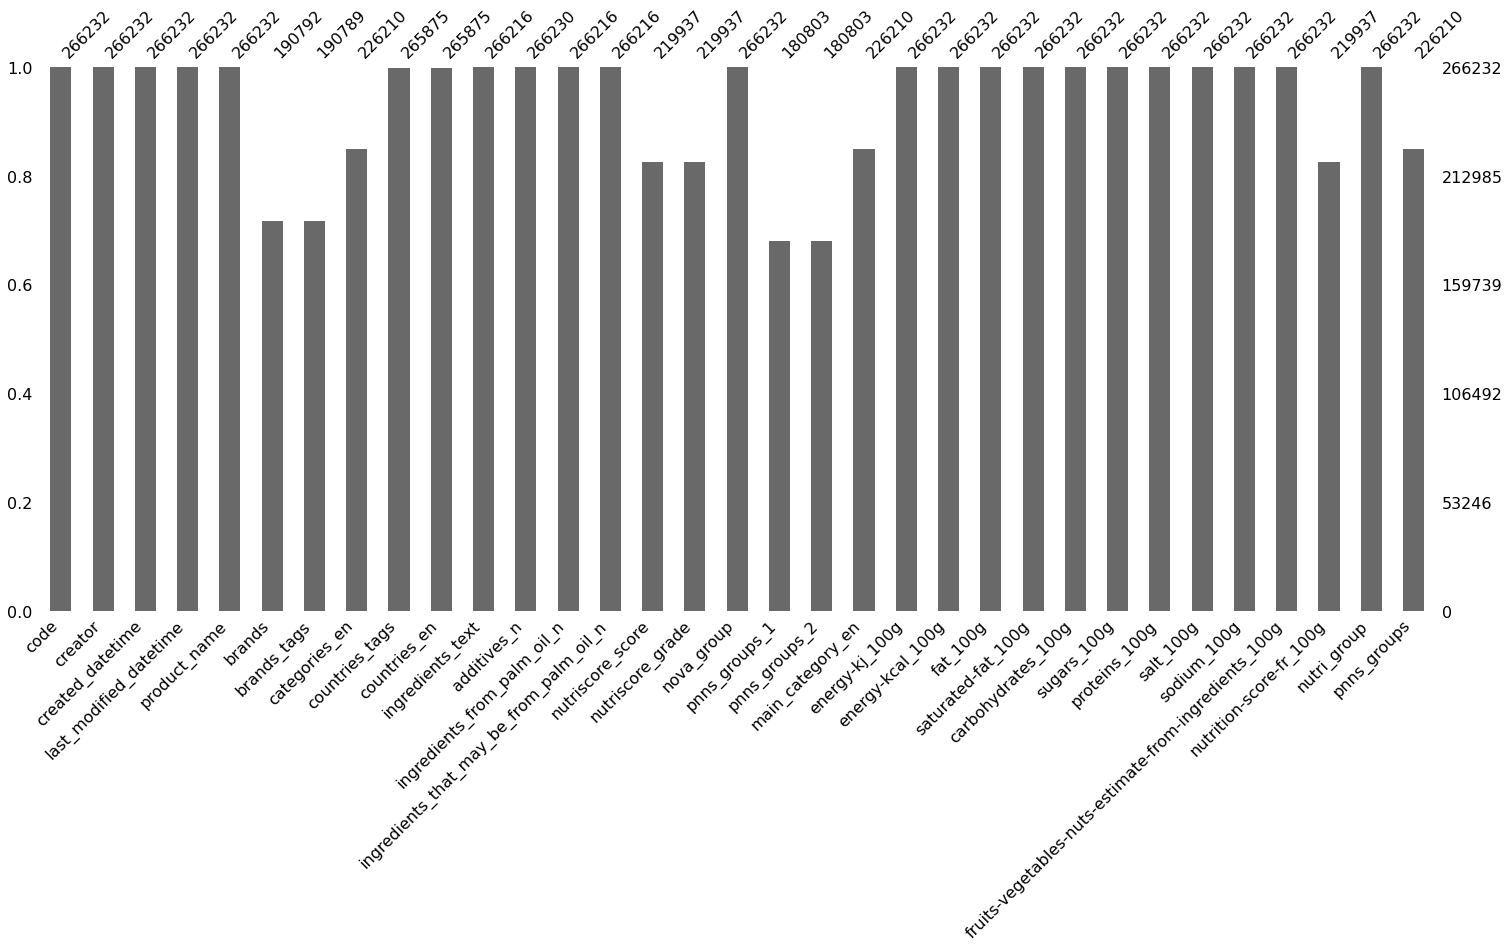

In [54]:
msno.bar(df_na)

### Traitement des données pays

In [55]:
# ----- Traitement des pays -----#
df_country = va_geo_nutriscore.split_country_columns(df_na, 'countries_tags', verbose)
df_country.shape

split_country_columns 251 >241 >234 >232 in 5.30 secondes................................................... END


(232, 1)

In [56]:
sorted(df_country["country"].unique())

['afghanistan',
 'aland-islands',
 'albania',
 'aldi',
 'alemania',
 'algeria',
 'algerie',
 'allemagne',
 'american-samoa',
 'andorra',
 'angola',
 'anguilla',
 'argentina',
 'aruba',
 'australia',
 'austria',
 'autriche',
 'azerbaijan',
 'badajoz',
 'bahrain',
 'bangladesh',
 'barbados',
 'belarus',
 'belgica',
 'belgie',
 'belgien',
 'belgique',
 'belgium',
 'benin',
 'bermuda',
 'bolivia',
 'bosnia-and-herzegovina',
 'brazil',
 'brunei',
 'bulgaria',
 'burkina-faso',
 'cambodia',
 'cameroon',
 'canada',
 'cape-verde',
 'central-african-republic',
 'chile',
 'china',
 'colombia',
 'cook-islands',
 'costa-rica',
 'cote-d-ivoire',
 'croatia',
 'cuba',
 'curacao',
 'cyprus',
 'czech-republic',
 'danemark',
 'democratic-republic-of-the-congo',
 'denmark',
 'deutschland',
 'djibouti',
 'dom-tom',
 'dominica',
 'dominican-republic',
 'ecuador',
 'egypt',
 'el-salvador',
 'england',
 'espagne',
 'espanha',
 'españa',
 'estados-unidos',
 'estonia',
 'etats-unis',
 'european-union',
 'faroe-

In [57]:
df_country.head(10)

country
0          germany
2           france
4          austria
6    united-states
8            italy
10         morocco
12         belgium
14         algeria
16  united-kingdom
18     switzerland

In [58]:
countries_names = df_country["country"]
countries_names_origin_to_new = va_geo_nutriscore.get_official_country_name(countries_names, verbose=True)
countries_names_origin_to_new

clean_countries_names 
'germany' : 'Germany',
'france' : 'France',
'austria' : 'Austria',
'united-states' : 'United States',
'italy' : 'Italy',
'morocco' : 'Morocco',
'belgium' : 'Belgium',
'algeria' : 'Algeria',
'united-kingdom' : 'United Kingdom',
'switzerland' : 'Switzerland',
'spain' : 'Spain',
'martinique' : 'Martinique',
'luxembourg' : 'Luxembourg',
'ireland' : 'Ireland',
'netherlands' : 'Netherlands',
'australia' : 'Australia',
'bulgaria' : 'Bulgaria',
'canada' : 'Canada',
'norway' : 'Norway',
'romania' : 'Romania',
'venezuela' : 'Venezuela',
'slovenia' : 'Slovenia',
'india' : 'India',
'cote-d-ivoire' : 'Ivory Coast',
'democratic-republic-of-the-congo' : 'Democratic Republic Of The Congo',
'liechtenstein' : 'Liechtenstein',
'curacao' : 'Curacao',
'philippines' : 'Philippines',
'malta' : 'Malta',
'ecuador' : 'Ecuador',
'hong-kong' : 'Hong Kong',
'puerto-rico' : 'Puerto Rico',
'francia' : 'France',
'reunion' : 'Reunion',
'brazil' : 'Brazil',
'turkey' : 'Turkey',
'new-zealand' : 'N

{'germany': 'Germany',
 'france': 'France',
 'austria': 'Austria',
 'united-states': 'United States',
 'italy': 'Italy',
 'morocco': 'Morocco',
 'belgium': 'Belgium',
 'algeria': 'Algeria',
 'united-kingdom': 'United Kingdom',
 'switzerland': 'Switzerland',
 'spain': 'Spain',
 'martinique': 'Martinique',
 'luxembourg': 'Luxembourg',
 'ireland': 'Ireland',
 'netherlands': 'Netherlands',
 'australia': 'Australia',
 'bulgaria': 'Bulgaria',
 'canada': 'Canada',
 'norway': 'Norway',
 'romania': 'Romania',
 'venezuela': 'Venezuela',
 'slovenia': 'Slovenia',
 'india': 'India',
 'cote-d-ivoire': 'Ivory Coast',
 'democratic-republic-of-the-congo': 'Democratic Republic Of The Congo',
 'liechtenstein': 'Liechtenstein',
 'curacao': 'Curacao',
 'philippines': 'Philippines',
 'malta': 'Malta',
 'ecuador': 'Ecuador',
 'hong-kong': 'Hong Kong',
 'puerto-rico': 'Puerto Rico',
 'francia': 'France',
 'reunion': 'Reunion',
 'brazil': 'Brazil',
 'turkey': 'Turkey',
 'new-zealand': 'New Zealand',
 'qatar': 

In [59]:
df_na.shape

(266232, 33)

In [60]:
df_na.columns

Index(['code', 'creator', 'created_datetime', 'last_modified_datetime',
       'product_name', 'brands', 'brands_tags', 'categories_en',
       'countries_tags', 'countries_en', 'ingredients_text', 'additives_n',
       'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutriscore_score',
       'nutriscore_grade', 'nova_group', 'pnns_groups_1', 'pnns_groups_2',
       'main_category_en', 'energy-kj_100g', 'energy-kcal_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g',
       'fruits-vegetables-nuts-estimate-from-ingredients_100g',
       'nutrition-score-fr_100g', 'nutri_group', 'pnns_groups'],
      dtype='object')

In [61]:
final_df_countries = va_geo_nutriscore.create_df_by_country_with_location(countries_names_origin_to_new, df_na, verbose=verbose)
if verboseMain:
    print(final_df_countries.head(10))

c:\Users\User\WORK\wokspace-simplon3\va_nutriscore\va_geo_nutriscore.py:140: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  boolean_series = df["countries_tags"].str.contains("(" + pattern + "|world|mundo)", regex=True)


...............................................
/!\ FAIL : aland-islands <=> Aland Islands <class 'TypeError'> ("'float' object is not subscriptable",) 'float' object is not subscriptable FAIL /!\
.......................................
/!\ FAIL : worldwide <=> nan <class 'TypeError'> ("object of type 'float' has no len()",) object of type 'float' has no len() FAIL /!\
........
/!\ FAIL : salvador <=> Salvador <class 'TypeError'> ("'float' object is not subscriptable",) 'float' object is not subscriptable FAIL /!\
.....
/!\ FAIL : hrvatska <=> Hrvatska <class 'TypeError'> ("'float' object is not subscriptable",) 'float' object is not subscriptable FAIL /!\
..............................................
/!\ FAIL : saint-vincent-and-the-grenadines <=> Saint Vincent And The Grenadines <class 'TypeError'> ("'float' object is not subscriptable",) 'float' object is not subscriptable FAIL /!\
..................
/!\ FAIL : galmudug <=> Galmudug <class 'TypeError'> ("'float' object is not subsc

In [62]:
final_df_countries.shape

(2067276, 14)

#### Ecriture du fichier pays

In [63]:
now = datetime.now() # current date and time
date_time = now.strftime("%Y-%m-%d-%H_%M_%S")
# Création d'un fichier CVS plus léger pour faciliter la phase de d'analyse des données
final_df_countries.to_csv(file_path+'nutriscore_countries_' + date_time + '.csv', sep='\t', index=False)

### Ecriture du fichier de données "propres"

In [64]:
df_na.shape

(266232, 33)

In [65]:
try:
    df_na = df_na.drop('NB_NAN_LAST', axis=1)
except:
    pass
df_na.to_csv(file_path+'nutriscore_datas_' + date_time + '.csv', sep='\t', index=False)

# FIN de la partie PRE-TRAITEMENT

La suite de l'analyse a été faite dans 2 notebooks :
* nutriscore_data_analysis
* nutriscore_countries_analysis